# Preparation and Imports


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob
import os
from common import *
import json
from datetime import datetime
from matplotlib import ticker
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns

plt.style.use('thesis.mplstyle')


In [4]:
#flowReport=pd.read_csv('data\Flow_trackers_marked.csv')
attribute_combinations=pd.read_csv('attribute_combinations_entropy.csv')
#attribute_combinations_perpage=pd.read_csv('attribute_combinations_simple_perpage.csv')
#ranges = [(0.00, 0.123925721), (0.123925721,  0.270173965), ( 0.270173965, 0.505621689)]

attribute_combinations

domain consentMode       destinationHost  \
0        01net.com   acceptAll             01net.com   
1        01net.com   acceptAll            criteo.com   
2        01net.com   acceptAll       doubleclick.net   
3        01net.com   acceptAll  google-analytics.com   
4        01net.com   acceptAll            google.com   
...            ...         ...                   ...   
72382  zzounds.com   acceptAll           zzounds.com   
72383  zzounds.com   doNothing  google-analytics.com   
72384  zzounds.com   doNothing           zzounds.com   
72385  zzounds.com   rejectAll  google-analytics.com   
72386  zzounds.com   rejectAll           zzounds.com   

                                  attribute_combinations   entropy   proba  
0                                    navigator.useragent  0.051140   4.20%  
1        navigator.language, screen.width, screen.height  0.173354   4.50%  
2       navigator.useragent, screen.width, screen.height  0.197388  12.00%  
3      navigator.language, screen.width, screen.heigh...  0.225225  18.80%  
4        navigator.language, screen.width, screen.height  0.173354   4.50%  
...                                                  ...       ...     ...  
72382   screen.width, screen.height, navigator.useragent  0.197388  12.00%  
72383  navigator.language, screen.colordepth, screen....  0.225225  18.80%  
72384   screen.width, screen.height, navigator.useragent  0.197388  12.00%  
72385  navigator.language, screen.colordepth, screen....  0.225225  18.80%  
72386   screen.width, screen.height, navigator.useragent  0.197388  12.00%  

[72387 rows x 6 columns]

In [2]:
def saveLatexTable(dataframe: pd.DataFrame, filename: str):
    dataframe.style.to_latex(
        buf='tables/' + filename,
        environment='longtable',
        siunitx=True,
        hrules=True,
        clines='skip-last;index',
        multicol_align='c'
    )


# Load and Prepare Data

## Website Lists

### Tranco


In [2]:
tranco = pd.read_csv('tranco_top-1m_N7QVW_2022-10-07.csv',
                     names=['pagerank', 'domain']).iloc[0:100000, :]
tranco['rank_group'] = pd.cut(tranco.pagerank, bins=rank_group_bins)
tranco


pagerank            domain       rank_group
0             1        google.com       (0, 10000]
1             2  gtld-servers.net       (0, 10000]
2             3       youtube.com       (0, 10000]
3             4      facebook.com       (0, 10000]
4             5     microsoft.com       (0, 10000]
...         ...               ...              ...
99995     99996       mrbasic.com  (90000, 100000]
99996     99997    chartmogul.com  (90000, 100000]
99997     99998    blogpeople.net  (90000, 100000]
99998     99999       thevore.com  (90000, 100000]
99999    100000        sfmlab.com  (90000, 100000]

[100000 rows x 3 columns]

### Crawl Domains


In [3]:
crawlDomains = pd.read_csv(
    'tranco_top-100k_N7QVW_2022-10-07_with_cmp', names=['domain'])
crawlDomains


domain
0                google.com
1              facebook.com
2               netflix.com
3               twitter.com
4               youtube.com
...                     ...
11952       chinataiwan.org
11953   messybusyrental.com
11954          atterley.com
11955           thevore.com
11956  squarespace-mail.com

[11957 rows x 1 columns]

## Status Reports

### Filter Crawl


In [4]:
filterCrawlStatus = pd.read_csv('filterCrawlStatusReport.csv').merge(tranco)
filterCrawlStatus


domain                   status  pagerank       rank_group
0            google.com  compatible CMP detected         1       (0, 10000]
1      gtld-servers.net              not reached         2       (0, 10000]
2        akamaiedge.net              not reached         6       (0, 10000]
3          facebook.com  compatible CMP detected         4       (0, 10000]
4           netflix.com  compatible CMP detected         7       (0, 10000]
...                 ...                      ...       ...              ...
99995    chartmogul.com          no CMP detected     99997  (90000, 100000]
99996        sfmlab.com          no CMP detected    100000  (90000, 100000]
99997       shou.edu.cn          no CMP detected     99984  (90000, 100000]
99998           bart.nl          no CMP detected     99988  (90000, 100000]
99999    blogpeople.net              not reached     99998  (90000, 100000]

[100000 rows x 4 columns]

### Wrongly Tagged Domains

Some domains were wrongly tagged as [with CMP] after the filter crawl.
They should not have been crawled in the measurement crawl. 

In [5]:
wronglyTaggedDomains = pd.read_csv('filterCrawlWronglyTaggedAsWithCmp.csv')
wronglyTaggedDomains

pageUrl
0              qq.com
1              hp.com
2        flipkart.com
3      eventbrite.com
4             line.me
...               ...
2705          xumk.cn
2706       toshiba.eu
2707         okx1.biz
2708      xfrb.com.cn
2709  chinataiwan.org

[2710 rows x 1 columns]

### Fingerprinting Crawl


In [6]:
# .astype({'hasBanner':'bool'})
statusReport = pd.read_json(
    'crawl_results_fingerprinting/statusReport.json.gz').merge(tranco)

statusReport['wronglyTagged'] = statusReport.domain.isin(wronglyTaggedDomains.pageUrl)

statusReport.start = pd.to_datetime(statusReport.start)
statusReport.end = pd.to_datetime(statusReport.end)

statusReport['status'] = 'error in fingerprinting crawl'
statusReport.loc[~(statusReport.hasErrors), 'status'] = 'successful'

statusReport['statusSimplified'] = statusReport.error
statusReport.loc[statusReport.error == 'Successful', 'statusSimplified'] = 'successful'
statusReport.loc[statusReport.error == 'argtype error', 'statusSimplified'] = 'other crawler error'
statusReport.loc[statusReport.error == 'unspecified error', 'statusSimplified'] = 'other crawler error'
statusReport.loc[statusReport.error == 'domain skipped', 'statusSimplified'] = 'other crawler error'

statusReport['rank_group'] = pd.cut(
    statusReport.pagerank, bins=rank_group_bins)

statusReport['cmp_simplified'] = statusReport.cmp
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('trustarc')), 'cmp_simplified'] = 'trustarc'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('onetrust')), 'cmp_simplified'] = 'onetrust'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('sourcepoint')), 'cmp_simplified'] = 'sourcepoint'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('yahoo')), 'cmp_simplified'] = 'yahoo'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('Evidon')), 'cmp_simplified'] = 'Evidon'
statusReport.loc[(~(statusReport.cmp.isna())) & (statusReport.cmp.str.startswith(
    'cookieinformation')), 'cmp_simplified'] = 'cookieinformation'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('quantcast')), 'cmp_simplified'] = 'quantcast'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('paypal')), 'cmp_simplified'] = 'paypal'
statusReport.loc[(~(statusReport.cmp.isna())) & (statusReport.cmp.str.startswith(
    'cookieinformation')), 'cmp_simplified'] = 'cookieinformation'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('google')), 'cmp_simplified'] = 'google'
statusReport.loc[(~(statusReport.cmp.isna())) & (
    statusReport.cmp.str.startswith('bbc_fc')), 'cmp_simplified'] = 'funding choices'

statusReport['cmp_simplified_othered'] = otherSeries(
    statusReport.cmp_simplified, 7)
statusReport['cmp_simplified_othered_more'] = otherSeries(
    statusReport.cmp_simplified, 12)

statusReport['tld'] = statusReport.domain.str.split('.').str[-1]

statusReport


domain          reachedDomain  \
0                  yahoo.com              yahoo.com   
1                 google.com             google.com   
2               facebook.com           facebook.com   
3            googlevideo.com             google.com   
4             cloudflare.com         cloudflare.com   
...                      ...                    ...   
11952          fdocuments.in          fdocuments.in   
11953             dimelo.com                    NaN   
11954              srv00.com              srv00.com   
11955        cgmagonline.com                    NaN   
11956  steamcardexchange.net  steamcardexchange.net   

                                 start                              end  \
0     2022-11-22 09:38:50.097000+00:00 2022-11-22 09:42:56.915000+00:00   
1     2022-11-22 09:38:50.069000+00:00 2022-11-22 09:42:59.023000+00:00   
2     2022-11-22 09:38:50.095000+00:00 2022-11-22 09:42:59.675000+00:00   
3     2022-11-22 09:38:50.099000+00:00 2022-11-22 09:43:18.030000+00:00   
4     2022-11-22 09:38:50.097000+00:00 2022-11-22 09:43:57.246000+00:00   
...                                ...                              ...   
11952 2022-12-05 07:46:58.361000+00:00 2022-12-05 07:53:54.555000+00:00   
11953 2022-12-05 07:46:58.364000+00:00 2022-12-05 07:56:30.764000+00:00   
11954 2022-12-05 07:46:58.362000+00:00 2022-12-05 08:01:08.431000+00:00   
11955 2022-12-05 07:46:58.363000+00:00 2022-12-05 08:06:21.590000+00:00   
11956 2022-12-05 07:46:58.361000+00:00 2022-12-05 08:59:59.307000+00:00   

       hasErrors              error                         originalFile  \
0          False         Successful  results.json_00000000-00000009.json   
1          False         Successful  results.json_00000000-00000009.json   
2          False         Successful  results.json_00000000-00000009.json   
3          False         Successful  results.json_00000000-00000009.json   
4          False         Successful  results.json_00000000-00000009.json   
...          ...                ...                                  ...   
11952      False         Successful  results.json_00012110-00012114.json   
11953       True  unspecified error  results.json_00012110-00012114.json   
11954       True             no CMP  results.json_00012110-00012114.json   
11955       True      timeout error  results.json_00012110-00012114.json   
11956       True             no CMP  results.json_00012110-00012114.json   

                   cmp                                 cmps  pagerank  \
0          yahoo_popup         [yahoo_popup, yahoo_consent]        16   
1         google_popup                       [google_popup]         1   
2             Facebook                           [Facebook]         4   
3         google_popup                       [google_popup]        36   
4      onetrust_banner  [onetrust_banner, onetrust_pcpanel]        14   
...                ...                                  ...       ...   
11952           bbc_fc                             [bbc_fc]     96374   
11953              NaN                                  NaN     99618   
11954              NaN                                  NaN     97483   
11955              NaN                                  NaN     97805   
11956              NaN                                  NaN     95994   

            rank_group  wronglyTagged                         status  \
0           (0, 10000]          False                     successful   
1           (0, 10000]          False                     successful   
2           (0, 10000]          False                     successful   
3           (0, 10000]          False                     successful   
4           (0, 10000]          False                     successful   
...                ...            ...                            ...   
11952  (90000, 100000]          False                     successful   
11953  (90000, 100000]          False  error in fingerprinting crawl   
11954  (90000, 100000]

### Wrongly Tagged Insights and Fix

In [7]:
statusReport.pivot_table(values='domain',index='error',columns='wronglyTagged',aggfunc='count',margins=True)

wronglyTagged      False  True    All
error                                
Successful          5663   155   5818
argtype error         26     3     29
domain skipped        21     3     24
no CMP              1802  2161   3963
timeout error        788    39    827
unreachable          475   142    617
unspecified error    472   207    679
All                 9247  2710  11957

In [8]:
statusReport.loc[(statusReport.wronglyTagged) & (statusReport.error != 'Successful'),'error'] = 'scanned unintentionally'
statusReport.loc[(statusReport.wronglyTagged) & (statusReport.error != 'Successful'),'statusSimplified'] = 'scanned unintentionally'

In [9]:
statusReport.pivot_table(values='domain',index='error',columns='wronglyTagged',aggfunc='count',margins=True)

wronglyTagged             False    True    All
error                                         
Successful               5663.0   155.0   5818
argtype error              26.0     NaN     26
domain skipped             21.0     NaN     21
no CMP                   1802.0     NaN   1802
scanned unintentionally     NaN  2555.0   2555
timeout error             788.0     NaN    788
unreachable               475.0     NaN    475
unspecified error         472.0     NaN    472
All                      9247.0  2710.0  11957

In [10]:
succesfulDomains= statusReport[~(statusReport.hasErrors)].shape[0]
succesfulDomains

5818

In [11]:
# Assuming you have the 'statusReport' and 'flowreport' DataFrames
# Create a new DataFrame with domains from statusReport that have no errors
no_errors_domains = statusReport[~statusReport['hasErrors']]['domain']

# Check if the domains exist in flowreport using isin() function
statusReport['existsInFlowReport'] = no_errors_domains.isin(flowReport['domain'])


# Get the unique domains that have True in the 'existsInFlowReport' column
unique_domains = statusReport[statusReport['existsInFlowReport'] == True]['domain'].drop_duplicates()

# Print the unique domains
print(unique_domains)



NameError: name 'flowReport' is not defined

### Without CMP


In [11]:
# statusReport[statusReport.error=='no CMP'].reset_index().loc[10:40,:]  #.head(20) #.tail(20)


In [12]:
# statusReport[statusReport.hasErrors==False].reset_index().iloc[20:40,:]


## Flows


In [2]:
flowReport = pd.read_json(
    'crawl_results_fingerprinting/summarizedFlowReport.json.gz').astype({'page': 'int'})

flowReport.loc[flowReport.destinationHost.isna(),
               'destinationHost'] = 'UNKNOWN'
flowReport['destinationSimplified'] = flowReport.destinationHost
flowReport.loc[flowReport.destinationHost ==
               flowReport.pageHost, 'destinationSimplified'] = 'first-party'
flowReport['destinationSimplifiedOthered'] = otherSeries(
    flowReport.destinationSimplified, 10)


flowReport['isFirstParty'] = flowReport.pageHost == flowReport.destinationHost
flowReport['destinationCategory'] = 'third-party'
flowReport.loc[flowReport.isFirstParty, 'destinationCategory'] = 'first-party'
flowReport.loc[flowReport.destinationHost ==
               'UNKNOWN', 'destinationCategory'] = 'UNKNOWN'

flowReport['transmission'] = flowReport.source + \
    ':' + flowReport.destinationHost

flowReport['sinkSimplified'] = 'other'
flowReport.loc[flowReport.sink.str.startswith('XML'),'sinkSimplified'] = 'XML HTTP Request'
flowReport.loc[flowReport.sink.str.startswith('fetch'),'sinkSimplified'] = 'Fetch API'
flowReport.loc[flowReport.sink.str.startswith('img.'),'sinkSimplified'] = 'image source'
flowReport.loc[flowReport.sink.str.startswith('WebSocket'),'sinkSimplified'] = 'Web Socket'
flowReport.loc[flowReport.sink.str.startswith('iframe'),'sinkSimplified'] = 'iFrame source'
flowReport.loc[flowReport.sink.str.startswith('document.cookie'),'sinkSimplified'] = 'Cookie'
flowReport.loc[flowReport.sink.str.startswith('script'),'sinkSimplified'] = 'script source'
flowReport.loc[flowReport.sink.str.startswith('navigator.sendBeacon'),'sinkSimplified'] = 'sendBeacon()'


# Exclude flows to malformed destination URLs
# Amount of those is negligible (see output of postprocessing for details)
before = flowReport.shape[0]
print(f'Lines before excluding malformed destinations: {before}')
flowReport = flowReport[flowReport.destinationHost != 'UNKNOWN']
print(f'Lines after  excluding malformed destinations: {flowReport.shape[0]}')
print(f'Difference between before and after: {before-flowReport.shape[0]}')


flowReport


Lines before excluding malformed destinations: 1800846
Lines after  excluding malformed destinations: 1800119
Difference between before and after: 727


domain consentMode  page       pageHost      frameHost  \
0            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
1            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
2            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
3            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
4            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
...                ...         ...   ...            ...            ...   
1800841  fdocuments.in   doNothing     3  fdocuments.in  fdocuments.in   
1800842  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   
1800843  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   
1800844  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   
1800845  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   

              destinationHost              source            sourceHost  \
0                   yahoo.com        Screen.width              yimg.com   
1                   yahoo.com       Screen.height              yimg.com   
2                   yahoo.com   Screen.availWidth              yimg.com   
3                   yahoo.com  Screen.availHeight              yimg.com   
4                   yahoo.com        Screen.width              yimg.com   
...                       ...                 ...                   ...   
1800841  google-analytics.com       Screen.height  google-analytics.com   
1800842  google-analytics.com  Navigator.language  google-analytics.com   
1800843  google-analytics.com   Screen.colorDepth  google-analytics.com   
1800844  google-analytics.com        Screen.width  google-analytics.com   
1800845  google-analytics.com       Screen.height  google-analytics.com   

                              sink              sinkHost  \
0        navigator.sendBeacon(url)              yimg.com   
1        navigator.sendBeacon(url)              yimg.com   
2        navigator.sendBeacon(url)              yimg.com   
3        navigator.sendBeacon(url)              yimg.com   
4        navigator.sendBeacon(url)              yimg.com   
...                            ...                   ...   
1800841   XMLHttpRequest.open(url)  google-analytics.com   
1800842   XMLHttpRequest.open(url)  google-analytics.com   
1800843   XMLHttpRequest.open(url)  google-analytics.com   
1800844   XMLHttpRequest.open(url)  google-analytics.com   
1800845   XMLHttpRequest.open(url)  google-analytics.com   

        destinationSimplified destinationSimplifiedOthered  isFirstParty  \
0                 first-party                  first-party          True   
1                 first-party                  first-party          True   
2                 first-party                  first-party          True   
3                 first-party                  first-party          True   
4                 first-party                  first-party          True   
...                       ...                          ...           ...   
1800841  google-analytics.com         google-analytics.com         False   
1800842  google-analytics.com         google-analytics.com         False   
1800843  google-analytics.com         google-analytics.com         False   
1800844  google-analytics.com         google-analytics.com         False   
1800845  google-analytics.com         google-analytics.com         False   

        destinationCategory                             transmission  \
0               first-party                   Screen.width:yahoo.com   
1               first-party                  Screen.height:yahoo.com   
2               first-party              Screen.availWidth:yahoo.com   
3               first-party             Screen.availHeight:yahoo.com   
4               first-party                   Screen.width:yahoo.com   
...                     ...                                      ...   
1800841         third-party       Screen.height:google-analytics.com   
1800842         

In [110]:
unique_domains =attribute_combinations['domain'].nunique()

print(f"Number of unique domains in flowreport: {unique_domains}")

Number of unique domains in flowreport: 5464


In [6]:
### collect combinations
attribute_combinations = flowReport.groupby(['domain','consentMode','destinationHost'])['source'].apply(lambda x: list(x.unique())).reset_index(name='attribute_combinations')

attribute_combinations

domain consentMode       destinationHost  \
0        01net.com   acceptAll             01net.com   
1        01net.com   acceptAll            criteo.com   
2        01net.com   acceptAll       doubleclick.net   
3        01net.com   acceptAll  google-analytics.com   
4        01net.com   acceptAll            google.com   
...            ...         ...                   ...   
72382  zzounds.com   acceptAll           zzounds.com   
72383  zzounds.com   doNothing  google-analytics.com   
72384  zzounds.com   doNothing           zzounds.com   
72385  zzounds.com   rejectAll  google-analytics.com   
72386  zzounds.com   rejectAll           zzounds.com   

                                  attribute_combinations  
0                                  [Navigator.userAgent]  
1      [Navigator.language, Screen.width, Screen.height]  
2      [Navigator.userAgent, Screen.width, Screen.hei...  
3      [Navigator.language, Screen.width, Screen.heig...  
4      [Navigator.language, Screen.width, Screen.height]  
...                                                  ...  
72382  [Screen.width, Screen.height, Navigator.userAg...  
72383  [Navigator.language, Screen.colorDepth, Screen...  
72384  [Screen.width, Screen.height, Navigator.userAg...  
72385  [Navigator.language, Screen.colorDepth, Screen...  
72386  [Screen.width, Screen.height, Navigator.userAg...  

[72387 rows x 4 columns]

In [101]:
# Assuming you have the 'flowreport' DataFrame with the 'domain' column
unique_domains = attribute_combinations['domain'].nunique()

print(f"Number of unique domains in flowreport: {unique_domains}")


Number of unique domains in flowreport: 5464


In [7]:
# Create a DataFrame with unique sinkHost values
unique_sinkHost = pd.DataFrame({'sinkHost': flowReport['sinkHost'].unique()})

# Save unique sinkHost DataFrame as CSV
unique_sinkHost.to_csv('unique_sinkHost.csv', index=False)

# Print the number of unique sinkHost values
print("Number of unique sinkHost:", unique_sinkHost.shape[0])

# Create a DataFrame with unique destinationHost values
unique_destinationHost = pd.DataFrame({'destinationHost': flowReport['destinationHost'].unique()})

# Save unique destinationHost DataFrame as CSV
unique_destinationHost.to_csv('unique_destinationHost.csv', index=False)

# Print the number of unique destinationHost values
print("Number of unique destinationHost:", unique_destinationHost.shape[0])

# Create a DataFrame with unique sourceHost values
unique_sourceHost = pd.DataFrame({'sourceHost': flowReport['sourceHost'].unique()})

# Save unique sourceHost DataFrame as CSV
unique_sourceHost.to_csv('unique_sourceHost.csv', index=False)

# Print the number of unique sourceHost values
print("Number of unique sourceHost:", unique_sourceHost.shape[0])

# Create a combined list of unique hosts
unique_hosts = pd.concat([unique_sinkHost['sinkHost'], unique_destinationHost['destinationHost'], unique_sourceHost['sourceHost']])
unique_hosts = unique_hosts.drop_duplicates()

unique_hosts.to_csv('unique_host.csv',index=False)
# Print the number of unique hosts
print("Number of unique hosts:", unique_hosts.shape[0])



Number of unique sinkHost: 2742
Number of unique destinationHost: 5035
Number of unique sourceHost: 2721
Number of unique hosts: 5892


In [8]:
attribute_combinations_perpage = flowReport.groupby(['domain','page','consentMode','destinationHost'])['source'].apply(lambda x: list(x.unique())).reset_index(name='attribute_combinations')

attribute_combinations_perpage

domain  page consentMode       destinationHost  \
0         01net.com     0   acceptAll             01net.com   
1         01net.com     0   acceptAll            criteo.com   
2         01net.com     0   acceptAll       doubleclick.net   
3         01net.com     0   acceptAll  google-analytics.com   
4         01net.com     0   acceptAll            google.com   
...             ...   ...         ...                   ...   
209069  zzounds.com     3   doNothing  google-analytics.com   
209070  zzounds.com     3   rejectAll  google-analytics.com   
209071  zzounds.com     4   acceptAll  google-analytics.com   
209072  zzounds.com     4   doNothing  google-analytics.com   
209073  zzounds.com     4   rejectAll  google-analytics.com   

                                   attribute_combinations  
0                                   [Navigator.userAgent]  
1       [Navigator.language, Screen.width, Screen.height]  
2       [Navigator.userAgent, Screen.width, Screen.hei...  
3       [Navigator.language, Screen.width, Screen.heig...  
4       [Navigator.language, Screen.width, Screen.height]  
...                                                   ...  
209069  [Navigator.language, Screen.colorDepth, Screen...  
209070  [Navigator.language, Screen.colorDepth, Screen...  
209071  [Navigator.language, Screen.colorDepth, Screen...  
209072  [Navigator.language, Screen.colorDepth, Screen...  
209073  [Navigator.language, Screen.colorDepth, Screen...  

[209074 rows x 5 columns]

In [9]:


# Assuming you have a DataFrame named 'df'
attribute_combinations_perpage.to_csv('attribute_combinations_consent_perpage.csv', index=False)

attribute_combinations.to_csv('attribute_combinations_consent.csv', index=False)

In [3]:
#Copy of sum_entrpy-unique_combi.csv
Entropy=pd.read_csv('entropy.csv')
# Convert attribute combinations in Entropy DataFrame to frozenset as well

Entropy


Vectors    joint_H  \
0                               AudioContext.baseLatency   2.459223   
1                             AudioContext.outputLatency   0.000000   
2                   AudioDestinationNode.maxChannelCount   0.229761   
3                                 AudioNode.channelCount   0.000000   
4                               AudioNode.numberOfInputs   0.000000   
...                                                  ...        ...   
15234  Navigator.maxTouchPoints|AudioContext.baseLate...  14.045911   
15235  Navigator.userAgent|Navigator.doNotTrack|HTMLC...  13.127296   
15236  Screen.width|Screen.height|Navigator.platform|...  11.354211   
15237  Navigator.platform|Navigator.appName|Screen.wi...  13.966075   
15238  Navigator.userAgent|Screen.height|Screen.width...  14.057875   

       joint_H_n     anon_set  
0       0.290849   243.806268  
1       0.000000     0.000000  
2       0.056211  5033.882353  
3       0.000000     0.000000  
4       0.000000     0.000000  
...          ...          ...  
15234   0.916522     2.084474  
15235   0.874133     2.580077  
15236   0.796308     4.366122  
15237   0.913919     2.148585  
15238   0.918977     2.125214  

[15239 rows x 4 columns]

In [8]:
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].astype(str)
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].str.replace('[\[\]]', '', regex=True)
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].str.replace("'", '', regex=True)


# Convert the 'attribute_combinations' column in attribute_combinations DataFrame to lowercase
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].str.lower()

# Convert the 'attribute_combinations' column in Entropy DataFrame to lowercase
Entropy['Vectors'] = Entropy['Vectors'].str.lower()

# Create a new column in attribute_combinations DataFrame to store the matched entropy values
attribute_combinations['entropy'] = attribute_combinations['attribute_combinations'].apply(
    lambda x: Entropy.loc[Entropy['Vectors'].apply(
        lambda y: set(map(str.strip, y.split('|'))) == set(map(str.strip, x.split(','))))
    ]["joint_H_n"].iloc[0] if not pd.isna(x) and len(Entropy.loc[Entropy['Vectors'].apply(
        lambda y: set(map(str.strip, y.split('|'))) == set(map(str.strip, x.split(','))))
    ]["joint_H_n"]) > 0 else None
)

# Fill the NaN values in the entropy column with 0
attribute_combinations['entropy'] = attribute_combinations['entropy'].fillna(0)

# Save the modified DataFrame as a CSV file
attribute_combinations.to_csv('attribute_combinations_entropy.csv', index=False)

In [9]:
attribute_combinations


domain consentMode       destinationHost  \
0        01net.com   acceptAll             01net.com   
1        01net.com   acceptAll            criteo.com   
2        01net.com   acceptAll       doubleclick.net   
3        01net.com   acceptAll  google-analytics.com   
4        01net.com   acceptAll            google.com   
...            ...         ...                   ...   
72382  zzounds.com   acceptAll           zzounds.com   
72383  zzounds.com   doNothing  google-analytics.com   
72384  zzounds.com   doNothing           zzounds.com   
72385  zzounds.com   rejectAll  google-analytics.com   
72386  zzounds.com   rejectAll           zzounds.com   

                                  attribute_combinations   entropy   proba  
0                                    navigator.useragent  0.564534   4.20%  
1        navigator.language, screen.width, screen.height  0.651570   4.50%  
2       navigator.useragent, screen.width, screen.height  0.762223  12.00%  
3      navigator.language, screen.width, screen.heigh...  0.796308  18.80%  
4        navigator.language, screen.width, screen.height  0.651570   4.50%  
...                                                  ...       ...     ...  
72382   screen.width, screen.height, navigator.useragent  0.762223  12.00%  
72383  navigator.language, screen.colordepth, screen....  0.796308  18.80%  
72384   screen.width, screen.height, navigator.useragent  0.762223  12.00%  
72385  navigator.language, screen.colordepth, screen....  0.796308  18.80%  
72386   screen.width, screen.height, navigator.useragent  0.762223  12.00%  

[72387 rows x 6 columns]

In [12]:
dp= pd.read_csv('../firefox_sap.csv')
dp

attribute_combinations probabilityF  \
0                                PermissionStatus.state        0.10%   
1           StorageEstimate.quota|StorageEstimate.usage       19.30%   
2     Navigator.appCodeName|Navigator.language|Navig...        5.20%   
3     Navigator.appVersion|Navigator.language|Naviga...        5.20%   
4     Navigator.language|Navigator.maxTouchPoints|Na...        5.20%   
...                                                 ...          ...   
7847  Navigator.maxTouchPoints| AudioContext.baseLat...       36.00%   
7848  Navigator.userAgent| Navigator.doNotTrack| HTM...       29.90%   
7849  Screen.width| Screen.height| Navigator.platfor...       18.80%   
7850  Navigator.platform| Navigator.appName| Screen....       34.20%   
7851  Navigator.userAgent| Screen.height| Screen.wid...       35.90%   

      norm agg entropy: [0,1]  
0                    0.026055  
1                    0.025102  
2                    0.174527  
3                    0.174527  
4                    0.174527  
...                       ...  
7847                 0.476722  
7848                 0.292678  
7849                 0.371473  
7850                 0.468293  
7851                 0.329182  

[7852 rows x 3 columns]

In [140]:
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].astype(str)
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].str.replace('[\[\]]', '', regex=True)
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].str.replace("'", '', regex=True)

# Convert the 'attribute_combinations' column in attribute_combinations DataFrame to lowercase
attribute_combinations['attribute_combinations'] = attribute_combinations['attribute_combinations'].str.lower()

# Convert the 'attribute_combinations' column in dp DataFrame to lowercase
dp['attribute_combinations'] = dp['attribute_combinations'].str.lower()

# Create a new column in attribute_combinations DataFrame to store the matched probability values
attribute_combinations['proba'] = attribute_combinations['attribute_combinations'].apply(
    lambda x: dp.loc[dp['attribute_combinations'].apply(
        lambda y: set(map(str.strip, y.split('|'))) == set(map(str.strip, x.split(','))))
    ]['probabilityF'].iloc[0] if not pd.isna(x) and len(dp.loc[dp['attribute_combinations'].apply(
        lambda y: set(map(str.strip, y.split('|'))) == set(map(str.strip, x.split(','))))
    ]['probabilityF']) > 0 else None
)

# Fill the NaN values in the proba column with 0
attribute_combinations['proba'] = attribute_combinations['proba'].fillna(0)

In [141]:
attribute_combinations.to_csv('attributecomboTotal.csv',index=False)

In [28]:
# Remove '%' symbol and convert to float
#attribute_combinations['proba'] = attribute_combinations['proba'].str.rstrip('%').astype(float) / 100

attribute_combinations=pd.read_csv('attributecomboTotal.csv')

In [30]:
attribute_combinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72387 entries, 0 to 72386
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   domain                  72387 non-null  object 
 1   consentMode             72387 non-null  object 
 2   destinationHost         72387 non-null  object 
 3   attribute_combinations  72387 non-null  object 
 4   entropy                 72387 non-null  float64
 5   proba                   72387 non-null  object 
dtypes: float64(1), object(5)
memory usage: 3.3+ MB


In [33]:
import pandas as pd

# Assuming you have the DataFrame 'attribute_combinations'
# Replace 'attribute_combinations' with the actual DataFrame name if different

# Use .loc to filter rows where 'entropy' is 0
entropy_zero_rows = attribute_combinations.loc[attribute_combinations['entropy'] == 0]

# Display the DataFrame with rows where 'entropy' is 0
entropy_zero_rows


domain consentMode   destinationHost  \
102        20minutos.es   acceptAll  besoccerapps.com   
110        20minutos.es   doNothing  besoccerapps.com   
117        20minutos.es   rejectAll  besoccerapps.com   
257     2paragraphs.com   acceptAll      facebook.com   
265     2paragraphs.com   doNothing      facebook.com   
...                 ...         ...               ...   
71727         zelda.com   doNothing      facebook.com   
71738         zelda.com   rejectAll      facebook.com   
71883  zennioptical.com   acceptAll      facebook.com   
71896  zennioptical.com   doNothing      facebook.com   
71909  zennioptical.com   rejectAll      facebook.com   

        attribute_combinations  entropy proba  
102    htmlelement.offsetwidth      0.0     0  
110    htmlelement.offsetwidth      0.0     0  
117    htmlelement.offsetwidth      0.0     0  
257    htmlelement.offsetwidth      0.0     0  
265    htmlelement.offsetwidth      0.0     0  
...                        ...      ...   ...  
71727  htmlelement.offsetwidth      0.0     0  
71738  htmlelement.offsetwidth      0.0     0  
71883  htmlelement.offsetwidth      0.0     0  
71896  htmlelement.offsetwidth      0.0     0  
71909  htmlelement.offsetwidth      0.0     0  

[630 rows x 6 columns]

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

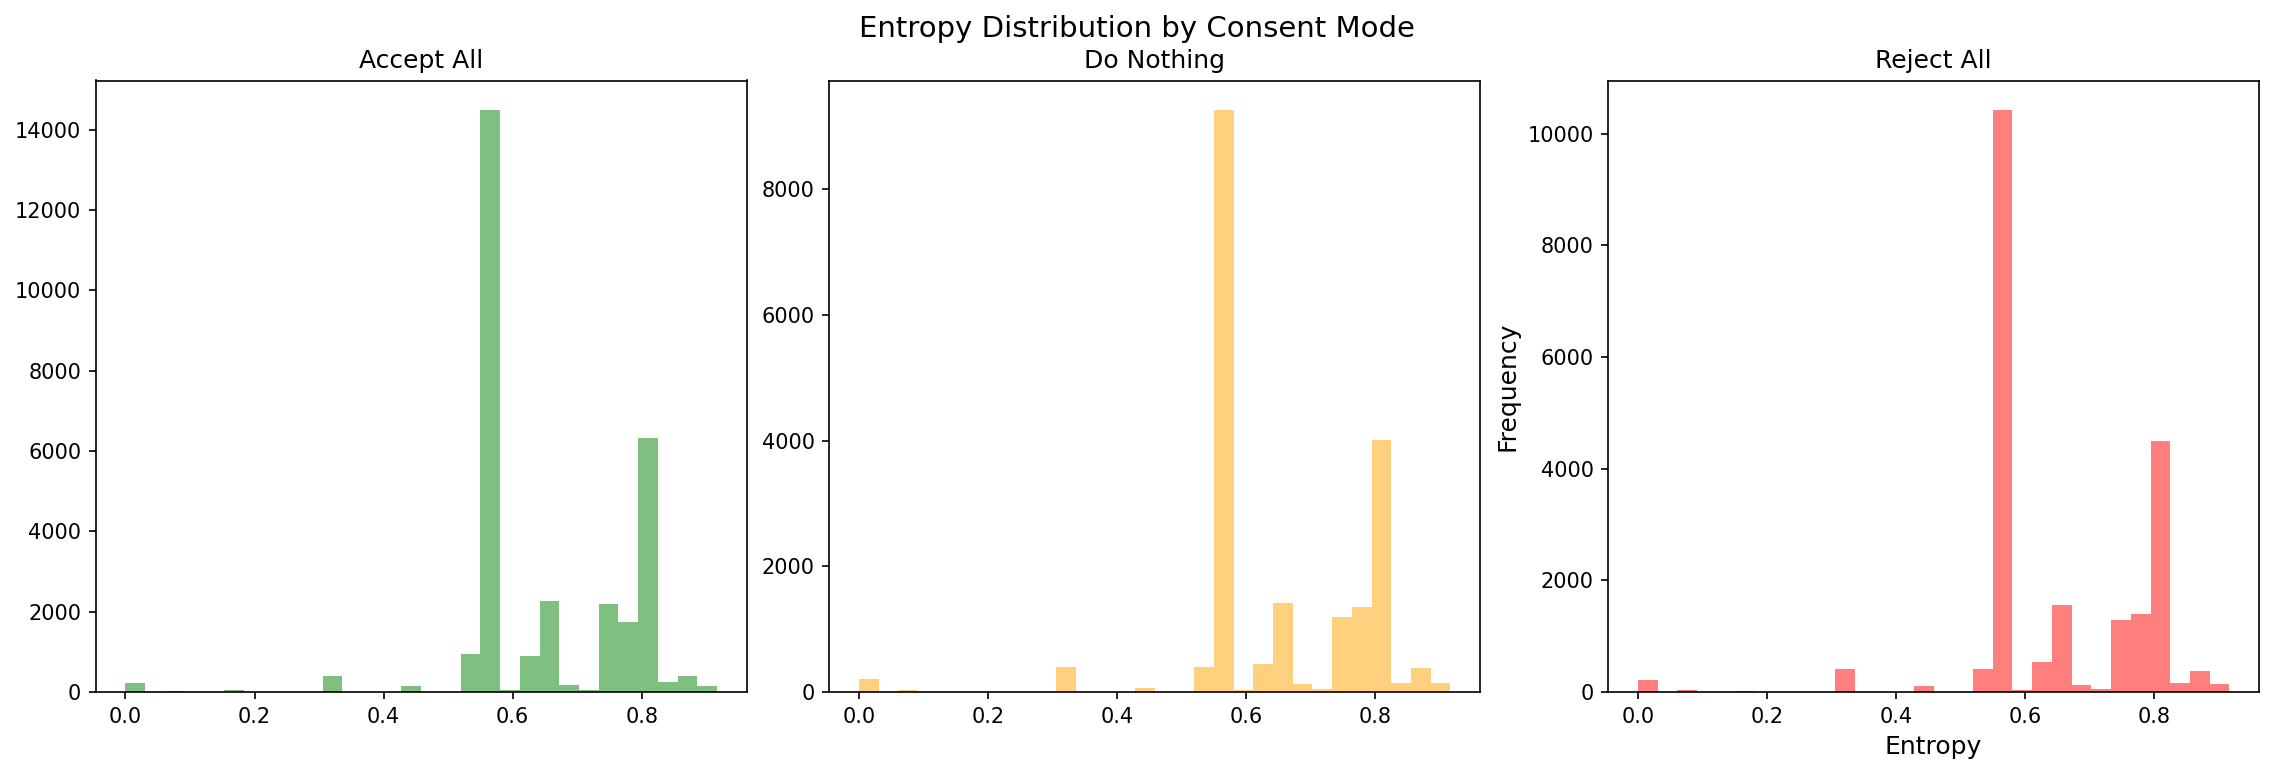

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' with 'entropy' and 'consentMode' columns
df = attribute_combinations

# Separate the data based on consent mode
accept_all_entropy = df[df['consentMode'] == 'acceptAll']['entropy']
do_nothing_entropy = df[df['consentMode'] == 'doNothing']['entropy']
reject_all_entropy = df[df['consentMode'] == 'rejectAll']['entropy']

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each consent mode separately with different colors
axs[0].hist(accept_all_entropy, bins=30, alpha=0.5, color='green')
axs[0].set_title('Accept All')

axs[1].hist(do_nothing_entropy, bins=30, alpha=0.5, color='orange')
axs[1].set_title('Do Nothing')

axs[2].hist(reject_all_entropy, bins=30, alpha=0.5, color='red')
axs[2].set_title('Reject All')

# Set labels and title for the overall figure
fig.suptitle('Entropy Distribution by Consent Mode', fontsize=14)
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Save the plot as an image
plt.savefig('entropy_distribution_by_consent_mode_splited.png', dpi=300)


# Show the plots
plt.show()


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

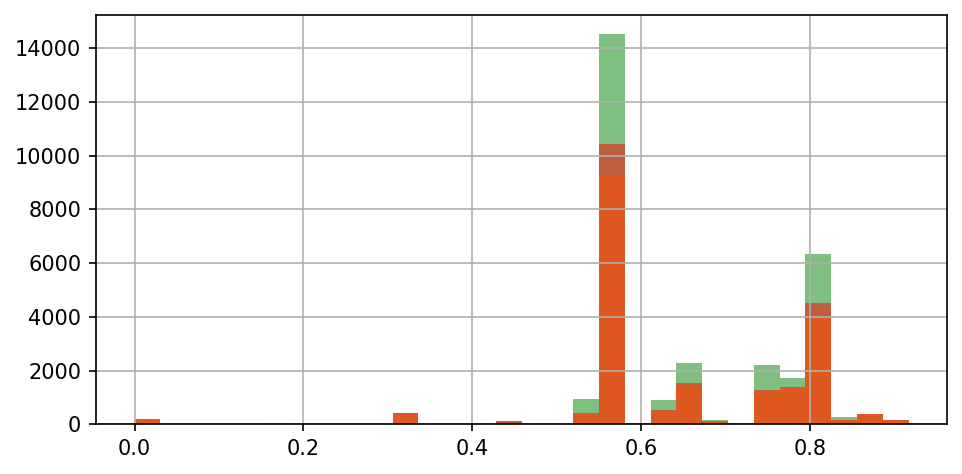

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

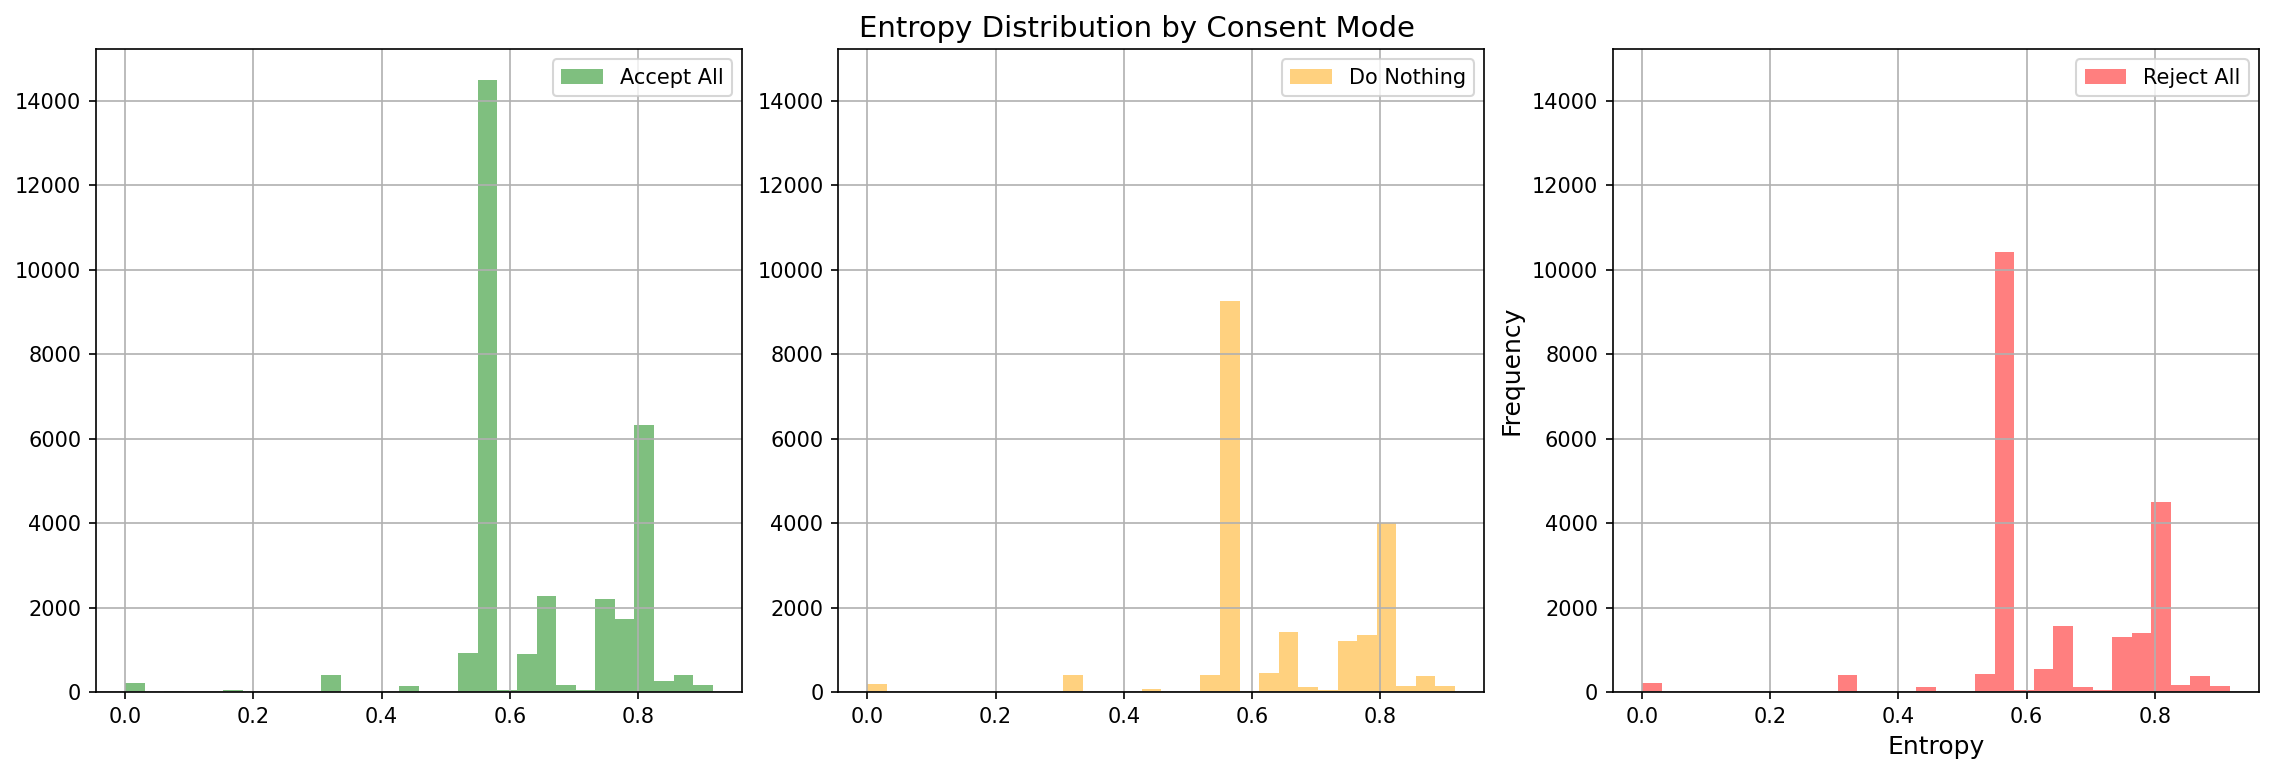

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' with 'entropy' and 'consentMode' columns
df = attribute_combinations

# Separate the data based on consent mode
accept_all_entropy = df[df['consentMode'] == 'acceptAll']['entropy']
do_nothing_entropy = df[df['consentMode'] == 'doNothing']['entropy']
reject_all_entropy = df[df['consentMode'] == 'rejectAll']['entropy']

# Find the maximum frequency among the histograms
max_freq = max(accept_all_entropy.hist(bins=30, alpha=0.5, color='green', label='Accept All').get_ylim()[1],
               do_nothing_entropy.hist(bins=30, alpha=0.5, color='orange', label='Do Nothing').get_ylim()[1],
               reject_all_entropy.hist(bins=30, alpha=0.5, color='red', label='Reject All').get_ylim()[1])

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for each consent mode separately with different colors
accept_all_entropy.hist(bins=30, alpha=0.5, color='green', ax=axs[0], label='Accept All')
do_nothing_entropy.hist(bins=30, alpha=0.5, color='orange', ax=axs[1], label='Do Nothing')
reject_all_entropy.hist(bins=30, alpha=0.5, color='red', ax=axs[2], label='Reject All')

# Set labels and title for the overall figure
fig.suptitle('Entropy Distribution by Consent Mode', fontsize=14)
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

# Set the same ylim for all subplots
for ax in axs:
    ax.set_ylim(0, max_freq)

# Add legend to the plots
for ax in axs:
    ax.legend()

# Save the plot as an image
plt.savefig('entropy_distribution_by_consent_mode_overlapping.png', dpi=300)

# Show the plots
plt.show()


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

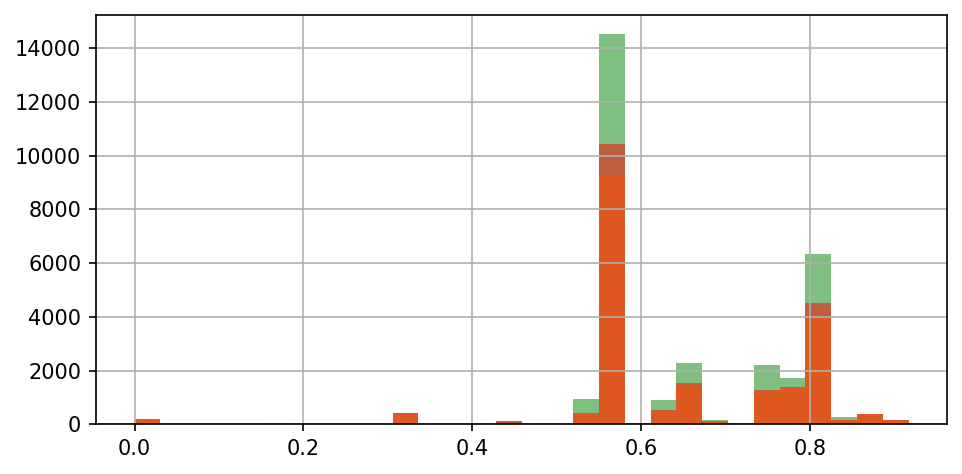

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

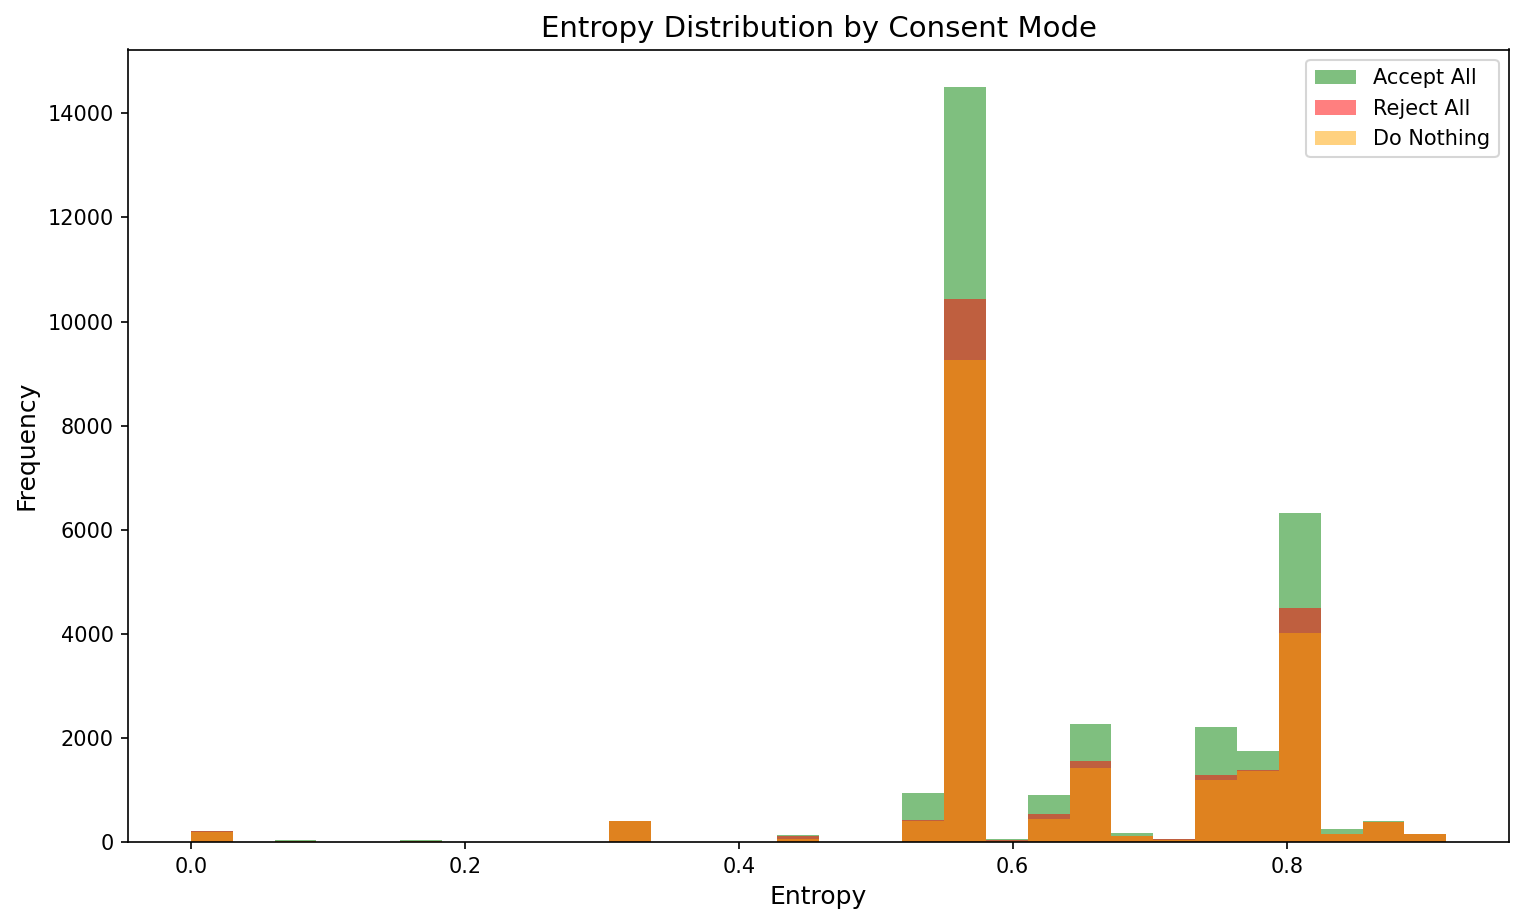

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have the DataFrame 'df' with 'entropy' and 'consentMode' columns
df = attribute_combinations

# Separate the data based on consent mode
accept_all_entropy = df[df['consentMode'] == 'acceptAll']['entropy']
reject_all_entropy = df[df['consentMode'] == 'rejectAll']['entropy']
do_nothing_entropy = df[df['consentMode'] == 'doNothing']['entropy']

# Find the maximum frequency among the histograms
max_freq = max(accept_all_entropy.hist(bins=30, alpha=0.5, color='green', label='Accept All').get_ylim()[1],
               do_nothing_entropy.hist(bins=30, alpha=0.5, color='orange', label='Do Nothing').get_ylim()[1],
               reject_all_entropy.hist(bins=30, alpha=0.5, color='red', label='Reject All').get_ylim()[1])

# Create the overlapping histogram
plt.figure(figsize=(10, 6))

plt.hist(accept_all_entropy, bins=30, alpha=0.5, color='green', label='Accept All')
plt.hist(reject_all_entropy, bins=30, alpha=0.5, color='red', label='Reject All')
plt.hist(do_nothing_entropy, bins=30, alpha=0.5, color='orange', label='Do Nothing')

# Set labels and title for the figure
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Entropy Distribution by Consent Mode', fontsize=14)

# Set the same ylim for the figure
plt.ylim(0, max_freq)

# Add the legend
plt.legend()

# Save the plot as an image
plt.savefig('entropy_distribution_by_consent_mode_overlapping_with_legend.png', dpi=300)

# Show the plot
plt.show()



In [12]:
# Create separate DataFrames for each profile
donothing_df = attribute_combinations[attribute_combinations['consentMode'] == 'doNothing']
acceptall_df = attribute_combinations[attribute_combinations['consentMode'] == 'acceptAll']
rejectall_df = attribute_combinations[attribute_combinations['consentMode'] == 'rejectAll']

# Calculate the average entropy for each profile per domain using pivot_table
donothing_entropy_avg = donothing_df.pivot_table(index='domain', values='entropy', aggfunc='mean', fill_value=0)
acceptall_entropy_avg = acceptall_df.pivot_table(index='domain', values='entropy', aggfunc='mean', fill_value=0)
rejectall_entropy_avg = rejectall_df.pivot_table(index='domain', values='entropy', aggfunc='mean', fill_value=0)

# Merge the three DataFrames into the domainActivity DataFrame
domainActivity = donothing_entropy_avg.merge(acceptall_entropy_avg, on='domain', suffixes=('_Donothing', '_AcceptALL'))
domainActivity = domainActivity.merge(rejectall_entropy_avg, on='domain', suffixes=(None, '_RejectALL'))

# Rename the columns
domainActivity = domainActivity.rename(columns={'entropy': 'entropy_RejectALL'})

# Reset the index
domainActivity.reset_index(inplace=True)

# Display the domainActivity DataFrame
print(domainActivity)

avg_entropy_donothing = domainActivity['entropy_Donothing'].mean()
avg_entropy_acceptall = domainActivity['entropy_AcceptALL'].mean()
avg_entropy_rejectall = domainActivity['entropy_RejectALL'].mean()

# Print the average of each column
print("Average Entropy for doNothing:", avg_entropy_donothing)
print("Average Entropy for acceptAll:", avg_entropy_acceptall)
print("Average Entropy for rejectAll:", avg_entropy_rejectall)

              domain  entropy_Donothing  entropy_AcceptALL  entropy_RejectALL
0          01net.com           0.796308           0.654470           0.703908
1     1001juegos.com           0.571829           0.720764           0.720764
2            1177.se           0.667026           0.667026           0.667026
3          11880.com           0.610889           0.599135           0.610889
4      123helpme.com           0.669111           0.669111           0.669111
...              ...                ...                ...                ...
4841    zycrypto.com           0.674766           0.666848           0.660726
4842       zynga.com           0.641792           0.622477           0.641792
4843  zyngapoker.com           0.588021           0.604355           0.588021
4844       zyxel.com           0.586318           0.586318           0.586318
4845     zzounds.com           0.779265           0.779265           0.779265

[4846 rows x 4 columns]
Average Entropy for doNothing: 0.647776

In [14]:
import matplotlib.pyplot as plt

# Assuming you have the domainActivitySum DataFrame
# If not, make sure to have it ready with the appropriate data

# Define the consent modes
consent_modes = ['entropy_Donothing', 'entropy_AcceptALL', 'entropy_RejectALL']
colors = ['blue', 'green', 'orange']
labels = ['doNothing', 'acceptAll', 'rejectAll']

# Create a single plot for all histograms
plt.figure(figsize=(10, 6))

# Plot histograms for each consent mode
for i, mode in enumerate(consent_modes):
    plt.hist(domainActivitySum[mode], bins=30, alpha=0.7, color=colors[i], label=labels[i])

# Set the title and labels
plt.xlabel('Entropy (doNothing Scale)')
plt.ylabel('Frequency')
plt.title('Histograms of Entropy for Different Consent Modes')
plt.legend()

# Display the plot
plt.show()


NameError: name 'domainActivitySum' is not defined

<Figure size 1500x900 with 0 Axes>

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

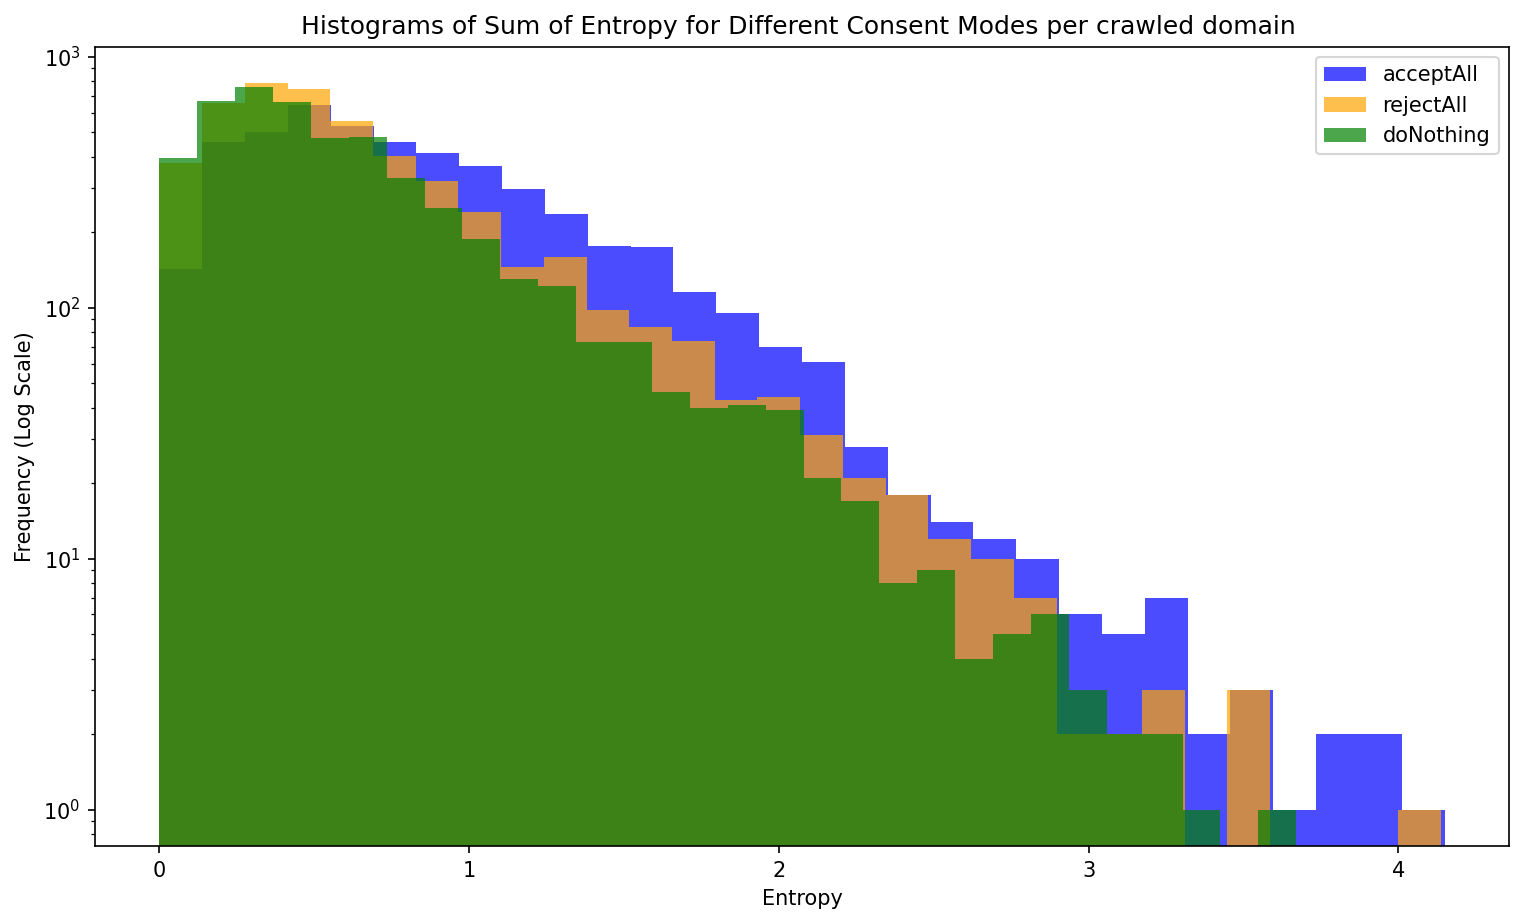

In [64]:
import matplotlib.pyplot as plt

# Assuming you have the domainActivitySum DataFrame
# If not, make sure to have it ready with the appropriate data

# Define the consent modes
consent_modes = ['entropy_AcceptALL', 'entropy_RejectALL', 'entropy_Donothing']
colors = ['blue', 'orange', 'green']
labels = ['acceptAll', 'rejectAll', 'doNothing']

# Create a single plot for all histograms
plt.figure(figsize=(10, 6))

# Plot histograms for each consent mode in the specified order
for i, mode in enumerate(consent_modes):
    plt.hist(domainActivitySum[mode], bins=30, alpha=0.7, color=colors[i], label=labels[i], log=True)

# Set the title and labels
plt.xlabel('Entropy')
plt.ylabel('Frequency (Log Scale)')
plt.title('Histograms of Sum of Entropy for Different Consent Modes per crawled domain ')
plt.legend()

# Display the plot
plt.show()



findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family '

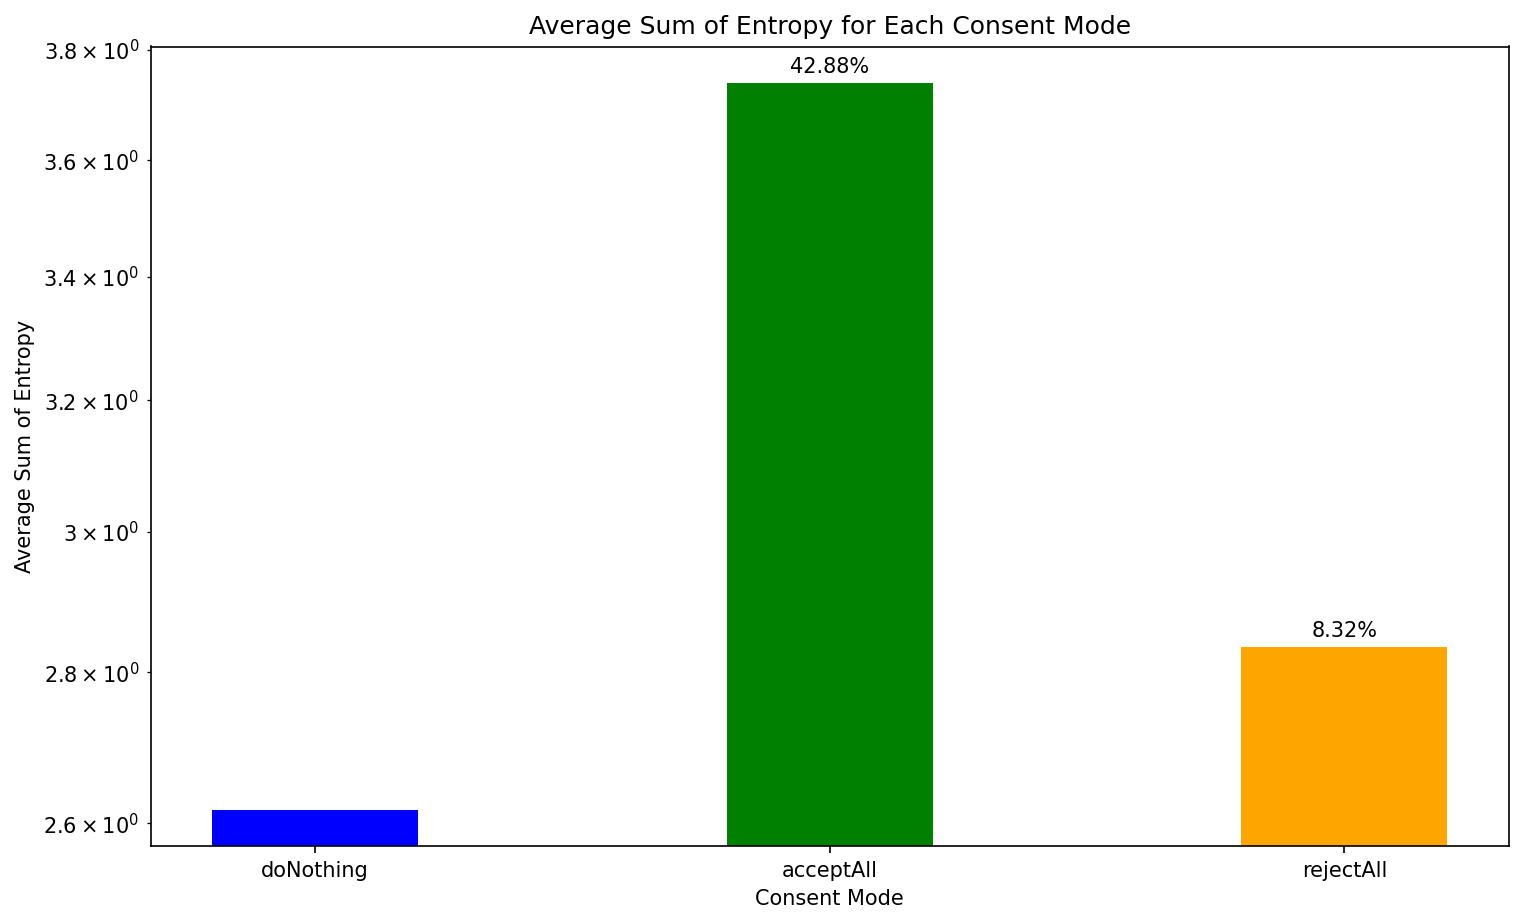

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the domainActivitySum DataFrame
# If not, make sure to have it ready with the appropriate data

# Calculate the average sum of entropy for each consent mode
average_entropy_sum = domainActivitySum[['entropy_Donothing', 'entropy_AcceptALL', 'entropy_RejectALL']].mean()

# Calculate the increase rate for accept all and reject all compared to do nothing
increase_rate_accept_all = (average_entropy_sum['entropy_AcceptALL'] - average_entropy_sum['entropy_Donothing']) / average_entropy_sum['entropy_Donothing'] * 100
increase_rate_reject_all = (average_entropy_sum['entropy_RejectALL'] - average_entropy_sum['entropy_Donothing']) / average_entropy_sum['entropy_Donothing'] * 100

# Create a bar plot to visualize the average sum of entropy for each mode
plt.figure(figsize=(10, 6))
width = 0.4
x = ['doNothing', 'acceptAll', 'rejectAll']
y = [average_entropy_sum['entropy_Donothing'], average_entropy_sum['entropy_AcceptALL'], average_entropy_sum['entropy_RejectALL']]
bars = plt.bar(x, y, width, color=['blue', 'green', 'orange'])
plt.xlabel('Consent Mode')
plt.ylabel('Average Sum of Entropy')
plt.title('Average Sum of Entropy for Each Consent Mode')
plt.yscale('log')  # Use logarithmic scale for the y-axis
plt.grid(axis='y')

# Add labels on top of the bars to indicate the increase rate
for bar, rate in zip(bars[1:], [increase_rate_accept_all, increase_rate_reject_all]):
    height = bar.get_height()
    plt.annotate(f'{rate:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

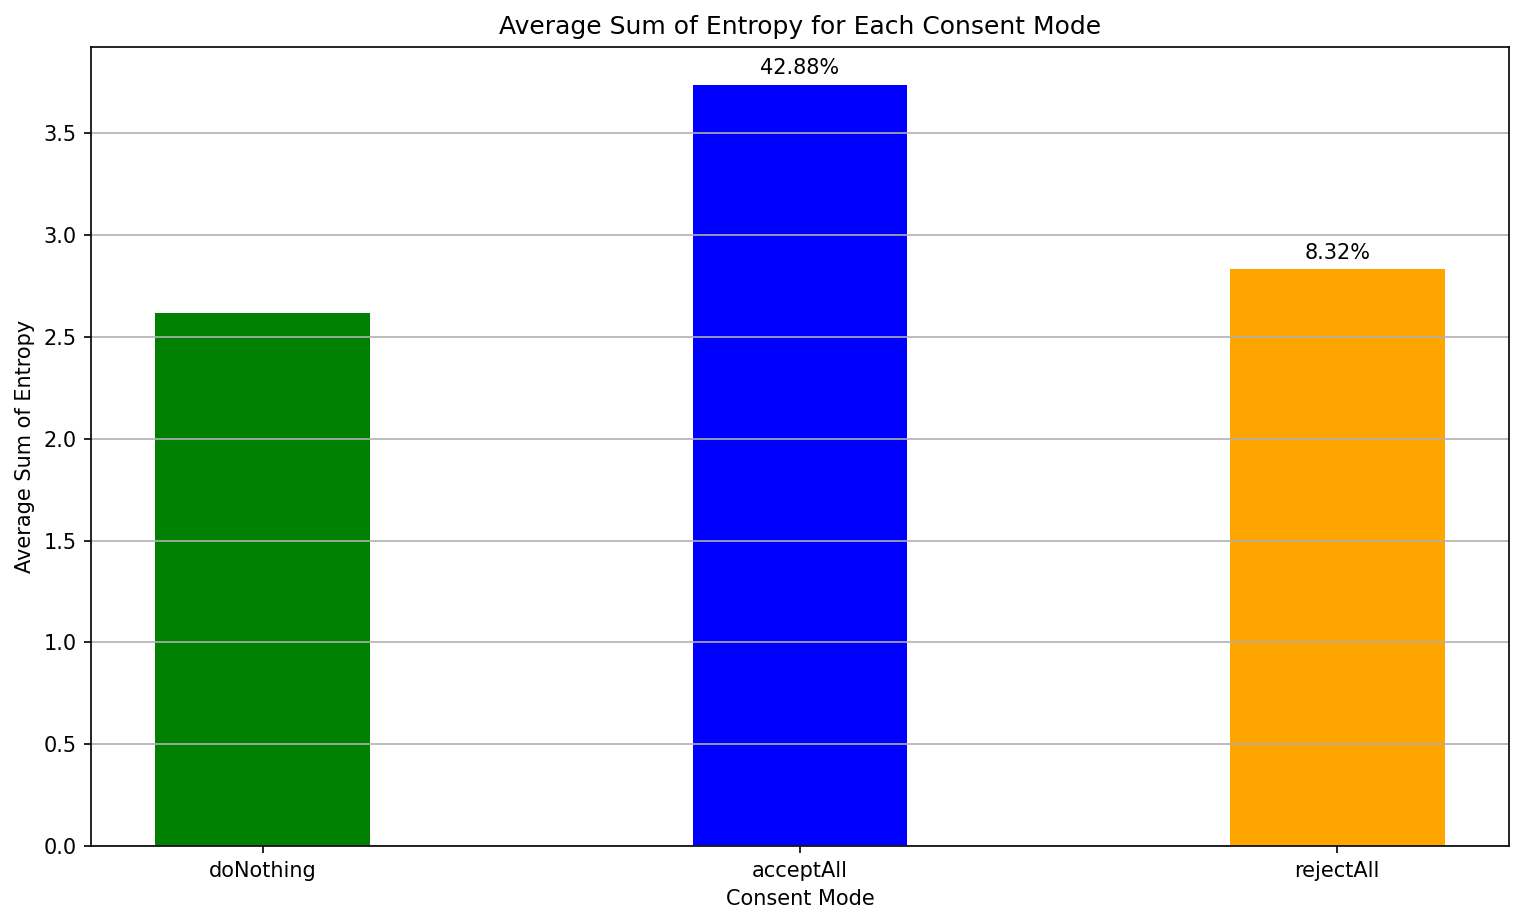

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the domainActivitySum DataFrame
# If not, make sure to have it ready with the appropriate data

# Calculate the average sum of entropy for each consent mode
average_entropy_sum = domainActivitySum[['entropy_Donothing', 'entropy_AcceptALL', 'entropy_RejectALL']].mean()

# Calculate the increase rate for accept all and reject all compared to do nothing
increase_rate_accept_all = (average_entropy_sum['entropy_AcceptALL'] - average_entropy_sum['entropy_Donothing']) / average_entropy_sum['entropy_Donothing'] * 100
increase_rate_reject_all = (average_entropy_sum['entropy_RejectALL'] - average_entropy_sum['entropy_Donothing']) / average_entropy_sum['entropy_Donothing'] * 100

# Create a bar plot to visualize the average sum of entropy for each mode
plt.figure(figsize=(10, 6))
width = 0.4
x = ['doNothing', 'acceptAll', 'rejectAll']
y = [average_entropy_sum['entropy_Donothing'], average_entropy_sum['entropy_AcceptALL'], average_entropy_sum['entropy_RejectALL']]
bars = plt.bar(x, y, width, color=['green','blue', 'orange'])
plt.xlabel('Consent Mode')
plt.ylabel('Average Sum of Entropy')
plt.title('Average Sum of Entropy for Each Consent Mode')
plt.grid(axis='y')

# Add labels on top of the bars to indicate the increase rate
for bar, rate in zip(bars[1:], [increase_rate_accept_all, increase_rate_reject_all]):
    height = bar.get_height()
    plt.annotate(f'{rate:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()


In [37]:
average_entropy_sum

entropy_Donothing    2.617227
entropy_AcceptALL    3.739395
entropy_RejectALL    2.834987
dtype: float64

In [33]:
# Create separate DataFrames for each profile
donothing_df = attribute_combinations[attribute_combinations['consentMode'] == 'doNothing']
acceptall_df = attribute_combinations[attribute_combinations['consentMode'] == 'acceptAll']
rejectall_df = attribute_combinations[attribute_combinations['consentMode'] == 'rejectAll']

# Calculate the sum of entropy for each profile per domain using pivot_table
donothing_entropy_sum = donothing_df.pivot_table(index='domain', values='entropy', aggfunc='sum', fill_value=0)
acceptall_entropy_sum = acceptall_df.pivot_table(index='domain', values='entropy', aggfunc='sum', fill_value=0)
rejectall_entropy_sum = rejectall_df.pivot_table(index='domain', values='entropy', aggfunc='sum', fill_value=0)

# Merge the three DataFrames into the domainActivity DataFrame
domainActivitySum = donothing_entropy_sum.merge(acceptall_entropy_sum, on='domain', suffixes=('_Donothing', '_AcceptALL'))
domainActivitySum = domainActivitySum.merge(rejectall_entropy_sum, on='domain', suffixes=(None, '_RejectALL'))

# Rename the columns
domainActivitySum = domainActivitySum.rename(columns={'entropy': 'entropy_RejectALL'})

# Reset the index
domainActivitySum.reset_index(inplace=True)

# Display the domainActivity DataFrame
print(domainActivitySum)


              domain  entropy_Donothing  entropy_AcceptALL  entropy_RejectALL
0          01net.com           0.796308           7.853638           1.407817
1     1001juegos.com           0.571829           2.162292           2.162292
2            1177.se           1.334051           1.334051           1.334051
3          11880.com           3.054443           3.594809           3.054443
4      123helpme.com           2.676442           2.676442           2.676442
...              ...                ...                ...                ...
4841    zycrypto.com           8.097190           8.669018           7.267981
4842       zynga.com           1.925375           2.489909           1.925375
4843  zyngapoker.com           1.176043           4.230485           1.176043
4844       zyxel.com           2.931590           2.931590           2.931590
4845     zzounds.com           1.558531           1.558531           1.558531

[4846 rows x 4 columns]


In [147]:
# Filter the domains with any of the entropy values equal to 0
domains_with_zero_entropy = domainActivity[
    (domainActivity['entropy_Donothing'] == 0) ]

# Print the resulting DataFrame
print(domains_with_zero_entropy)


                        domain  entropy_Donothing  entropy_AcceptALL  \
423           bbvaopenmind.com                0.0           0.000000   
1082           demandmedia.com                0.0           0.082395   
1288               em-lyon.com                0.0           0.025570   
1507                foreca.com                0.0           0.081876   
1945             greentube.com                0.0           0.081876   
2017              helvetia.com                0.0           0.066040   
2028              hersheys.com                0.0           0.118621   
2444          kotobukiya.co.jp                0.0           0.098468   
3265          peoplestrong.com                0.0           0.000000   
3628               rossmann.de                0.0           0.110361   
3781              seyfarth.com                0.0           0.081876   
3802               signify.com                0.0           0.000000   
4323  transportenvironment.org                0.0           0.07

In [148]:
# Assuming you have the 'flowreport' DataFrame with the 'domain' column
unique_domains = flowReport['domain'].nunique()

print(f"Number of unique domains in flowreport: {unique_domains}")


Number of unique domains in flowreport: 4856


In [19]:
# Calculate the average of each column
avg_entropy_donothing = domainActivity['entropy_Donothing'].mean()
avg_entropy_acceptall = domainActivity['entropy_AcceptALL'].mean()
avg_entropy_rejectall = domainActivity['entropy_RejectALL'].mean()

# Print the average of each column
print("Average Entropy for doNothing:", avg_entropy_donothing)
print("Average Entropy for acceptAll:", avg_entropy_acceptall)
print("Average Entropy for rejectAll:", avg_entropy_rejectall)


Average Entropy for doNothing: 0.6477764982724608
Average Entropy for acceptAll: 0.6493068161094763
Average Entropy for rejectAll: 0.6482066111468909


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

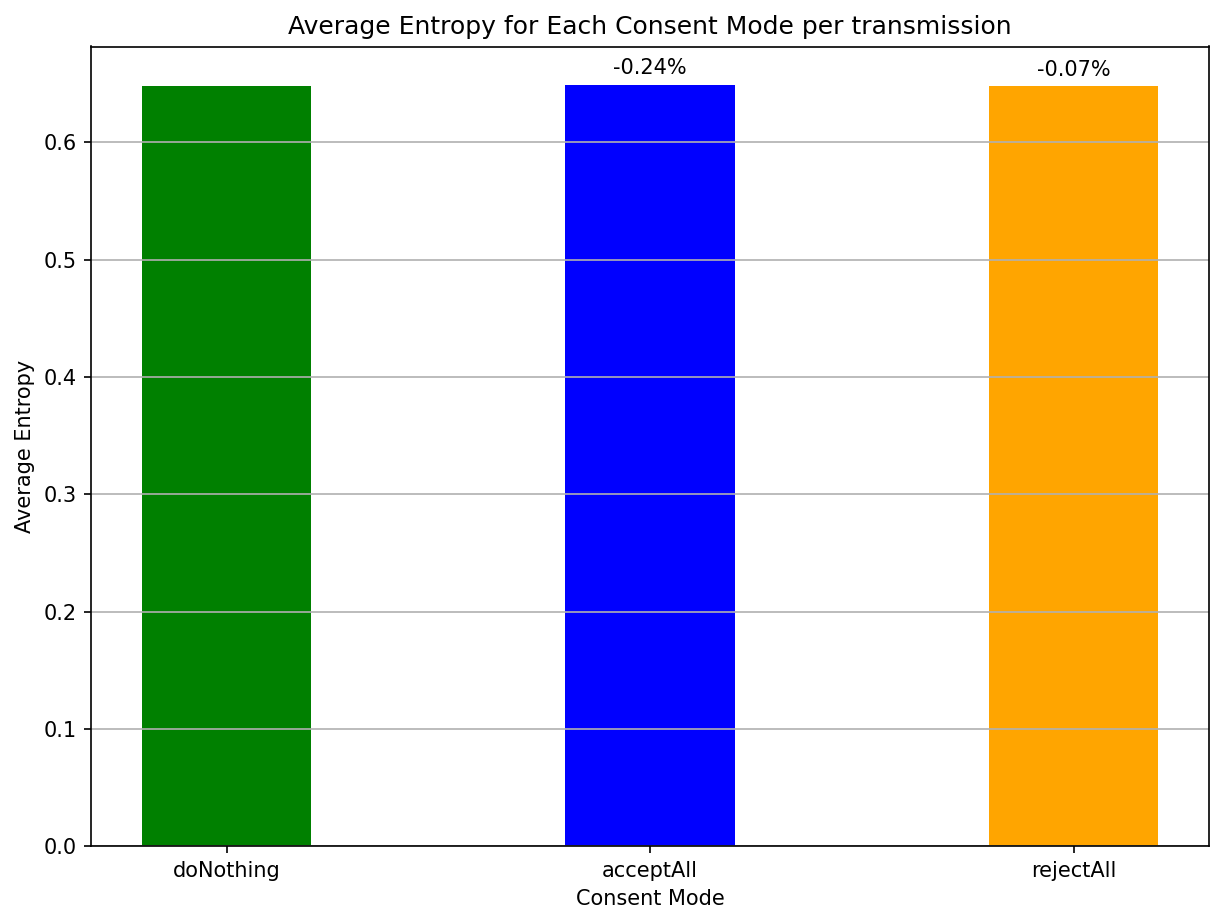

In [20]:


# Assuming you have the domainActivity DataFrame
# If not, make sure to have it ready with the appropriate data

# Calculate the average of each column
avg_entropy_donothing = domainActivity['entropy_Donothing'].mean()
avg_entropy_acceptall = domainActivity['entropy_AcceptALL'].mean()
avg_entropy_rejectall = domainActivity['entropy_RejectALL'].mean()

# Calculate the decrease rate for accept all and reject all compared to do nothing
decrease_rate_accept_all = (avg_entropy_donothing - avg_entropy_acceptall) / avg_entropy_donothing * 100
decrease_rate_reject_all = (avg_entropy_donothing - avg_entropy_rejectall) / avg_entropy_donothing * 100

# Create a bar plot to visualize the average entropy values for each mode
plt.figure(figsize=(8, 6))
width = 0.4
x = ['doNothing', 'acceptAll', 'rejectAll']
y = [avg_entropy_donothing, avg_entropy_acceptall, avg_entropy_rejectall]
bars = plt.bar(x, y, width, color=['green', 'blue',  'orange'])
plt.xlabel('Consent Mode')
plt.ylabel('Average Entropy')
plt.title('Average Entropy for Each Consent Mode per transmission')
plt.grid(axis='y')

# Add labels on top of the bars to indicate the decrease rate
for bar, rate in zip(bars[1:], [decrease_rate_accept_all, decrease_rate_reject_all]):
    height = bar.get_height()
    plt.annotate(f'-{abs(rate):.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                 textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

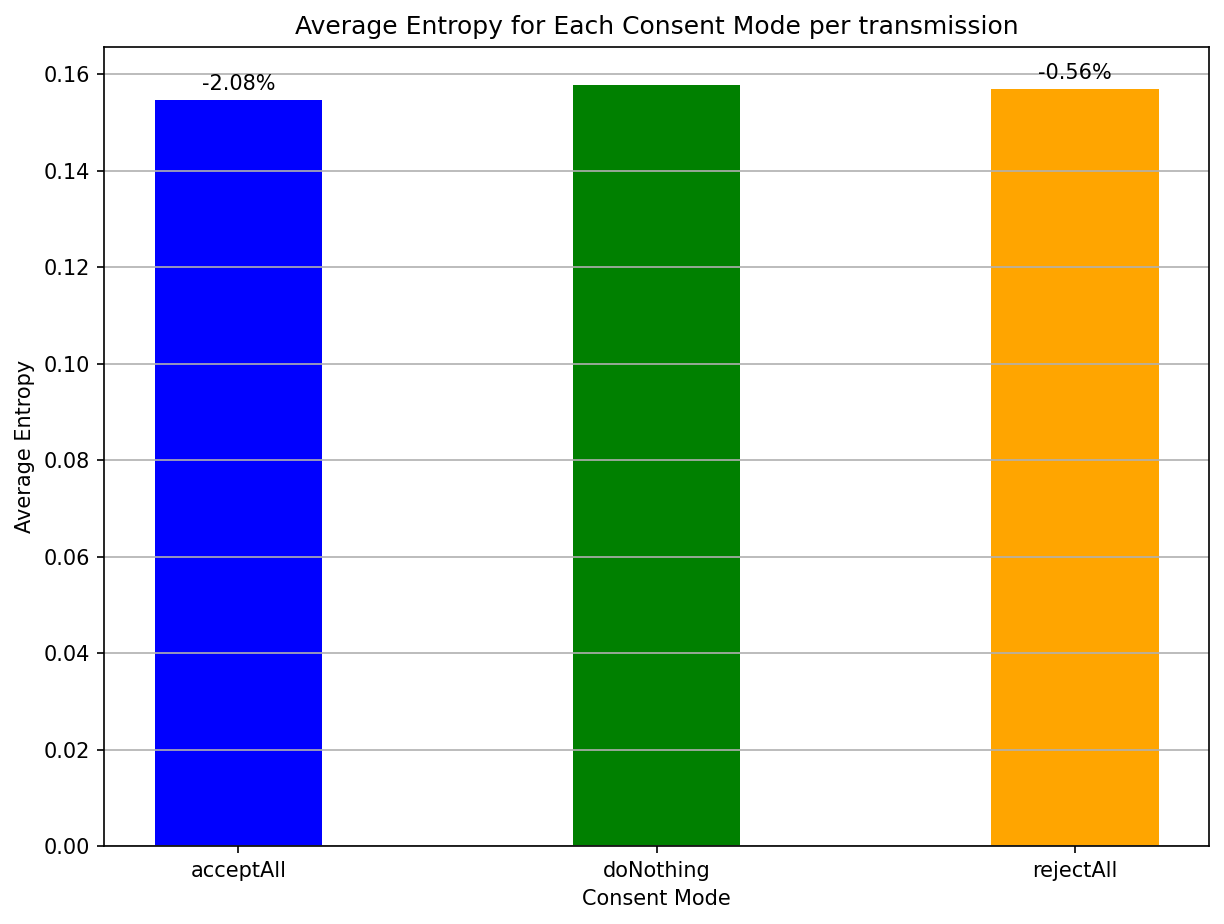

In [87]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have the domainActivity DataFrame
# If not, make sure to have it ready with the appropriate data

# Calculate the average of each column
avg_entropy_donothing = domainActivity['entropy_Donothing'].mean()
avg_entropy_acceptall = domainActivity['entropy_AcceptALL'].mean()
avg_entropy_rejectall = domainActivity['entropy_RejectALL'].mean()

# Calculate the decrease rate for accept all and reject all compared to do nothing
decrease_rate_accept_all = (avg_entropy_donothing - avg_entropy_acceptall) / avg_entropy_donothing * 100
decrease_rate_reject_all = (avg_entropy_donothing - avg_entropy_rejectall) / avg_entropy_donothing * 100

# Create a bar plot to visualize the average entropy values for each mode
plt.figure(figsize=(8, 6))
width = 0.4
x = ['acceptAll', 'doNothing', 'rejectAll']  # Reversed order of the first two bins
y = [avg_entropy_acceptall, avg_entropy_donothing, avg_entropy_rejectall]  # Reversed order of the values
bars = plt.bar(x, y, width, color=['blue', 'green', 'orange'])  # Adjusted colors
plt.xlabel('Consent Mode')
plt.ylabel('Average Entropy')
plt.title('Average Entropy for Each Consent Mode per transmission')
plt.grid(axis='y')

# Add labels on top of the bars to indicate the decrease rate
for bar, rate in zip(bars, [decrease_rate_accept_all, 0, decrease_rate_reject_all]):  # Adjusted the rates for the reversed order
    height = bar.get_height()
    if rate != 0:  # Skip the label for the 'doNothing' mode
        plt.annotate(f'-{abs(rate):.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),
                     textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()


In [25]:
ranges=[(0.0, 0.154098186), (0.154098186, 0.442675059), (0.442675059, 0.596961491), (0.596961491, 0.705353706), (0.705353706, 0.832438884), (0.832438884, 0.988612233)]


# Define the ranges and corresponding levels

levels = ['Negligible1','Negligible2', 'Low', 'Medium', 'High', 'very high']

# Extract bin edges from ranges
bins = [r[0] for r in ranges] + [ranges[-1][1]]

# Categorize the entropy values
attribute_combinations['entropy_level'] = pd.cut(attribute_combinations['entropy'], bins=bins, labels=levels, right=False)

# Print the updated DataFrame with the new entropy levels
attribute_combinations

domain consentMode       destinationHost  \
0        01net.com   acceptAll             01net.com   
1        01net.com   acceptAll            criteo.com   
2        01net.com   acceptAll       doubleclick.net   
3        01net.com   acceptAll  google-analytics.com   
4        01net.com   acceptAll            google.com   
...            ...         ...                   ...   
72382  zzounds.com   acceptAll           zzounds.com   
72383  zzounds.com   doNothing  google-analytics.com   
72384  zzounds.com   doNothing           zzounds.com   
72385  zzounds.com   rejectAll  google-analytics.com   
72386  zzounds.com   rejectAll           zzounds.com   

                                  attribute_combinations   entropy   proba  \
0                                    navigator.useragent  0.564534   4.20%   
1        navigator.language, screen.width, screen.height  0.651570   4.50%   
2       navigator.useragent, screen.width, screen.height  0.762223  12.00%   
3      navigator.language, screen.width, screen.heigh...  0.796308  18.80%   
4        navigator.language, screen.width, screen.height  0.651570   4.50%   
...                                                  ...       ...     ...   
72382   screen.width, screen.height, navigator.useragent  0.762223  12.00%   
72383  navigator.language, screen.colordepth, screen....  0.796308  18.80%   
72384   screen.width, screen.height, navigator.useragent  0.762223  12.00%   
72385  navigator.language, screen.colordepth, screen....  0.796308  18.80%   
72386   screen.width, screen.height, navigator.useragent  0.762223  12.00%   

      entropy_level  
0               Low  
1            Medium  
2              High  
3              High  
4            Medium  
...             ...  
72382          High  
72383          High  
72384          High  
72385          High  
72386          High  

[72387 rows x 7 columns]

In [13]:
attribute_combinations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72387 entries, 0 to 72386
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   domain                  72387 non-null  object  
 1   consentMode             72387 non-null  object  
 2   destinationHost         72387 non-null  object  
 3   attribute_combinations  72387 non-null  object  
 4   entropy                 72387 non-null  float64 
 5   proba                   72387 non-null  object  
 6   entropy_level           72387 non-null  category
dtypes: category(1), float64(1), object(5)
memory usage: 3.4+ MB


In [26]:
result = attribute_combinations.groupby(['consentMode', 'entropy_level'])['domain'].nunique().reset_index()
result



consentMode entropy_level  domain
0    acceptAll   Negligible1     238
1    acceptAll   Negligible2     507
2    acceptAll           Low    4911
3    acceptAll        Medium    2203
4    acceptAll          High    4560
5    acceptAll     very high     579
6    doNothing   Negligible1     220
7    doNothing   Negligible2     406
8    doNothing           Low    3900
9    doNothing        Medium    1484
10   doNothing          High    3460
11   doNothing     very high     522
12   rejectAll   Negligible1     228
13   rejectAll   Negligible2     462
14   rejectAll           Low    4152
15   rejectAll        Medium    1618
16   rejectAll          High    3619
17   rejectAll     very high     527

In [43]:
import pandas as pd

# Assuming 'attribute_combinations' DataFrame with 'domain', 'entropy', 'fingerprinter', and 'consentmode' columns
total_domains =  5464 # Total number of domains

# Define the specified entropy level ranges
entropy_ranges = [0.0, 0.442675059, 0.596961491, 0.705353706, 0.832438884, 0.988612233]

# Levels for different entropy ranges
levels = ['Negligible', 'Low', 'Medium', 'High', 'Very high']

# Consent modes
consent_modes = ['doNothing', 'acceptAll', 'rejectAll']

# Create a dictionary to store prevalence rates for each consent mode
prevalence_rates_by_mode = {}

# Iterate over consent modes
for mode in consent_modes:
    entropy_counts = []
    # Count of domains falling into each entropy level range for a specific consent mode
    for i in range(len(entropy_ranges) - 1):
        lower_bound = entropy_ranges[i]
        upper_bound = entropy_ranges[i + 1]
        count = attribute_combinations[
            (attribute_combinations['entropy'] > lower_bound) &
            (attribute_combinations['entropy'] <= upper_bound) &
            (attribute_combinations['consentMode'] == mode)
        ]['domain'].nunique()
        entropy_counts.append(count)
    
    # Calculate prevalence rates for each entropy level for the current consent mode
    prevalence_rates = [(count / total_domains) * 100 for count in entropy_counts]
    # Store prevalence rates in the dictionary
    prevalence_rates_by_mode[mode] = prevalence_rates

# Print prevalence rates for each level and consent mode
for mode, rates in prevalence_rates_by_mode.items():
    print(f"Prevalence Rates for {mode} consent mode:")
    for i in range(len(levels)):
        print(f"    Prevalence Rate of domains with {levels[i]} fingerprinting: {rates[i]:.2f}%")
    print("-------------------------")


Prevalence Rates for doNothing consent mode:
    Prevalence Rate of domains with Negligible fingerprinting: 7.80%
    Prevalence Rate of domains with Low fingerprinting: 71.38%
    Prevalence Rate of domains with Medium fingerprinting: 27.16%
    Prevalence Rate of domains with High fingerprinting: 63.32%
    Prevalence Rate of domains with Very high fingerprinting: 9.55%
-------------------------
Prevalence Rates for acceptAll consent mode:
    Prevalence Rate of domains with Negligible fingerprinting: 9.68%
    Prevalence Rate of domains with Low fingerprinting: 89.88%
    Prevalence Rate of domains with Medium fingerprinting: 40.34%
    Prevalence Rate of domains with High fingerprinting: 83.46%
    Prevalence Rate of domains with Very high fingerprinting: 10.60%
-------------------------
Prevalence Rates for rejectAll consent mode:
    Prevalence Rate of domains with Negligible fingerprinting: 8.80%
    Prevalence Rate of domains with Low fingerprinting: 75.99%
    Prevalence Rate 

In [42]:
# Count the number of unique domains in attribute_combinations DataFrame
unique_domains_count = attribute_combinations['domain'].nunique()
print(f"Number of unique domains: {unique_domains_count}")

Number of unique domains: 5464


TypeError: can only concatenate str (not "float") to str

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

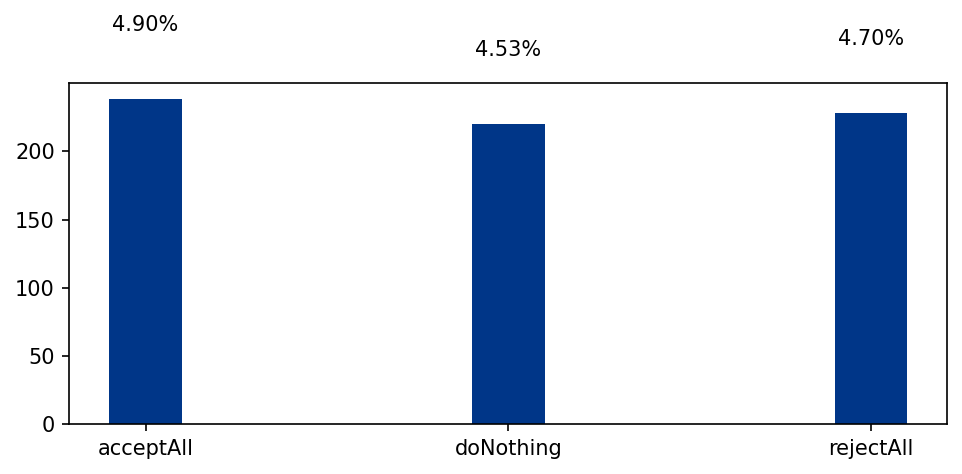

In [32]:
# Define bar width and positions
bar_width = 0.2  # Adjust this value to control the gap between bars
consent_modes = result['consentMode'].unique()


# Create a grouped bar chart for each entropy level
for entropy_level in result['entropy_level'].unique():
    subset = result[result['entropy_level'] == entropy_level]
    counts = subset['domain']
    
  
    plt.bar(x, counts, width=bar_width, label=entropy_level)
    
    # Annotate counts on top of bars
    for i, count in enumerate(counts):
        plt.text(x[i], count + 50, f'{(count/4856)*100:.2f}%', ha='center')


    x = x + bar_width  # Move to the next group of bars

# Set x-axis labels and ticks
plt.xticks(np.arange(len(consent_modes)) + (bar_width / 2), consent_modes)
plt.title(' Prevalence of fingerprinting activity level per consent mode')
plt.xlabel('Consent Mode')
plt.ylabel('Crawled Domains')

# Place the legend outside the box to the right
plt.legend(title='Entropy Level', loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks(rotation=45)
plt.show()


In [14]:
domainActivity

domain  entropy_Donothing  entropy_AcceptALL  entropy_RejectALL
0          01net.com           0.225225           0.167036           0.151736
1     1001juegos.com           0.146248           0.198412           0.198412
2            1177.se           0.171818           0.171818           0.171818
3          11880.com           0.085957           0.087304           0.085957
4      123helpme.com           0.216473           0.216473           0.216473
...              ...                ...                ...                ...
4841    zycrypto.com           0.214970           0.209683           0.200603
4842       zynga.com           0.109168           0.094661           0.109168
4843  zyngapoker.com           0.064693           0.079882           0.064693
4844       zyxel.com           0.132648           0.132648           0.132648
4845     zzounds.com           0.211307           0.211307           0.211307

[4846 rows x 4 columns]

In [29]:
# Group the attribute_combinations DataFrame by 'domain' and 'consentMode', and then count the number of unique 'destinationHost'
unique_dest_hosts_per_domain = attribute_combinations.groupby(['domain', 'consentMode'])['destinationHost'].nunique()

# Print the number of unique destination hosts per domain per consent mode
print(unique_dest_hosts_per_domain)
# Group the attribute_combinations DataFrame by 'domain' and 'consentMode', and then calculate the number of unique 'destinationHost'
unique_dest_hosts_per_domain = attribute_combinations.groupby(['domain', 'consentMode'])['destinationHost'].nunique()

# Group the unique_dest_hosts_per_domain Series by 'consentMode', and then calculate the average for each consent mode
average_unique_dest_per_consent_mode = unique_dest_hosts_per_domain.groupby('consentMode').mean()

# Print the result
print(average_unique_dest_per_consent_mode)


domain          consentMode
01net.com       acceptAll      12
                doNothing       1
                rejectAll       2
1001juegos.com  acceptAll       3
                doNothing       1
                               ..
zyxel.com       doNothing       5
                rejectAll       5
zzounds.com     acceptAll       2
                doNothing       2
                rejectAll       2
Name: destinationHost, Length: 15306, dtype: int64
consentMode
acceptAll    5.665197
doNothing    4.057225
rejectAll    4.363382
Name: destinationHost, dtype: float64


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

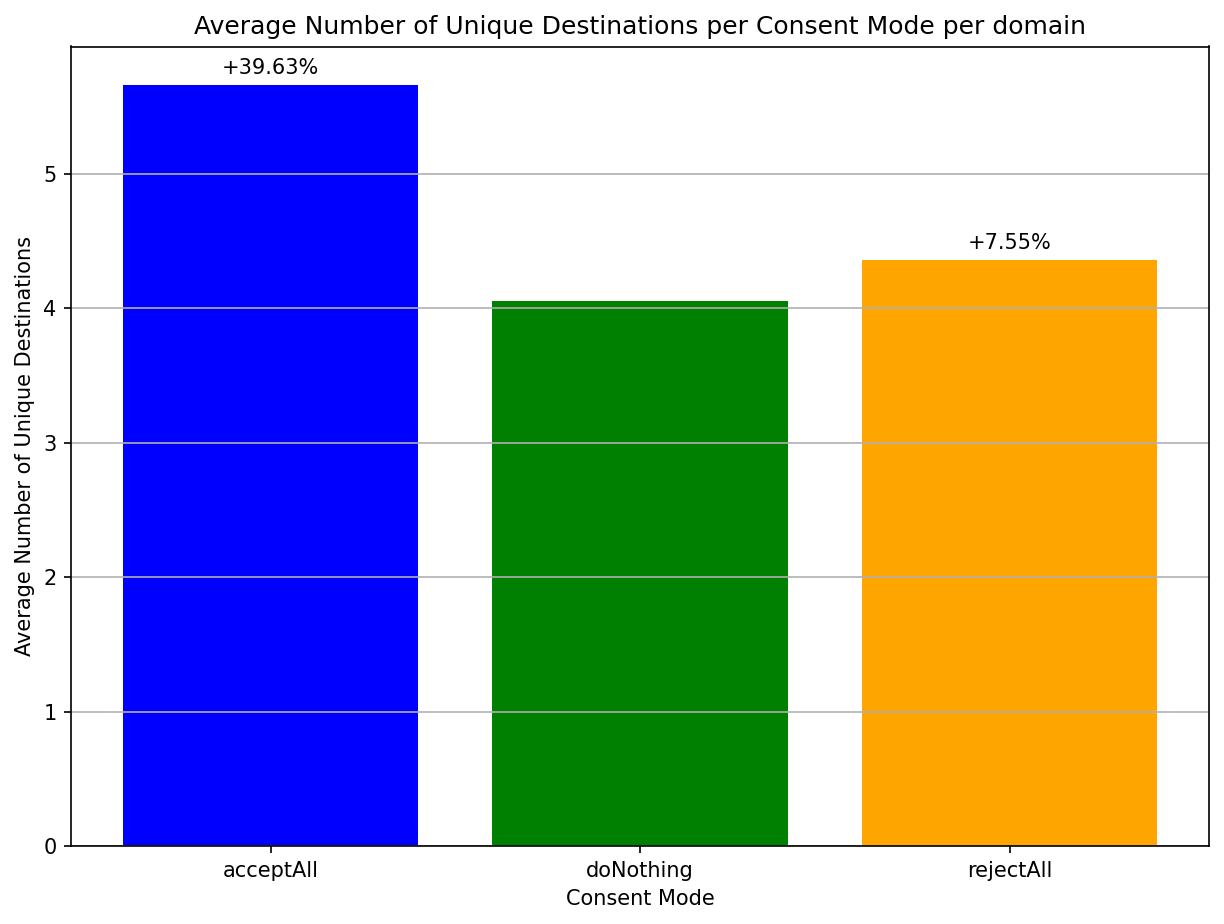

In [30]:

# Assuming you have the unique_dest_hosts_per_domain and average_unique_dest_per_consent_mode data ready
# If not, make sure to have them prepared with the appropriate data

# Create a bar plot to visualize the average number of unique destinations per consent mode
plt.figure(figsize=(8, 6))
x = average_unique_dest_per_consent_mode.index
y = average_unique_dest_per_consent_mode.values
bars = plt.bar(x, y, color=['blue', 'green', 'orange'])
plt.xlabel('Consent Mode')
plt.ylabel('Average Number of Unique Destinations')
plt.title('Average Number of Unique Destinations per Consent Mode per domain')
plt.grid(axis='y')

# Calculate the increase rate for accept all and reject all compared to do nothing
increase_rate_accept_all = (y[0] - y[1]) / y[1] * 100
increase_rate_reject_all = (y[2] - y[1]) / y[1] * 100



plt.annotate(f'+{abs(increase_rate_accept_all):.2f}%', xy=(bars[0].get_x() + bars[0].get_width() / 2, bars[0].get_height()),
            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.annotate(f'+{abs(increase_rate_reject_all):.2f}%', xy=(bars[2].get_x() + bars[0].get_width() / 2, bars[2].get_height()),
            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

plt.show()



findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
/tmp/ipykernel_3236736/459492522.py:35: UserWarning: T

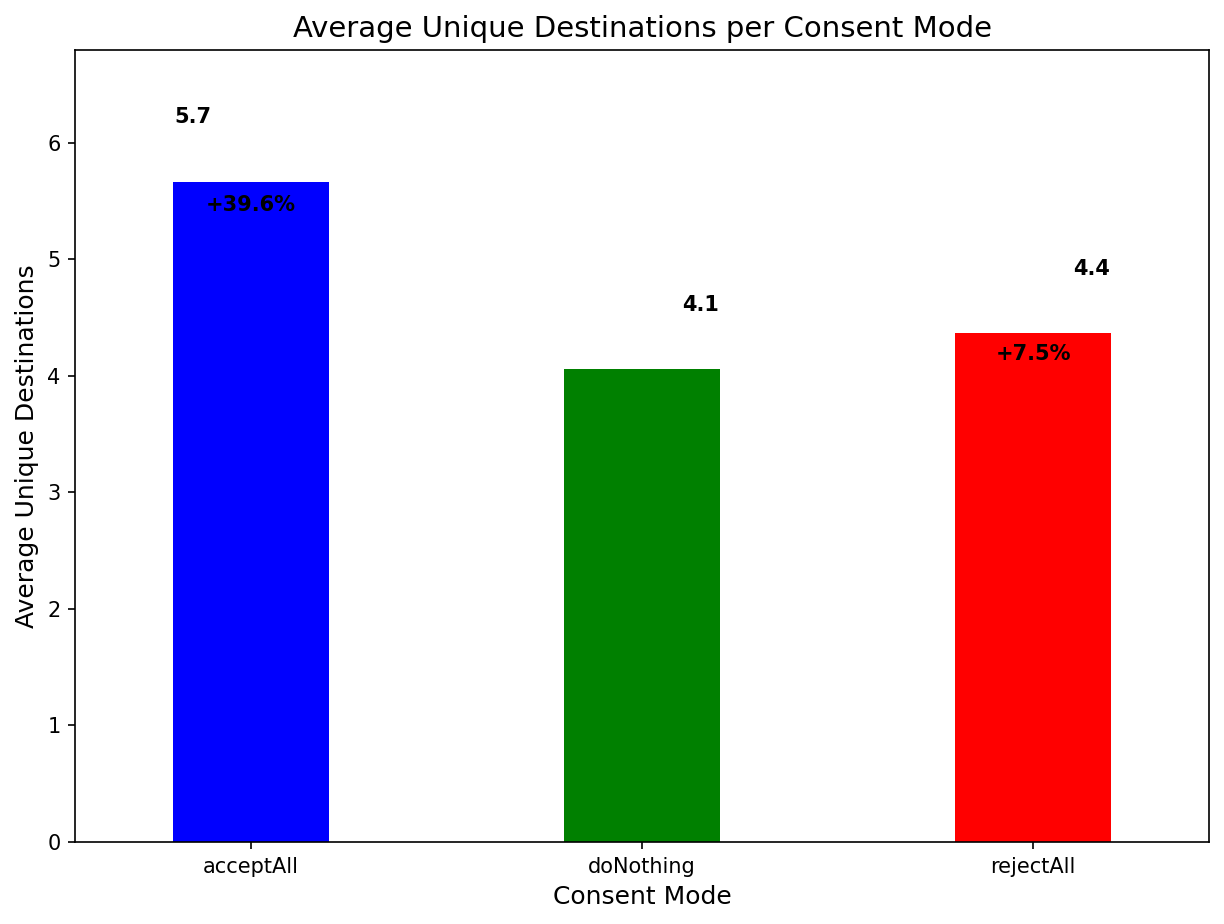

In [31]:
import matplotlib.pyplot as plt

# Group the attribute_combinations DataFrame by 'domain' and 'consentMode', and then calculate the number of unique 'destinationHost'
unique_dest_hosts_per_domain = attribute_combinations.groupby(['domain', 'consentMode'])['destinationHost'].nunique()

# Group the unique_dest_hosts_per_domain Series by 'consentMode', and then calculate the average for each consent mode
average_unique_dest_per_consent_mode = unique_dest_hosts_per_domain.groupby('consentMode').mean()

# Calculate the percentage increase between 'doNothing' and 'acceptAll'
percentage_increase_accept_all = (average_unique_dest_per_consent_mode['acceptAll'] - average_unique_dest_per_consent_mode['doNothing']) / average_unique_dest_per_consent_mode['doNothing'] * 100

# Calculate the percentage increase between 'doNothing' and 'rejectAll'
percentage_increase_reject_all = (average_unique_dest_per_consent_mode['rejectAll'] - average_unique_dest_per_consent_mode['doNothing']) / average_unique_dest_per_consent_mode['doNothing'] * 100

# Create a bar plot to visualize the average unique destination numbers for each consent mode
plt.figure(figsize=(8, 6))
ax = average_unique_dest_per_consent_mode.plot(kind='bar', color=['blue', 'green', 'red'], width=0.4)
plt.xlabel('Consent Mode', fontsize=12)
plt.ylabel('Average Unique Destinations', fontsize=12)
plt.title('Average Unique Destinations per Consent Mode', fontsize=14)
plt.xticks(rotation=0)

# Add text labels for the average values above each bar
for i, value in enumerate(average_unique_dest_per_consent_mode):
    x_offset = -0.15 if i == 0 else 0.15
    plt.text(i + x_offset, value + 0.5, f'{value:.1f}', ha='center', color='black', fontsize=10, fontweight='bold')

# Add text labels for the percentage increases above each pair of bars
plt.text(0, average_unique_dest_per_consent_mode['acceptAll'] -0.25, "+"+f'{percentage_increase_accept_all:.1f}%', ha='center', color='black', fontsize=10, fontweight='bold')
plt.text(2, average_unique_dest_per_consent_mode['rejectAll'] -0.23, "+"+f'{percentage_increase_reject_all:.1f}%', ha='center', color='black', fontsize=10, fontweight='bold')

plt.ylim(0, max(average_unique_dest_per_consent_mode) * 1.2)

# Show the plot
plt.tight_layout()
plt.show()



## Exclude some CMPs


In [50]:
excludedCMPs = ['google', 'cookiebot']
print(
    f'Excluding the following CMPs because of findings from Consent-O-Matic validation: {excludedCMPs}')

print()
before = statusReport[~(statusReport.hasErrors)].shape[0]
print(f'Successful domains before excluding CMPs: {before}')
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'hasErrors'] = True
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'error'] = 'excluded CMP'
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'status'] = 'excluded CMP'
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'statusSimplified'] = 'excluded CMP'
after = statusReport[~(statusReport.hasErrors)].shape[0]
print(f'Successful domains after  excluding CMPs: {after}')
print(f'Difference: {before-after}')


print()
before = flowReport.shape[0]
print(f'Flows before excluding CMPs: {before}')
flowReport = flowReport[~(flowReport.domain.isin(
    statusReport.loc[statusReport.cmp_simplified.isin(excludedCMPs), 'domain']))]
after = flowReport.shape[0]
print(f'Flows after  excluding CMPs: {after}')
print(f'Difference: {before-after}')

statusReport.error.value_counts()

Excluding the following CMPs because of findings from Consent-O-Matic validation: ['google', 'cookiebot']



NameError: name 'statusReport' is not defined

In [62]:
excludedCMPs = ['google', 'cookiebot']
print(
    f'Excluding the following CMPs because of findings from Consent-O-Matic validation: {excludedCMPs}')
print()
print()
before = statusReport[~(statusReport.hasErrors)].shape[0]
print(f'Successful domains before excluding CMPs: {before}')
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'hasErrors'] = True
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'error'] = 'excluded CMP'
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'status'] = 'excluded CMP'
statusReport.loc[statusReport.cmp_simplified.isin(
    excludedCMPs), 'statusSimplified'] = 'excluded CMP'
after = statusReport[~(statusReport.hasErrors)].shape[0]
print(f'Successful domains after  excluding CMPs: {after}')
print(f'Difference: {before-after}')


before = attribute_combinations.shape[0]
print(f'Flows before excluding CMPs: {before}')
attribute_combinations = attribute_combinations[~(attribute_combinations.domain.isin(
    statusReport.loc[statusReport.cmp_simplified.isin(excludedCMPs), 'domain']))]
after = attribute_combinations.shape[0]
print(f'Flows after  excluding CMPs: {after}')
print(f'Difference: {before-after}')

statusReport.error.value_counts()

Excluding the following CMPs because of findings from Consent-O-Matic validation: ['google', 'cookiebot']


Successful domains before excluding CMPs: 5818
Successful domains after  excluding CMPs: 4856
Difference: 962
Flows before excluding CMPs: 63594
Flows after  excluding CMPs: 63594
Difference: 0


Successful           4856
no CMP               3963
excluded CMP          962
timeout error         827
unspecified error     679
unreachable           617
argtype error          29
domain skipped         24
Name: error, dtype: int64

### Some calculations need to be done after exclusion

In [19]:
statusReport['tld_othered'] = None
statusReport.loc[~(statusReport.hasErrors),'tld_othered'] = otherSeries(statusReport.loc[~(statusReport.hasErrors),'tld'], 11)


### Final Look into Wrongly Tagged

In [20]:
statusReport.pivot_table(values='domain',index='error',columns='wronglyTagged',aggfunc='count',margins=True)

wronglyTagged             False    True    All
error                                         
Successful               4707.0   149.0   4856
argtype error              26.0     NaN     26
domain skipped             21.0     NaN     21
excluded CMP              956.0     6.0    962
no CMP                   1802.0     NaN   1802
scanned unintentionally     NaN  2555.0   2555
timeout error             788.0     NaN    788
unreachable               475.0     NaN    475
unspecified error         472.0     NaN    472
All                      9247.0  2710.0  11957

## Helper Tables and Subsets


### Joint Status


In [21]:
# jointStatus = pd.concat([filterCrawlStatus.loc[filterCrawlStatus.status != 'banner detected',['domain','status']],statusReport.loc[:,['domain','status']]]).merge(tranco)
jointStatus = pd.concat([filterCrawlStatus.loc[filterCrawlStatus.status != 'banner detected', [
                        'domain', 'status']], statusReport.loc[:, ['domain', 'error']].rename(columns={'error': 'status'})]).merge(tranco)
jointStatus.loc[jointStatus.status == 'not reached',
                'status'] = 'not reached in filter crawl'
jointStatus.loc[jointStatus.status == 'no banner detected',
                'status'] = 'no notice in filter crawl'
jointStatus.loc[jointStatus.status == 'no CMP',
                'status'] = 'no notice in fingerprinting crawl'
jointStatus['rank_group'] = pd.cut(jointStatus.pagerank, bins=rank_group_bins)
jointStatus['status_othered'] = otherSeries(
    jointStatus.status, 5, 'other error in fingerprinting crawl')
jointStatus


domain                       status  pagerank  \
0             google.com      compatible CMP detected         1   
1             google.com                 excluded CMP         1   
2       gtld-servers.net  not reached in filter crawl         2   
3         akamaiedge.net  not reached in filter crawl         6   
4           facebook.com      compatible CMP detected         4   
...                  ...                          ...       ...   
111952    chartmogul.com              no CMP detected     99997   
111953        sfmlab.com              no CMP detected    100000   
111954       shou.edu.cn              no CMP detected     99984   
111955           bart.nl              no CMP detected     99988   
111956    blogpeople.net  not reached in filter crawl     99998   

             rank_group                       status_othered  
0            (0, 10000]              compatible CMP detected  
1            (0, 10000]  other error in fingerprinting crawl  
2            (0, 10000]          not reached in filter crawl  
3            (0, 10000]          not reached in filter crawl  
4            (0, 10000]              compatible CMP detected  
...                 ...                                  ...  
111952  (90000, 100000]                      no CMP detected  
111953  (90000, 100000]                      no CMP detected  
111954  (90000, 100000]                      no CMP detected  
111955  (90000, 100000]                      no CMP detected  
111956  (90000, 100000]          not reached in filter crawl  

[111957 rows x 5 columns]

### Sample Sites for Validation of Interaction


In [22]:
successfulDomainList = statusReport.loc[~(statusReport.hasErrors), ['domain']]
validationBase = successfulDomainList.sample(
    frac=1, random_state=0).reset_index(drop=True)
validationBase.iloc[0:100, :].domain.to_csv(
    'successfulPageSample', index=False, header=False)

validationBase.iloc[0:100, :].merge(statusReport, how='left')


domain     reachedDomain                            start  \
0     draftkings.com    draftkings.com 2022-11-22 23:41:31.072000+00:00   
1         wlgore.com          gore.com 2022-12-03 02:47:06.166000+00:00   
2    santander.co.uk   santander.co.uk 2022-11-23 10:23:57.841000+00:00   
3       coredial.com      coredial.com 2022-12-02 16:12:51.132000+00:00   
4    dattobackup.com         datto.com        2022-11-25 14:24:01+00:00   
..               ...               ...                              ...   
95  nobelbiocare.com  nobelbiocare.com 2022-11-29 02:16:28.113000+00:00   
96         delijn.be         delijn.be 2022-11-29 03:38:59.978000+00:00   
97       theo2.co.uk       theo2.co.uk 2022-11-29 18:29:58.935000+00:00   
98         buffed.de         buffed.de 2022-11-27 12:42:40.372000+00:00   
99          tag24.de          tag24.de 2022-11-25 18:05:07.107000+00:00   

                                end  hasErrors       error  \
0  2022-11-22 23:52:29.805000+00:00      False  Successful   
1  2022-12-03 03:08:24.291000+00:00      False  Successful   
2  2022-11-23 10:33:56.717000+00:00      False  Successful   
3  2022-12-02 16:38:58.118000+00:00      False  Successful   
4  2022-11-25 14:54:13.277000+00:00      False  Successful   
..                              ...        ...         ...   
95 2022-11-29 02:22:18.262000+00:00      False  Successful   
96 2022-11-29 03:44:15.020000+00:00      False  Successful   
97 2022-11-29 18:43:47.152000+00:00      False  Successful   
98 2022-11-27 12:50:08.948000+00:00      False  Successful   
99 2022-11-25 18:17:14.826000+00:00      False  Successful   

                           originalFile               cmp  \
0   results.json_00000870-00000879.json       trustarcbar   
1   results.json_00010930-00010939.json   onetrust_banner   
2   results.json_00001700-00001709.json   onetrust_banner   
3   results.json_00011630-00011639.json   onetrust_banner   
4   results.json_00003570-00003579.json   onetrust_banner   
..                                  ...               ...   
95  results.json_00008030-00008039.json   onetrust_banner   
96  results.json_00008110-00008119.json   onetrust_banner   
97  results.json_00008520-00008529.json   onetrust_banner   
98  results.json_00005790-00005799.json  sourcepointpopup   
99  results.json_00003700-00003709.json  sourcepointpopup   

                                                 cmps  pagerank  \
0   [trustarcbar, trustarc_popup_hider, trustarcfr...      4353   
1                 [onetrust_banner, onetrust_pcpanel]     87919   
2                 [onetrust_banner, onetrust_pcpanel]      9427   
3                 [onetrust_banner, onetrust_pcpanel]     95079   
4                 [onetrust_banner, onetrust_pcpanel]     21930   
..                                                ...       ...   
95                  [onetrust_banner, onetrust_pctab]     58880   
96                [onetrust_banner, onetrust_pcpanel]     59493   
97                [onetrust_banner, onetrust_pcpanel]     63349   
98         [sourcepointpopup, sourcepoint_frame_2022]     39182   
99         [sourcepointpopup, sourcepoint_frame_2022]     22926   

         rank_group  wronglyTagged      status statusSimplified  \
0        (0, 10000]          False  successful       successful   
1    (80000, 90000]          False  successful       successful   
2        (0, 10000]          False  successful       successful   
3   (90000, 100000]          False  successful       successful   
4    (20000, 30000]          False  successful       successful   
..              ...            ...         ...              ...   
95   (50000, 60000]          False  successful       successful   
96   (50000, 60000]          False  successful       successful   
97   (60000, 70000]          False  successful       successful   
98   (30000, 40000]          False  successful       successful   
99   (20000, 30000]          False  successful       successful   

   cmp_simplified cmp_sim

### Cross Product Join Tables


In [23]:
successfulDomainsAndModes = statusReport.loc[~(statusReport.hasErrors), ['domain']]\
    .drop_duplicates()\
    .merge(
        Series(['acceptAll', 'rejectAll', 'doNothing']).rename('consentMode'),
        how='cross'
)
successfulDomainsAndModes


domain consentMode
0                      yahoo.com   acceptAll
1                      yahoo.com   rejectAll
2                      yahoo.com   doNothing
3                   facebook.com   acceptAll
4                   facebook.com   rejectAll
...                          ...         ...
14563  schweizer-illustrierte.ch   rejectAll
14564  schweizer-illustrierte.ch   doNothing
14565              fdocuments.in   acceptAll
14566              fdocuments.in   rejectAll
14567              fdocuments.in   doNothing

[14568 rows x 2 columns]

In [24]:
flowReport

domain consentMode  page       pageHost      frameHost  \
0            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
1            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
2            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
3            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
4            yahoo.com   acceptAll     2      yahoo.com      yahoo.com   
...                ...         ...   ...            ...            ...   
1800841  fdocuments.in   doNothing     3  fdocuments.in  fdocuments.in   
1800842  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   
1800843  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   
1800844  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   
1800845  fdocuments.in   doNothing     4  fdocuments.in  fdocuments.in   

              destinationHost              source            sourceHost  \
0                   yahoo.com        Screen.width              yimg.com   
1                   yahoo.com       Screen.height              yimg.com   
2                   yahoo.com   Screen.availWidth              yimg.com   
3                   yahoo.com  Screen.availHeight              yimg.com   
4                   yahoo.com        Screen.width              yimg.com   
...                       ...                 ...                   ...   
1800841  google-analytics.com       Screen.height  google-analytics.com   
1800842  google-analytics.com  Navigator.language  google-analytics.com   
1800843  google-analytics.com   Screen.colorDepth  google-analytics.com   
1800844  google-analytics.com        Screen.width  google-analytics.com   
1800845  google-analytics.com       Screen.height  google-analytics.com   

                              sink              sinkHost  \
0        navigator.sendBeacon(url)              yimg.com   
1        navigator.sendBeacon(url)              yimg.com   
2        navigator.sendBeacon(url)              yimg.com   
3        navigator.sendBeacon(url)              yimg.com   
4        navigator.sendBeacon(url)              yimg.com   
...                            ...                   ...   
1800841   XMLHttpRequest.open(url)  google-analytics.com   
1800842   XMLHttpRequest.open(url)  google-analytics.com   
1800843   XMLHttpRequest.open(url)  google-analytics.com   
1800844   XMLHttpRequest.open(url)  google-analytics.com   
1800845   XMLHttpRequest.open(url)  google-analytics.com   

        destinationSimplified destinationSimplifiedOthered  isFirstParty  \
0                 first-party                  first-party          True   
1                 first-party                  first-party          True   
2                 first-party                  first-party          True   
3                 first-party                  first-party          True   
4                 first-party                  first-party          True   
...                       ...                          ...           ...   
1800841  google-analytics.com         google-analytics.com         False   
1800842  google-analytics.com         google-analytics.com         False   
1800843  google-analytics.com         google-analytics.com         False   
1800844  google-analytics.com         google-analytics.com         False   
1800845  google-analytics.com         google-analytics.com         False   

        destinationCategory                             transmission  \
0               first-party                   Screen.width:yahoo.com   
1               first-party                  Screen.height:yahoo.com   
2               first-party              Screen.availWidth:yahoo.com   
3               first-party             Screen.availHeight:yahoo.com   
4               first-party                   Screen.width:yahoo.com   
...                     ...                                      ...   
1800841         third-party       Screen.height:google-analytics.com   
1800842         

In [25]:
flowReport=flowReport.merge(successfulDomainsAndModes, how='right')

In [26]:
flowReport

domain consentMode  page       pageHost      frameHost  \
0            yahoo.com   acceptAll   2.0      yahoo.com      yahoo.com   
1            yahoo.com   acceptAll   2.0      yahoo.com      yahoo.com   
2            yahoo.com   acceptAll   2.0      yahoo.com      yahoo.com   
3            yahoo.com   acceptAll   2.0      yahoo.com      yahoo.com   
4            yahoo.com   acceptAll   2.0      yahoo.com      yahoo.com   
...                ...         ...   ...            ...            ...   
1590165  fdocuments.in   doNothing   3.0  fdocuments.in  fdocuments.in   
1590166  fdocuments.in   doNothing   4.0  fdocuments.in  fdocuments.in   
1590167  fdocuments.in   doNothing   4.0  fdocuments.in  fdocuments.in   
1590168  fdocuments.in   doNothing   4.0  fdocuments.in  fdocuments.in   
1590169  fdocuments.in   doNothing   4.0  fdocuments.in  fdocuments.in   

              destinationHost              source            sourceHost  \
0                   yahoo.com        Screen.width              yimg.com   
1                   yahoo.com       Screen.height              yimg.com   
2                   yahoo.com   Screen.availWidth              yimg.com   
3                   yahoo.com  Screen.availHeight              yimg.com   
4                   yahoo.com        Screen.width              yimg.com   
...                       ...                 ...                   ...   
1590165  google-analytics.com       Screen.height  google-analytics.com   
1590166  google-analytics.com  Navigator.language  google-analytics.com   
1590167  google-analytics.com   Screen.colorDepth  google-analytics.com   
1590168  google-analytics.com        Screen.width  google-analytics.com   
1590169  google-analytics.com       Screen.height  google-analytics.com   

                              sink              sinkHost  \
0        navigator.sendBeacon(url)              yimg.com   
1        navigator.sendBeacon(url)              yimg.com   
2        navigator.sendBeacon(url)              yimg.com   
3        navigator.sendBeacon(url)              yimg.com   
4        navigator.sendBeacon(url)              yimg.com   
...                            ...                   ...   
1590165   XMLHttpRequest.open(url)  google-analytics.com   
1590166   XMLHttpRequest.open(url)  google-analytics.com   
1590167   XMLHttpRequest.open(url)  google-analytics.com   
1590168   XMLHttpRequest.open(url)  google-analytics.com   
1590169   XMLHttpRequest.open(url)  google-analytics.com   

        destinationSimplified destinationSimplifiedOthered isFirstParty  \
0                 first-party                  first-party         True   
1                 first-party                  first-party         True   
2                 first-party                  first-party         True   
3                 first-party                  first-party         True   
4                 first-party                  first-party         True   
...                       ...                          ...          ...   
1590165  google-analytics.com         google-analytics.com        False   
1590166  google-analytics.com         google-analytics.com        False   
1590167  google-analytics.com         google-analytics.com        False   
1590168  google-analytics.com         google-analytics.com        False   
1590169  google-analytics.com         google-analytics.com        False   

        destinationCategory                             transmission  \
0               first-party                   Screen.width:yahoo.com   
1               first-party                  Screen.height:yahoo.com   
2               first-party              Screen.availWidth:yahoo.com   
3               first-party             Screen.availHeight:yahoo.com   
4               first-party                   Screen.width:yahoo.com   
...                     ...                                      ...   
1590165         third-party       Screen.height:google-analytics.com   
1590166         third-party 

### Sample Flows for Validation of Taint Tracking

In [122]:
flowReport\
    .pivot_table(
        index=['domain','frameHost', 'sourceHost', 'sinkHost','destinationHost','sink'],
        aggfunc={'source':['nunique',lambda x: concatUnique(x,textwrapThreshold=999999)]}
    )\
    .source\
    .rename({'<lambda_0>':'sources','nunique':'sourceCount'},axis='columns')\
    .reset_index()

domain    frameHost            sourceHost              sinkHost  \
0        01net.com    01net.com            criteo.net      opti-digital.com   
1        01net.com    01net.com  google-analytics.com  google-analytics.com   
2        01net.com    01net.com  google-analytics.com  google-analytics.com   
3        01net.com    01net.com  google-analytics.com  google-analytics.com   
4        01net.com    01net.com  google-analytics.com  google-analytics.com   
...            ...          ...                   ...                   ...   
48058    zyxel.com    zyxel.com  googletagmanager.com  googletagmanager.com   
48059    zyxel.com    zyxel.com  googletagmanager.com  googletagmanager.com   
48060  zzounds.com  zzounds.com  google-analytics.com  google-analytics.com   
48061  zzounds.com  zzounds.com  google-analytics.com           zzounds.com   
48062  zzounds.com  zzounds.com           zzounds.com           zzounds.com   

             destinationHost                      sink  \
0                 criteo.com       XMLHttpRequest.send   
1                  01net.com           document.cookie   
2            doubleclick.net  XMLHttpRequest.open(url)   
3       google-analytics.com  XMLHttpRequest.open(url)   
4       google-analytics.com                   img.src   
...                      ...                       ...   
48058  googlesyndication.com                   img.src   
48059  googlesyndication.com                script.src   
48060            zzounds.com           document.cookie   
48061   google-analytics.com  XMLHttpRequest.open(url)   
48062            zzounds.com       XMLHttpRequest.send   

                                                 sources  sourceCount  
0        Navigator.language, Screen.height, Screen.width            3  
1                                    Navigator.userAgent            1  
2                                    Navigator.userAgent            1  
3      Navigator.language, Navigator.userAgent, Scree...            5  
4      Navigator.language, Navigator.userAgent, Scree...            5  
...                                                  ...          ...  
48058                        Screen.height, Screen.width            2  
48059                        Screen.height, Screen.width            2  
48060                                Navigator.userAgent            1  
48061  Navigator.language, Navigator.userAgent, Scree...            5  
48062                        Screen.height, Screen.width            2  

[48063 rows x 8 columns]

In [123]:
flowSample = flowReport\
    .pivot_table(
        index=['domain','frameHost', 'sourceHost', 'sinkHost','destinationHost','sink'],
        aggfunc={'source':['nunique',lambda x: concatUnique(x,textwrapThreshold=999999)]}
    )\
    .source\
    .rename({'<lambda_0>':'sources','nunique':'sourceCount'},axis='columns')\
    .reset_index()\
    .sample(frac=1,random_state=0)

# flowSample.head(1000).to_excel('flowSample.xlsx',index=False)

flowSample.head(20)

domain              frameHost            sourceHost  \
46211    wheresthematch.com     wheresthematch.com       snack-media.com   
8000            cheryls.com            cheryls.com         18f-cloud.com   
21981             kitco.com              kitco.com  googletagmanager.com   
3157            audatex.net             solera.com  google-analytics.com   
43456            uktv.co.uk         uktvplay.co.uk  google-analytics.com   
20798               iop.org                iop.org            acquia.com   
9905           cricbuzz.com           cricbuzz.com  google-analytics.com   
19074               hsbc.ca                hsbc.ca  googletagmanager.com   
37194  slobodnadalmacija.hr   slobodnadalmacija.hr  google-analytics.com   
41485             thesun.ie              thesun.ie  google-analytics.com   
15669          freecode.com  googlesyndication.com        ampproject.org   
34533           rio2016.com           olympics.com         sc-static.net   
41096     theinnercircle.co      theinnercircle.co  google-analytics.com   
47694            zendesk.de             zendesk.de           segment.com   
26584      motorbiscuit.com       motorbiscuit.com       doubleclick.net   
18322             hetnet.nl                kpn.com          onetrust.com   
37674     sostrenegrene.com      sostrenegrene.com  googletagmanager.com   
34127          rentokil.com           rentokil.com  google-analytics.com   
45410      vpnunlimited.com       vpnunlimited.com      vpnunlimited.com   
41156         themerkle.com          themerkle.com         deployads.com   

                   sinkHost        destinationHost                       sink  \
46211       snack-media.com              openx.net   XMLHttpRequest.open(url)   
8000            cheryls.com              qubit.com                 fetch.body   
21981            clarity.ms             clarity.ms        XMLHttpRequest.send   
3157   google-analytics.com             solera.com            document.cookie   
43456  google-analytics.com        undefined.co.uk            document.cookie   
20798               iop.org             acquia.com        XMLHttpRequest.send   
9905        doubleclick.net        doubleclick.net   XMLHttpRequest.open(url)   
19074  googletagmanager.com        doubleclick.net                 script.src   
37194  google-analytics.com   slobodnadalmacija.hr            document.cookie   
41485  google-analytics.com   google-analytics.com                    img.src   
15669        ampproject.org  googlesyndication.com                    img.src   
34533         sc-static.net           snapchat.com                 iframe.src   
41096  google-analytics.com   google-analytics.com                    img.src   
47694           segment.com             segment.io                 fetch.body   
26584       doubleclick.net  googlesyndication.com   XMLHttpRequest.open(url)   
18322          onetrust.com           onetrust.com        XMLHttpRequest.send   
37674  googletagmanager.com      sostrenegrene.com  navigator.sendBeacon(url)   
34127         cookielaw.org   google-analytics.com                    img.src   
45410      vpnunlimited.com          keepsolid.com                 fetch.body   
41156         deployads.com              openx.net   XMLHttpRequest.open(url)   

                                                 sources  sourceCount  
46211     Screen.colorDepth, Screen.height, Screen.width            3  
8000                                 Navigator.userAgent            1  
21981                                 Navigator.language            1  
3157                                 Navigator.userAgent            1  
43456                                Navigator.userAgent            1  
20798                                Navigator.userAgent            1  
9905                                 Navigator.userAgent            1  
19074                        Screen.height, Screen.width            2  
37194                                Navigator.userAgent            1  
41

In [124]:
# Get rid of some columns which are not needed for following analysis
# to improve performance / memory usage
# flowReport.drop(columns=['frameHost', 'sourceHost', 'sinkHost'], inplace=True)

# Status Analysis

## Missing Domains


In [125]:
missing = tranco[~(tranco.domain.isin(jointStatus.domain))]
missingDomains = missing.shape[0]
missing


Empty DataFrame
Columns: [pagerank, domain, rank_group]
Index: []

## Duplicate Domains


<Axes: >

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

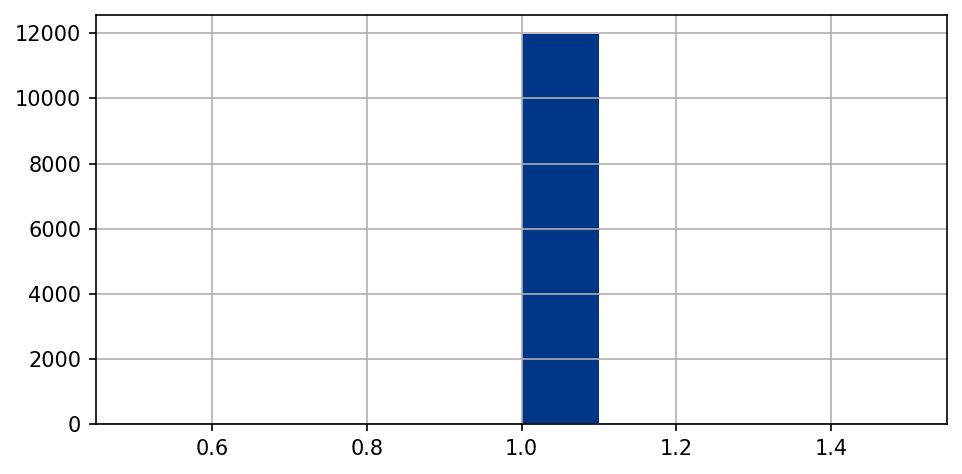

In [126]:
statusReport.domain.value_counts().hist()


## Key Numbers


### Start, End, Duration


In [127]:
crawlStart = statusReport.start.min()
crawlEnd = statusReport.loc[~(statusReport.end.isna()), 'end'].max()
crawlDuration = crawlEnd-crawlStart
perDomainTime = crawlDuration/statusReport.shape[0]
totalTime = perDomainTime*11957
leftoverTime = perDomainTime*missingDomains
crawlEndTime = statusReport.end.max() + leftoverTime

print('Crawl Start     ', crawlStart)
print('Crawl End       ', crawlEnd)
print('Crawl Duration  ', crawlDuration)

print()
print('Estimate for all 11,957 domains:  ', totalTime)

print()
print(f'Estimate for missing {missingDomains} domains:  ', leftoverTime)
print(f'Estimate for crawl-end-time:  ', crawlEndTime)


Crawl Start      2022-11-22 09:38:50.069000+00:00
Crawl End        2022-12-05 08:59:59.307000+00:00
Crawl Duration   12 days 23:21:09.238000

Estimate for all 11,957 domains:   12 days 23:21:09.237999027

Estimate for missing 0 domains:   0 days 00:00:00
Estimate for crawl-end-time:   2022-12-05 08:59:59.307000+00:00


### Successful, Unsuccessful


In [27]:
totalDomains = statusReport.shape[0]
successfulDomains = statusReport[~(statusReport.hasErrors)].shape[0]
errorDomains = statusReport[statusReport.hasErrors].shape[0]

print('Total Domain Count       ', totalDomains)
print('Successful Domain Count  ', successfulDomains)
print('Error Domain Count       ', errorDomains)


Total Domain Count        11957
Successful Domain Count   4856
Error Domain Count        7101


In [28]:
crawledDomainsAtRanks = statusReport.pivot_table(
    index='rank_group', aggfunc={'domain': 'count'}).domain
crawledDomainsAtRanks


rank_group
(0, 10000]         1803
(10000, 20000]     1480
(20000, 30000]     1351
(30000, 40000]     1183
(40000, 50000]     1145
(50000, 60000]     1132
(60000, 70000]     1011
(70000, 80000]      962
(80000, 90000]      959
(90000, 100000]     931
Name: domain, dtype: int64

In [29]:
successfulDomainsAtRanks = statusReport[~(statusReport.hasErrors)]\
    .pivot_table(index='rank_group', aggfunc={'domain': 'count'})\
    .domain
successfulDomainsAtRanks


rank_group
(0, 10000]         815
(10000, 20000]     612
(20000, 30000]     541
(30000, 40000]     485
(40000, 50000]     511
(50000, 60000]     472
(60000, 70000]     403
(70000, 80000]     352
(80000, 90000]     344
(90000, 100000]    321
Name: domain, dtype: int64

In [128]:
successfulDomainsAtCmpsOthered = statusReport[~statusReport.hasErrors].cmp_simplified_othered\
    .value_counts()\
    .sort_index(key=keyOthersToEnd)
successfulDomainsAtCmpsOtheredMore = statusReport[~statusReport.hasErrors].cmp_simplified_othered_more\
    .value_counts()\
    .sort_index(key=keyOthersToEnd)
successfulDomainsAtCmpsOtheredMore


consentmanager.net      97
cookiebar              218
cookiecontrolcivic     128
didomi.io              220
funding choices        215
onetrust              2344
quantcast              426
sourcepoint            354
tealium.com            146
trustarc               201
other                  507
Name: cmp_simplified_othered_more, dtype: int64

In [129]:
successfulDomainsAtTldsOthered = statusReport[~statusReport.hasErrors].tld_othered\
    .value_counts()\
    .sort_index()\
    .sort_index(key=keyTldCategory)
successfulDomainsAtTldsOthered


be         46
es         47
it         68
nl         40
de        272
fr        103
uk        299
com      2994
io         53
net       181
org       154
other     599
Name: tld_othered, dtype: int64

In [130]:
statusReport

domain          reachedDomain  \
0                  yahoo.com              yahoo.com   
1                 google.com             google.com   
2               facebook.com           facebook.com   
3            googlevideo.com             google.com   
4             cloudflare.com         cloudflare.com   
...                      ...                    ...   
11952          fdocuments.in          fdocuments.in   
11953             dimelo.com                    NaN   
11954              srv00.com              srv00.com   
11955        cgmagonline.com                    NaN   
11956  steamcardexchange.net  steamcardexchange.net   

                                 start                              end  \
0     2022-11-22 09:38:50.097000+00:00 2022-11-22 09:42:56.915000+00:00   
1     2022-11-22 09:38:50.069000+00:00 2022-11-22 09:42:59.023000+00:00   
2     2022-11-22 09:38:50.095000+00:00 2022-11-22 09:42:59.675000+00:00   
3     2022-11-22 09:38:50.099000+00:00 2022-11-22 09:43:18.030000+00:00   
4     2022-11-22 09:38:50.097000+00:00 2022-11-22 09:43:57.246000+00:00   
...                                ...                              ...   
11952 2022-12-05 07:46:58.361000+00:00 2022-12-05 07:53:54.555000+00:00   
11953 2022-12-05 07:46:58.364000+00:00 2022-12-05 07:56:30.764000+00:00   
11954 2022-12-05 07:46:58.362000+00:00 2022-12-05 08:01:08.431000+00:00   
11955 2022-12-05 07:46:58.363000+00:00 2022-12-05 08:06:21.590000+00:00   
11956 2022-12-05 07:46:58.361000+00:00 2022-12-05 08:59:59.307000+00:00   

       hasErrors              error                         originalFile  \
0          False         Successful  results.json_00000000-00000009.json   
1           True       excluded CMP  results.json_00000000-00000009.json   
2          False         Successful  results.json_00000000-00000009.json   
3           True       excluded CMP  results.json_00000000-00000009.json   
4          False         Successful  results.json_00000000-00000009.json   
...          ...                ...                                  ...   
11952      False         Successful  results.json_00012110-00012114.json   
11953       True  unspecified error  results.json_00012110-00012114.json   
11954       True             no CMP  results.json_00012110-00012114.json   
11955       True      timeout error  results.json_00012110-00012114.json   
11956       True             no CMP  results.json_00012110-00012114.json   

                   cmp                                 cmps  pagerank  \
0          yahoo_popup         [yahoo_popup, yahoo_consent]        16   
1         google_popup                       [google_popup]         1   
2             Facebook                           [Facebook]         4   
3         google_popup                       [google_popup]        36   
4      onetrust_banner  [onetrust_banner, onetrust_pcpanel]        14   
...                ...                                  ...       ...   
11952           bbc_fc                             [bbc_fc]     96374   
11953              NaN                                  NaN     99618   
11954              NaN                                  NaN     97483   
11955              NaN                                  NaN     97805   
11956              NaN                                  NaN     95994   

            rank_group  wronglyTagged                         status  \
0           (0, 10000]          False                     successful   
1           (0, 10000]          False                   excluded CMP   
2           (0, 10000]          False                     successful   
3           (0, 10000]          False                   excluded CMP   
4           (0, 10000]          False                     successful   
...                ...            ...                            ...   
11952  (90000, 100000]          False                     successful   
11953  (90000, 100000]          False  error in fingerprinting crawl   
11954  (90000, 100000]

### Page Counts


In [131]:
pagesPerDomain = flowReport.page.max() + 1
successfulPagesPerConsentMode = successfulDomains * pagesPerDomain
successfulPages = successfulPagesPerConsentMode * 3

print('Pages per Domain                   ', pagesPerDomain)
print('Successful Domain Count            ', successfulDomains)
print('Successful Pages per consent mode  ', successfulPagesPerConsentMode)
print('Successful Pages Overall           ', successfulPages)


NameError: name 'successfulDomains' is not defined

## Time and Progress


/tmp/ipykernel_1617428/2514740202.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  timing = timing.append(pd.Series(
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font fa

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

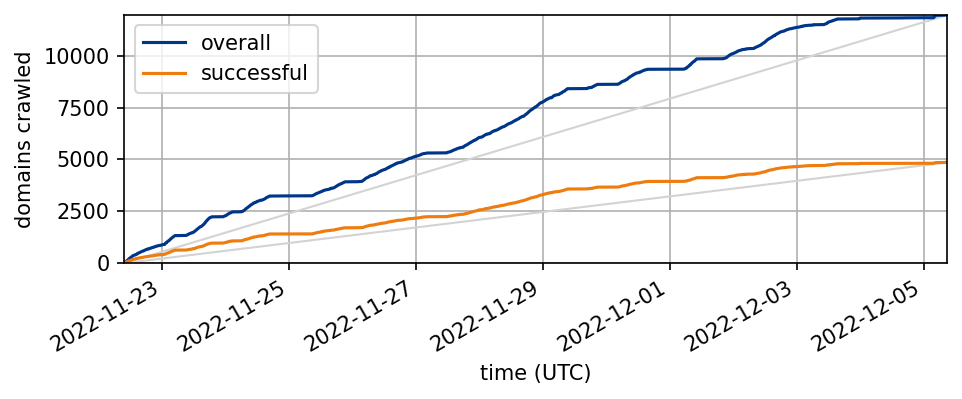

In [34]:
timing = statusReport.sort_values('end')[['end', 'hasErrors']]
timing['overall'] = range(1, statusReport.shape[0]+1)
timing['successful'] = (
    timing.hasErrors == False).expanding(min_periods=1).sum()
timing = timing.loc[:, ['end', 'overall', 'successful']]

timing = timing.append(pd.Series(
    {'end': crawlStart, 'overall': 0, 'successful': 0}), ignore_index=True)

fig, ax = plt.subplots(1)
fig.set_figheight(2.5)

ax.plot([crawlStart, crawlEnd], [0, statusReport.shape[0]],
        color='lightgrey', linewidth=1)
ax.plot([crawlStart, crawlEnd], [0, successfulDomains],
        color='lightgrey', linewidth=1)

timing.pivot_table(index='end', aggfunc={
                   'overall': 'max', 'successful': 'max'}).plot(ax=ax)

ax.set_xlim(crawlStart, crawlEnd)
ax.set_ylim(0, statusReport.shape[0])

ax.set_ylabel('domains crawled')
ax.set_xlabel('time (UTC)')

ax.grid(visible=True, axis='both')
ax.set_axisbelow(True)

# saveFigure(fig,'fingerprinting_scan_progress-timeline')
saveFigure(fig,'fingerprinting_scan_progress-timeline')


## Joint Status at Ranks


In [35]:
jointStatus.status.value_counts()


no CMP detected                      74733
not reached in filter crawl          13310
compatible CMP detected              11957
Successful                            4856
scanned unintentionally               2555
no notice in fingerprinting crawl     1802
excluded CMP                           962
timeout error                          788
unreachable                            475
unspecified error                      472
argtype error                           26
domain skipped                          21
Name: status, dtype: int64

In [36]:
joint_status_at_ranks = jointStatus.pivot_table(
    index=['rank_group'], columns=['status_othered'], aggfunc={'domain': 'count'})
joint_status_at_ranks


domain                                          \
status_othered  Successful compatible CMP detected no CMP detected   
rank_group                                                           
(0, 10000]             815                    1803            6494   
(10000, 20000]         612                    1480            7153   
(20000, 30000]         541                    1351            7274   
(30000, 40000]         485                    1183            7524   
(40000, 50000]         511                    1145            7575   
(50000, 60000]         472                    1132            7576   
(60000, 70000]         403                    1011            7646   
(70000, 80000]         352                     962            7828   
(80000, 90000]         344                     959            7788   
(90000, 100000]        321                     931            7875   

                                             \
status_othered  not reached in filter crawl   
rank_group                                    
(0, 10000]                             1703   
(10000, 20000]                         1367   
(20000, 30000]                         1375   
(30000, 40000]                         1293   
(40000, 50000]                         1280   
(50000, 60000]                         1292   
(60000, 70000]                         1343   
(70000, 80000]                         1210   
(80000, 90000]                         1253   
(90000, 100000]                        1194   

                                                                             
status_othered  other error in fingerprinting crawl scanned unintentionally  
rank_group                                                                   
(0, 10000]                                      744                     244  
(10000, 20000]                                  609                     259  
(20000, 30000]                                  558                     252  
(30000, 40000]                                  446                     252  
(40000, 50000]                                  382                     252  
(50000, 60000]                                  376                     284  
(60000, 70000]                                  353                     255  
(70000, 80000]                                  369                     241  
(80000, 90000]                                  353                     262  
(90000, 100000]                                 356                     254

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, Comic Neue, Comic Sans MS, cursive
findfont: Font family ['Charter'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Charter' not found.
findfont: Font family '

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

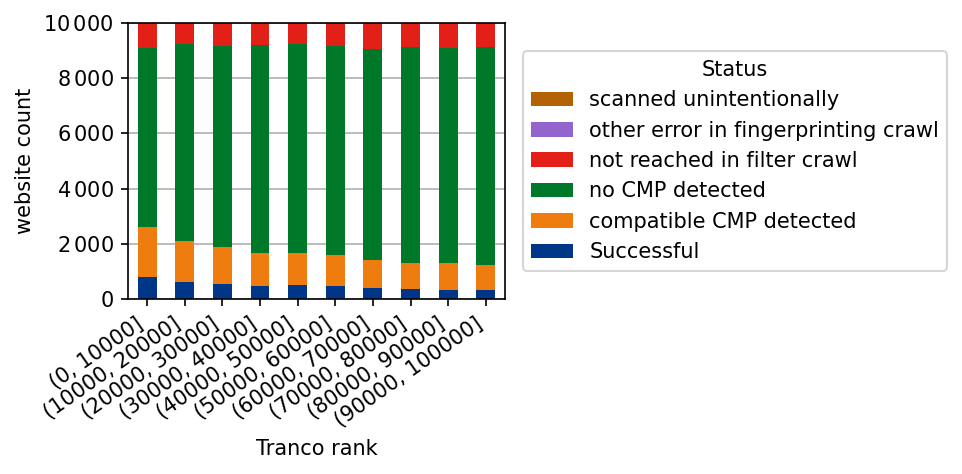

In [37]:
fig, ax = plt.subplots()
joint_status_at_ranks.plot(
    ax=ax,
    kind='bar',
    stacked=True
)

# fig.set_figheight(4)

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([c[1] for c in joint_status_at_ranks.columns]),
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='Status'
)

ax.set_ylabel('website count')
ax.set_xlabel('Tranco rank')

ax.set_ylim(0, 10000)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

ax.yaxis.set_major_formatter(thousandsGroupingFormatter)

saveFigure(fig,'joint_scan_status_details')


## Status at Ranks


In [38]:
statusReport.error.value_counts()


Successful                 4856
scanned unintentionally    2555
no CMP                     1802
excluded CMP                962
timeout error               788
unreachable                 475
unspecified error           472
argtype error                26
domain skipped               21
Name: error, dtype: int64

In [39]:
status_at_ranks = statusReport\
    .pivot_table(index=['rank_group'], columns=['statusSimplified'], aggfunc={'domain': 'count'})\
    .domain\
    .drop('scanned unintentionally',axis=1)\
    [['successful','excluded CMP','no CMP','timeout error','other crawler error','unreachable']]
status_at_ranks


statusSimplified  successful  excluded CMP  no CMP  timeout error  \
rank_group                                                          
(0, 10000]               815           198     319            106   
(10000, 20000]           612           195     222             87   
(20000, 30000]           541            73     205             93   
(30000, 40000]           485            70     199             77   
(40000, 50000]           511            73     183             54   
(50000, 60000]           472            87     160             56   
(60000, 70000]           403            70     128             64   
(70000, 80000]           352            77     108            103   
(80000, 90000]           344            62     143             61   
(90000, 100000]          321            57     135             87   

statusSimplified  other crawler error  unreachable  
rank_group                                          
(0, 10000]                         61           60  
(10000, 20000]                     56           49  
(20000, 30000]                     77          110  
(30000, 40000]                     54           46  
(40000, 50000]                     38           34  
(50000, 60000]                     41           32  
(60000, 70000]                     51           40  
(70000, 80000]                     49           32  
(80000, 90000]                     55           32  
(90000, 100000]                    37           40

In [40]:
intentionallyCrawledOrSuccessfulDomainsAtRanks = status_at_ranks.apply('sum',axis=1)
intentionallyCrawledOrSuccessfulDomainsAtRanks

rank_group
(0, 10000]         1559
(10000, 20000]     1221
(20000, 30000]     1099
(30000, 40000]      931
(40000, 50000]      893
(50000, 60000]      848
(60000, 70000]      756
(70000, 80000]      721
(80000, 90000]      697
(90000, 100000]     677
dtype: int64

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

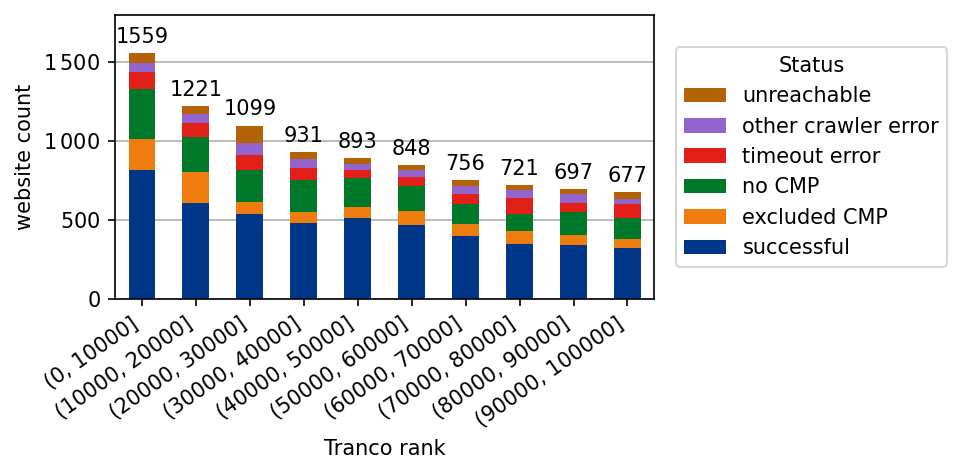

In [41]:
fig, ax = plt.subplots()

status_at_ranks.plot(ax=ax, kind='bar', stacked=True)

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([c for c in status_at_ranks.columns]),
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='Status'
)

ax.set_ylabel('website count')
ax.set_xlabel('Tranco rank')

ax.set_ylim(top=1800)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

ax.yaxis.set_major_formatter(thousandsGroupingFormatter)

ax.bar_label(ax.containers[5], intentionallyCrawledOrSuccessfulDomainsAtRanks, padding=3)

saveFigure(fig,'fingerprinting_scan_status_details')


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

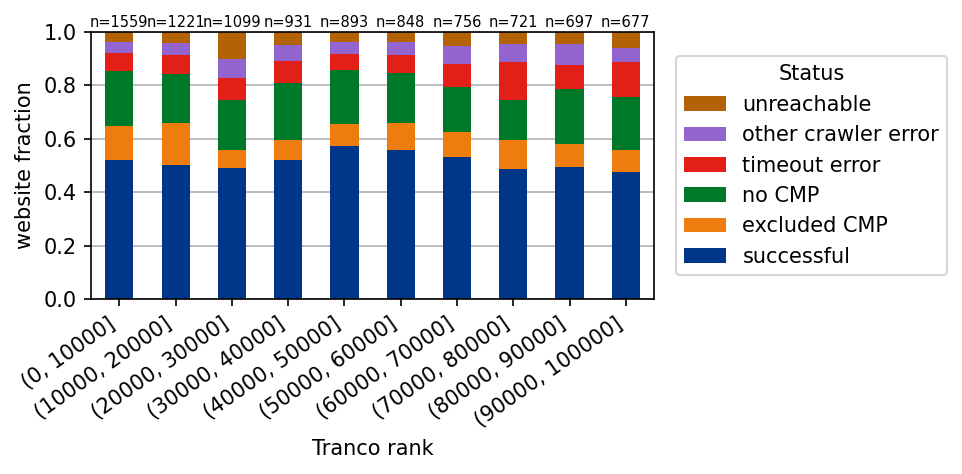

In [42]:
fig, ax = plt.subplots()

status_at_ranks\
    .divide(intentionallyCrawledOrSuccessfulDomainsAtRanks, axis='index')\
    .plot(ax=ax, kind='bar', stacked=True)

# fig.set_figheight(4)

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([c for c in status_at_ranks.columns]),
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='Status'
)

ax.set_ylabel('website fraction')
ax.set_xlabel('Tranco rank')

ax.set_ylim(0, 1)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

# ax.yaxis.set_major_formatter(thousandsGroupingFormatter)

ax.bar_label(ax.containers[5], ['n='+str(l)
             for l in intentionallyCrawledOrSuccessfulDomainsAtRanks], padding=1, size=7)

saveFigure(fig,'fingerprinting_scan_status_details_relative')


## Redirects


In [43]:
statusReport.pivot_table(index='error', columns=(
    statusReport.reachedDomain == statusReport.domain), aggfunc={'domain': 'count'})


domain        
                         False   True 
error                                 
Successful               959.0  3897.0
argtype error             26.0     NaN
domain skipped            21.0     NaN
excluded CMP             278.0   684.0
no CMP                   266.0  1536.0
scanned unintentionally  567.0  1988.0
timeout error            788.0     NaN
unreachable              475.0     NaN
unspecified error        472.0     NaN

In [44]:
redirects = statusReport.loc[~(
    statusReport.reachedDomain == statusReport.domain) & ~statusReport.hasErrors, :]
redirects.to_csv('crawl_results_fingerprinting/redirects.csv')
redirects


domain       reachedDomain  \
7                fastly.net          fastly.com   
22           macromedia.com           adobe.com   
24               omtrdc.net           adobe.com   
32                fbcdn.net        facebook.com   
39               linode.com      www.linode.com   
...                     ...                 ...   
11856           piagroup.be              pia.be   
11894        enelint.global            enel.com   
11918       theherald.co.uk  heraldscotland.com   
11940  squarespace-mail.com     squarespace.com   
11946       swansonmeals.ca    conagrabrands.ca   

                                 start                              end  \
7     2022-11-22 09:38:50.098000+00:00 2022-11-22 09:44:14.910000+00:00   
22    2022-11-22 09:44:10.562000+00:00 2022-11-22 09:50:49.712000+00:00   
24    2022-11-22 09:44:14.911000+00:00 2022-11-22 09:52:01.075000+00:00   
32    2022-11-22 09:50:39.129000+00:00 2022-11-22 09:55:03.269000+00:00   
39    2022-11-22 09:53:25.428000+00:00 2022-11-22 09:58:04.563000+00:00   
...                                ...                              ...   
11856 2022-12-03 13:07:22.340000+00:00 2022-12-03 13:34:57.774000+00:00   
11894 2022-12-03 14:04:55.821000+00:00 2022-12-03 14:20:08.544000+00:00   
11918 2022-12-03 10:50:30.535000+00:00 2022-12-03 14:59:18.188000+00:00   
11940 2022-12-03 15:12:46.374000+00:00 2022-12-03 15:18:56.932000+00:00   
11946 2022-12-05 07:46:58.365000+00:00 2022-12-05 07:51:05.311000+00:00   

       hasErrors       error                         originalFile  \
7          False  Successful  results.json_00000000-00000009.json   
22         False  Successful  results.json_00000020-00000029.json   
24         False  Successful  results.json_00000020-00000029.json   
32         False  Successful  results.json_00000030-00000039.json   
39         False  Successful  results.json_00000030-00000039.json   
...          ...         ...                                  ...   
11856      False  Successful  results.json_00012000-00012009.json   
11894      False  Successful  results.json_00012040-00012049.json   
11918      False  Successful  results.json_00012060-00012069.json   
11940      False  Successful  results.json_00012080-00012089.json   
11946      False  Successful  results.json_00012100-00012109.json   

                        cmp  \
7           onetrust_banner   
22          onetrust_banner   
24          onetrust_banner   
32                 Facebook   
39     trustarc_popup_hider   
...                     ...   
11856          cookiescript   
11894           trustarcbar   
11918      sourcepointpopup   
11940           trustarcbar   
11946          EvidonBanner   

                                                    cmps  pagerank  \
7                    [onetrust_banner, onetrust_pcpanel]        28   
22                   [onetrust_banner, onetrust_pcpanel]        82   
24                   [onetrust_banner, onetrust_pcpanel]        96   
32                                            [Facebook]       161   
39                 [trustarc_popup_hider, trustarcframe]       187   
...                                                  ...       ...   
11856                                     [cookiescript]     99002   
11894  [trustarcbar, trustarc_popup_hider, trustarcfr...     99502   
11918         [sourcepointpopup, sourcepoint_frame_2022]     98027   
11940  [trustarcbar, trustarc_popup_hider, trustarcfr...     99990   
11946                                     [EvidonBanner]     99663   

            rank_group  wronglyTagged      status statusSimplified  \
7           (0, 10000]          False  successful       successful   
22          (0, 10000]          False  successful       successful   
24          (0, 10000]          False  successful       successful   
32          (0, 10000]          False  successful       successful   
39          (0, 10000]          False  successful       successful   
...                ...            ...       

## CMPs


In [45]:
cmp_at_ranks = statusReport\
    .loc[~(statusReport.cmp_simplified_othered.isna())]\
    .pivot_table(index=['rank_group'], columns=['cmp_simplified_othered'], aggfunc={'domain': 'count'})\
    .sort_values(axis='columns', by=1, ascending=False)
other_column = cmp_at_ranks.pop(('domain', 'other'))
cmp_at_ranks[('domain', 'other')] = other_column

cmp_at_ranks


domain                                         \
cmp_simplified_othered onetrust google sourcepoint quantcast cookiebot   
rank_group                                                               
(0, 10000]                  473    147          58        53        51   
(10000, 20000]              319    130          36        43        65   
(20000, 30000]              274     16          40        44        57   
(30000, 40000]              217     14          32        52        56   
(40000, 50000]              242     14          38        50        59   
(50000, 60000]              220     13          45        40        74   
(60000, 70000]              171     12          26        43        58   
(70000, 80000]              157      9          28        27        68   
(80000, 90000]              140      6          22        36        56   
(90000, 100000]             131     12          29        38        45   

                                                  
cmp_simplified_othered didomi.io cookiebar other  
rank_group                                        
(0, 10000]                    26         9   196  
(10000, 20000]                42        18   154  
(20000, 30000]                20        25   138  
(30000, 40000]                23        18   143  
(40000, 50000]                20        24   137  
(50000, 60000]                21        21   125  
(60000, 70000]                26        24   113  
(70000, 80000]                18        28    94  
(80000, 90000]                16        35    95  
(90000, 100000]                8        16    99

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

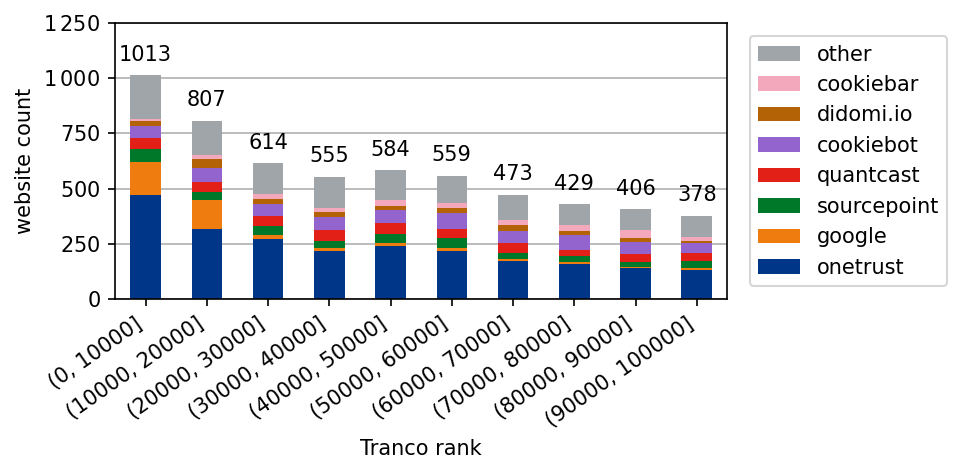

In [46]:
fig, ax = plt.subplots()
cmp_at_ranks.plot(
    ax=ax,
    kind='bar',
    stacked=True
)

# fig.set_figheight(3)

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([c[1] for c in cmp_at_ranks.columns]),
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1
)

ax.set_ylabel('website count')
ax.set_xlabel('Tranco rank')

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

ax.yaxis.set_major_formatter(thousandsGroupingFormatter)

ax.bar_label(ax.containers[7], padding=5)

ax.set_ylim(0, 1250)

# plt.tight_layout(pad=0)
# fig.set_tight_layout(True)
saveFigure(fig,'fingerprinting_scan_cmp_details')


# Analyze Findings

Everything starting from here only applies to the successfully crawled websites


## Fingerprinting Attributes


### Number of Distinct Attributes per Domain


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

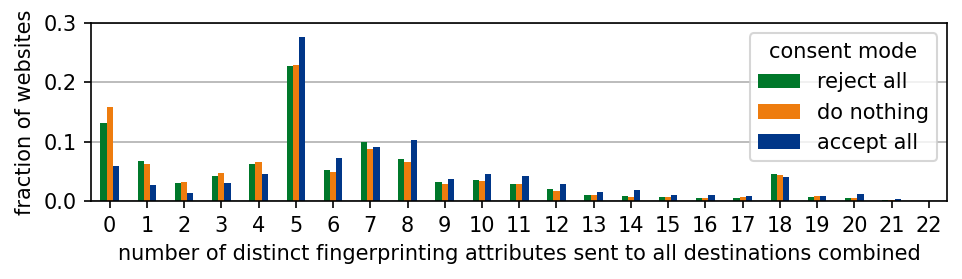

In [47]:
fpAttrCountHist = flowReport\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'source': 'nunique'})\
    .reset_index()\
    .rename(columns={'source': 'fpAttrCount'})\
    .merge(successfulDomainsAndModes, how='right')\
    .fillna(0)\
    .pivot_table(index='fpAttrCount', columns='consentMode', aggfunc={'domain': 'count'}).astype('int')\
    .divide(successfulDomains)\
    .sort_index(axis='columns', ascending=False)

fig, ax = plt.subplots()

fig.set_figheight(1.7)

fpAttrCountHist.plot(ax=ax, kind='bar', color=rdaColors)

ax.set_xlabel(
    'number of distinct fingerprinting attributes sent to all destinations combined')
ax.set_ylabel('fraction of websites')

ax.set_ylim(top=.3)
ax.set_xlim(right=22.5)


handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in fpAttrCountHist.columns],
    loc='upper right',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.set_major_formatter(integerFormatter)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_fingerprinting-attribute-histogram')
saveLatexTable(fpAttrCountHist,'fp-attr_count-hist.tex')


In [48]:
fpAttrCountHist

domain                    
consentMode rejectAll doNothing acceptAll
fpAttrCount                              
0.0          0.132002  0.158773  0.058484
1.0          0.067133  0.062191  0.027801
2.0          0.030066  0.032331  0.013386
3.0          0.042628  0.046540  0.030478
4.0          0.063015  0.065898  0.046334
5.0          0.227142  0.228789  0.276771
6.0          0.051895  0.048600  0.071870
7.0          0.098847  0.087109  0.091433
8.0          0.071252  0.065074  0.102142
9.0          0.032125  0.028213  0.036450
10.0         0.036038  0.034390  0.044893
11.0         0.029242  0.028830  0.043040
12.0         0.021005  0.017092  0.029448
13.0         0.009885  0.010502  0.015857
14.0         0.009267  0.007002  0.018740
15.0         0.006178  0.006178  0.010502
16.0         0.004942  0.004736  0.009885
17.0         0.005766  0.006590  0.008237
18.0         0.045511  0.044069  0.040568
19.0         0.007619  0.008855  0.009061
20.0         0.005560  0.005560  0.011120
21.0         0.002059  0.002059  0.002677
22.0         0.000824  0.000618  0.000824

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

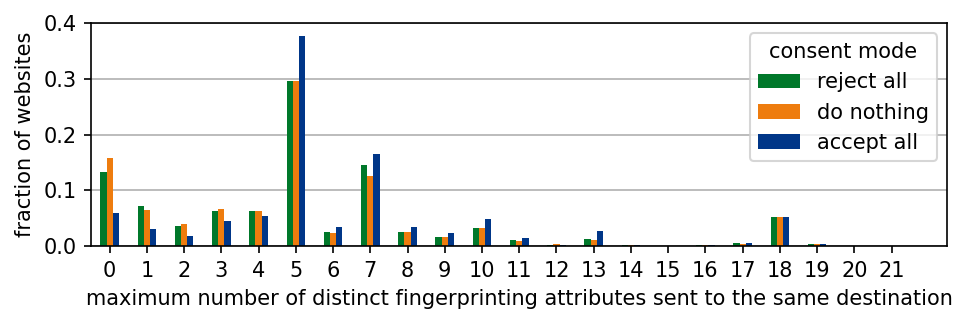

In [49]:
fpAttrCountHistDest = flowReport\
    .pivot_table(index=['domain', 'destinationHost', 'consentMode'], aggfunc={'source': 'nunique'})\
    .reset_index()\
    .rename(columns={'source': 'fpAttrCount'})\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'fpAttrCount': 'max'})\
    .reset_index()\
    .merge(successfulDomainsAndModes, how='right')\
    .fillna(0)\
    .pivot_table(index='fpAttrCount', columns='consentMode', aggfunc={'domain': 'count'})\
    .fillna(0)\
    .astype('int')\
    .divide(successfulDomains)\
    .sort_index(axis='columns', ascending=False)

fig, ax = plt.subplots()

fig.set_figheight(2)

fpAttrCountHistDest.plot(ax=ax, kind='bar', color=rdaColors)


ax.set_xlabel(
    'maximum number of distinct fingerprinting attributes sent to the same destination')
ax.set_ylabel('fraction of websites')

ax.set_ylim(top=.4)
ax.set_xlim(right=22.5)

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in fpAttrCountHistDest.columns],
    loc='upper right',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.set_major_formatter(integerFormatter)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_fingerprinting-attribute-destination-histogram')
saveLatexTable(fpAttrCountHistDest,'fp-attr_count-dest-hist.tex')


In [50]:
(data := flowReport
    .pivot_table(index=['domain', 'destinationHost', 'consentMode'], aggfunc={'source': 'nunique'})
    .reset_index()
    .rename(columns={'source': 'fpAttrCount'})
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'fpAttrCount': 'max'})
    .reset_index())[(data.fpAttrCount == 18) & (data.consentMode == 'acceptAll')]


domain consentMode  fpAttrCount
27              24s.com   acceptAll           18
42              2o7.net   acceptAll           18
45      2paragraphs.com   acceptAll           18
118            abcam.cn   acceptAll           18
167    accu-weather.com   acceptAll           18
...                 ...         ...          ...
12519          wowtv.de   acceptAll           18
12702          zara.com   acceptAll           18
12705          zara.net   acceptAll           18
12746       zenedge.net   acceptAll           18
12754  zennioptical.com   acceptAll           18

[255 rows x 3 columns]

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.


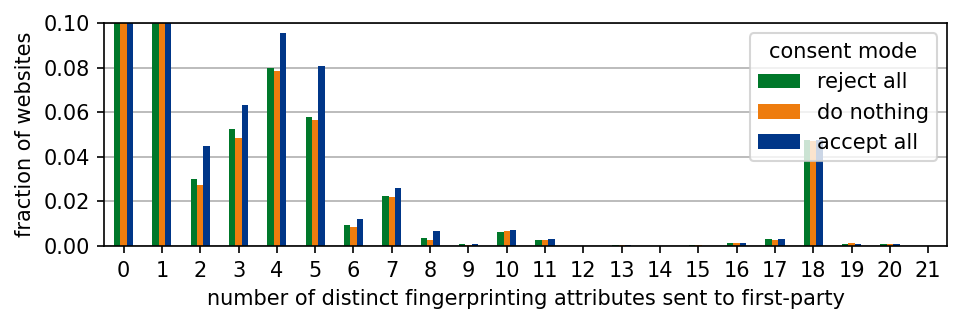

In [51]:
fpAttrCountHistDest = flowReport[flowReport.destinationSimplified == 'first-party']\
    .pivot_table(index=['domain', 'destinationHost', 'consentMode'], aggfunc={'source': 'nunique'})\
    .reset_index()\
    .rename(columns={'source': 'fpAttrCount'})\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'fpAttrCount': 'max'})\
    .reset_index()\
    .merge(successfulDomainsAndModes, how='right')\
    .fillna(0)\
    .pivot_table(index='fpAttrCount', columns='consentMode', aggfunc={'domain': 'count'})\
    .fillna(0)\
    .astype('int')\
    .divide(successfulDomains)\
    .sort_index(axis='columns', ascending=False)

fig, ax = plt.subplots()

fig.set_figheight(2)

fpAttrCountHistDest.plot(ax=ax, kind='bar', color=rdaColors)


ax.set_xlabel(
    'number of distinct fingerprinting attributes sent to first-party')
ax.set_ylabel('fraction of websites')

# ax.set_ylim(top=.4)
ax.set_ylim(top=.1)

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in fpAttrCountHistDest.columns],
    loc='upper right',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.set_major_formatter(integerFormatter)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_first-party-fingerprinting-attribute-count')


### Attribute Count First-Party vs Third-Party


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

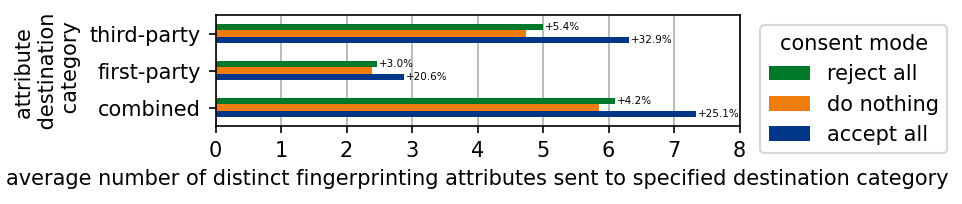

In [52]:
avgAttrToDestCat = pd.concat(
    [
        flowReport
        .pivot_table(index=['domain', 'destinationCategory', 'consentMode'], aggfunc={'source': 'nunique'})
        .reset_index()
        .rename(columns={'source': 'fpAttrCount'}),
        flowReport
        .pivot_table(index=['domain', 'consentMode'], aggfunc={'source': 'nunique'})
        .reset_index()
        .rename(columns={'source': 'fpAttrCount'})
    ]
)\
    .fillna('combined')\
    .pivot_table(index=['destinationCategory'], columns=['consentMode'], aggfunc={'fpAttrCount': 'sum'})\
    .divide(successfulDomains)

fig, ax = plt.subplots()

fig.set_figheight(1.2)

avgAttrToDestCat.plot(kind='barh', ax=ax)

ax.set_ylabel('attribute \n destination \n category')
ax.set_xlabel(
    'average number of distinct fingerprinting attributes sent to specified destination category')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1]) for c in avgAttrToDestCat.columns]),
    loc='upper left',
    bbox_to_anchor=(1.02, 1.0),
    ncol=1,
    title='consent mode',
)

ax.set_xlim(right=8.0)

rejectAllIncrease = (avgAttrToDestCat.fpAttrCount.rejectAll / avgAttrToDestCat.fpAttrCount.doNothing - 1) * 100
acceptAllIncrease = (avgAttrToDestCat.fpAttrCount.acceptAll / avgAttrToDestCat.fpAttrCount.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_attr-count-by-dest')
saveLatexTable(avgAttrToDestCat,'fp-attr_count.tex')


In [53]:
avgAttrToDestCat

fpAttrCount                    
consentMode           acceptAll doNothing rejectAll
destinationCategory                                
combined               7.330725  5.860585  6.103995
first-party            2.880354  2.388386  2.459432
third-party            6.308690  4.745881  5.001030

### Transmission Averages

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.


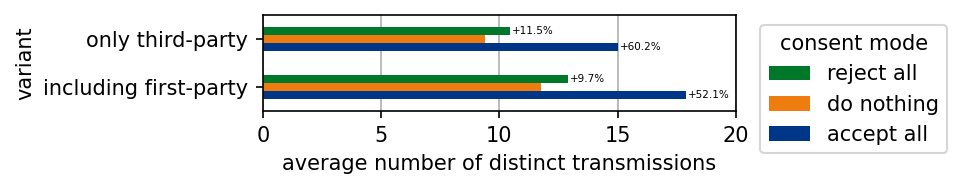

In [54]:
avgTransmissionsToDestCat = pd.concat(
    [
        flowReport[~(flowReport.isFirstParty)]
        .pivot_table(index=['domain', 'consentMode'], aggfunc={'transmission': 'nunique'})
        .reset_index()
        .rename(columns={'transmission': 'transmissionCount'})\
        .assign(variant='only third-party'),
        flowReport
        .pivot_table(index=['domain', 'consentMode'], aggfunc={'transmission': 'nunique'})
        .reset_index()
        .rename(columns={'transmission': 'transmissionCount'})\
        .assign(variant='including first-party')
    ]
)\
    .pivot_table(index=['variant'], columns=['consentMode'], aggfunc={'transmissionCount': 'sum'})\
    .divide(successfulDomains)

fig, ax = plt.subplots()

fig.set_figheight(1.1)

avgTransmissionsToDestCat.plot(kind='barh', ax=ax)

ax.set_ylabel('variant')
ax.set_xlabel(
    'average number of distinct transmissions')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1]) for c in avgTransmissionsToDestCat.columns]),
    loc='upper left',
    bbox_to_anchor=(1.03, 1.0),
    ncol=1,
    title='consent mode',
)

ax.set_xlim(right=20.0)

rejectAllIncrease = (avgTransmissionsToDestCat.transmissionCount.rejectAll / avgTransmissionsToDestCat.transmissionCount.doNothing - 1) * 100
acceptAllIncrease = (avgTransmissionsToDestCat.transmissionCount.acceptAll / avgTransmissionsToDestCat.transmissionCount.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_transm-count-by-dest')
saveLatexTable(avgTransmissionsToDestCat,'fp-transm_count.tex')

# avgTransmissionsToDestCat

### Scatter


In [55]:
transmissionsCountByDomain = flowReport\
    .pivot_table(index=['domain','consentMode'], aggfunc={'transmission': 'nunique'})\
    .reset_index()\
    .merge(successfulDomainsAndModes,how='right')\
    .fillna(0)\
    .set_index(['domain','consentMode'])\
    .unstack(level=1)\
    .transmission\
    .reset_index()
transmissionsCountByDomain

consentMode           domain  acceptAll  doNothing  rejectAll
0                  01net.com       39.0        5.0        7.0
1             1001juegos.com       10.0        2.0       10.0
2                    1177.se        6.0        6.0        6.0
3              123helpme.com       18.0       18.0       18.0
4            1800flowers.com       16.0       16.0       16.0
...                      ...        ...        ...        ...
4851            zycrypto.com       61.0       58.0       48.0
4852               zynga.com        8.0        7.0        7.0
4853          zyngapoker.com       12.0        3.0        3.0
4854               zyxel.com       10.0       10.0       10.0
4855             zzounds.com        8.0        8.0        8.0

[4856 rows x 4 columns]

In [56]:
transmissionsCountNothingVsAccept = transmissionsCountByDomain\
    .pivot_table(index=['doNothing', 'acceptAll'], aggfunc={'domain':'count'})\
    .reset_index()\
    .fillna(0)

transmissionsCountNothingVsReject = transmissionsCountByDomain\
    .pivot_table(index=['doNothing', 'rejectAll'], aggfunc={'domain':'count'})\
    .reset_index()\
    .fillna(0)


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

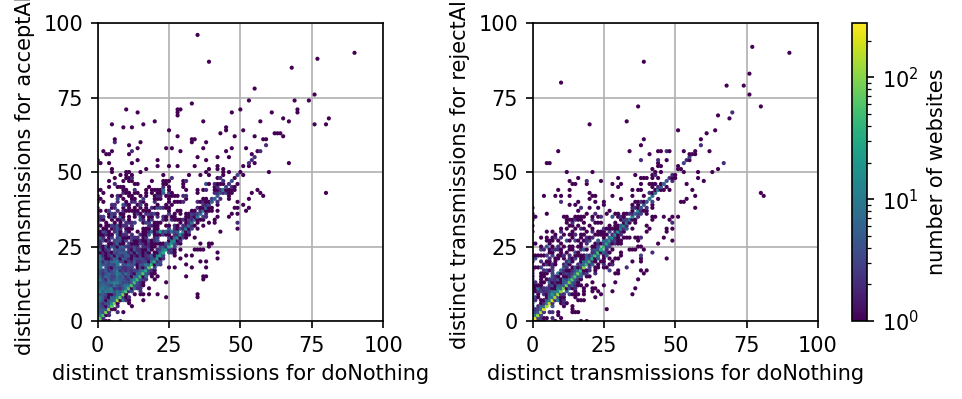

In [57]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1, ncols=2, sharey=False, layout="constrained")
fig.get_layout_engine().set(wspace=0.1)

fig.set_figheight(2.5)
# fig.set_figwidth(5)

sc1 = ax1.scatter(
    x=transmissionsCountNothingVsAccept.doNothing,
    y=transmissionsCountNothingVsAccept.acceptAll,
    c=transmissionsCountNothingVsAccept.domain,
    s=1,
    norm=mpl.colors.LogNorm(
        vmax=transmissionsCountNothingVsAccept.domain.max())
)

sc2 = ax2.scatter(
    x=transmissionsCountNothingVsReject.doNothing,
    y=transmissionsCountNothingVsReject.rejectAll,
    c=transmissionsCountNothingVsReject.domain,
    s=1,
    norm=mpl.colors.LogNorm(
        vmax=transmissionsCountNothingVsAccept.domain.max()),
    # cmap='viridis_r'
)

ax1.set_ylim(bottom=0, top=100)
ax1.set_xlim(left=0, right=100)
ax1.yaxis.set_major_locator(ticker.MultipleLocator(25))
ax2.set_ylim(bottom=0, top=100)
ax2.set_xlim(left=0, right=100)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(25))

ax1.set_ylabel('distinct transmissions for acceptAll')
ax2.set_ylabel('distinct transmissions for rejectAll')
ax1.set_xlabel('distinct transmissions for doNothing')
ax2.set_xlabel('distinct transmissions for doNothing')

ax1.grid()
ax1.set_axisbelow(True)
ax2.grid()
ax2.set_axisbelow(True)


# fig.colorbar(sc1, ax=ax1)
cbar = fig.colorbar(sc2, ax=ax2)
cbar.ax.set_ylabel('number of websites')

saveFigure(fig,'fingerprinting_scan_transmissions-count_consent-impact')


### Most used Fingerprinting Attributes


In [58]:

flowReport[flowReport.source.str.contains('Audio')]\
    .pivot_table(index=['domain', 'source'], columns='consentMode', aggfunc={'domain': 'count'})


domain                    
consentMode                           acceptAll doNothing rejectAll
domain     source                                                  
solvay.com AudioContext.baseLatency           2         2         2
           AudioContext.outputLatency         2         2         2

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.


Average [reject all] increase: 3.6919660624938193
Average [accept all] increase: 24.008942806657707


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

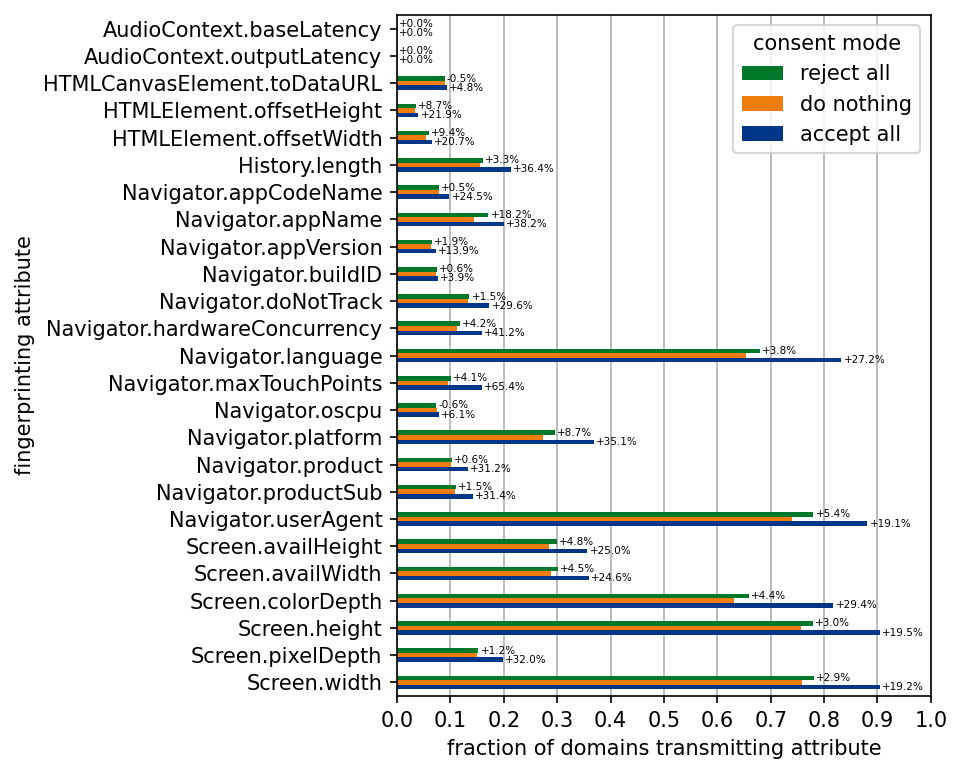

In [59]:


fig, ax = plt.subplots()
fig.set_figheight(5)

# Function x**(1/2)


def forward(x):
    return x**(1/2)


def inverse(x):
    return x**2


domainsTransmittingFpAttrAbs = flowReport\
    .pivot_table(index='source', columns='consentMode', aggfunc={'domain': 'nunique'})\
    .sort_index(ascending=False)

domainsTransmittingFpAttr = domainsTransmittingFpAttrAbs\
    .divide(successfulDomains)

rejectAllIncrease = (domainsTransmittingFpAttr.domain.rejectAll / domainsTransmittingFpAttr.domain.doNothing -1) * 100
print(f'Average [reject all] increase: {rejectAllIncrease.mean()}')
acceptAllIncrease = (domainsTransmittingFpAttr.domain.acceptAll / domainsTransmittingFpAttr.domain.doNothing -1) * 100
print(f'Average [accept all] increase: {acceptAllIncrease.mean()}')

domainsTransmittingFpAttr.plot(kind='barh', ax=ax)

ax.set_xlim(0, 1)
# ax.set_ylim(0,statusReport.shape[0])

# ax.set_xscale('log')
# ax.set_xscale('function', functions=(forward,inverse))

ax.xaxis.set_major_locator(ticker.MultipleLocator(0.1))

ax.set_ylabel('fingerprinting attribute')
ax.set_xlabel('fraction of domains transmitting attribute')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1])
             for c in domainsTransmittingFpAttr.columns]),
    # loc='center left',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

# for c in range(3):
#     ax.bar_label(ax.containers[c],labels=domainsTransmittingFpAttrAbs.iloc[:,c],fontsize=3,padding=2,label_type='edge')

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

# ax.bar_label(ax.containers[1],labels=domainsTransmittingFpAttrAbs.iloc[:,0],fontsize=7,padding=2,label_type='edge')

# .str.concat(',').str.concat(domainsTransmittingFpAttrAbs.iloc[:,1])

saveFigure(fig,'fingerprinting_scan_fingerprinting-attributes')
saveLatexTable(domainsTransmittingFpAttr,'fp-attr_usage.tex')


### Most used Attribute Combinations


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

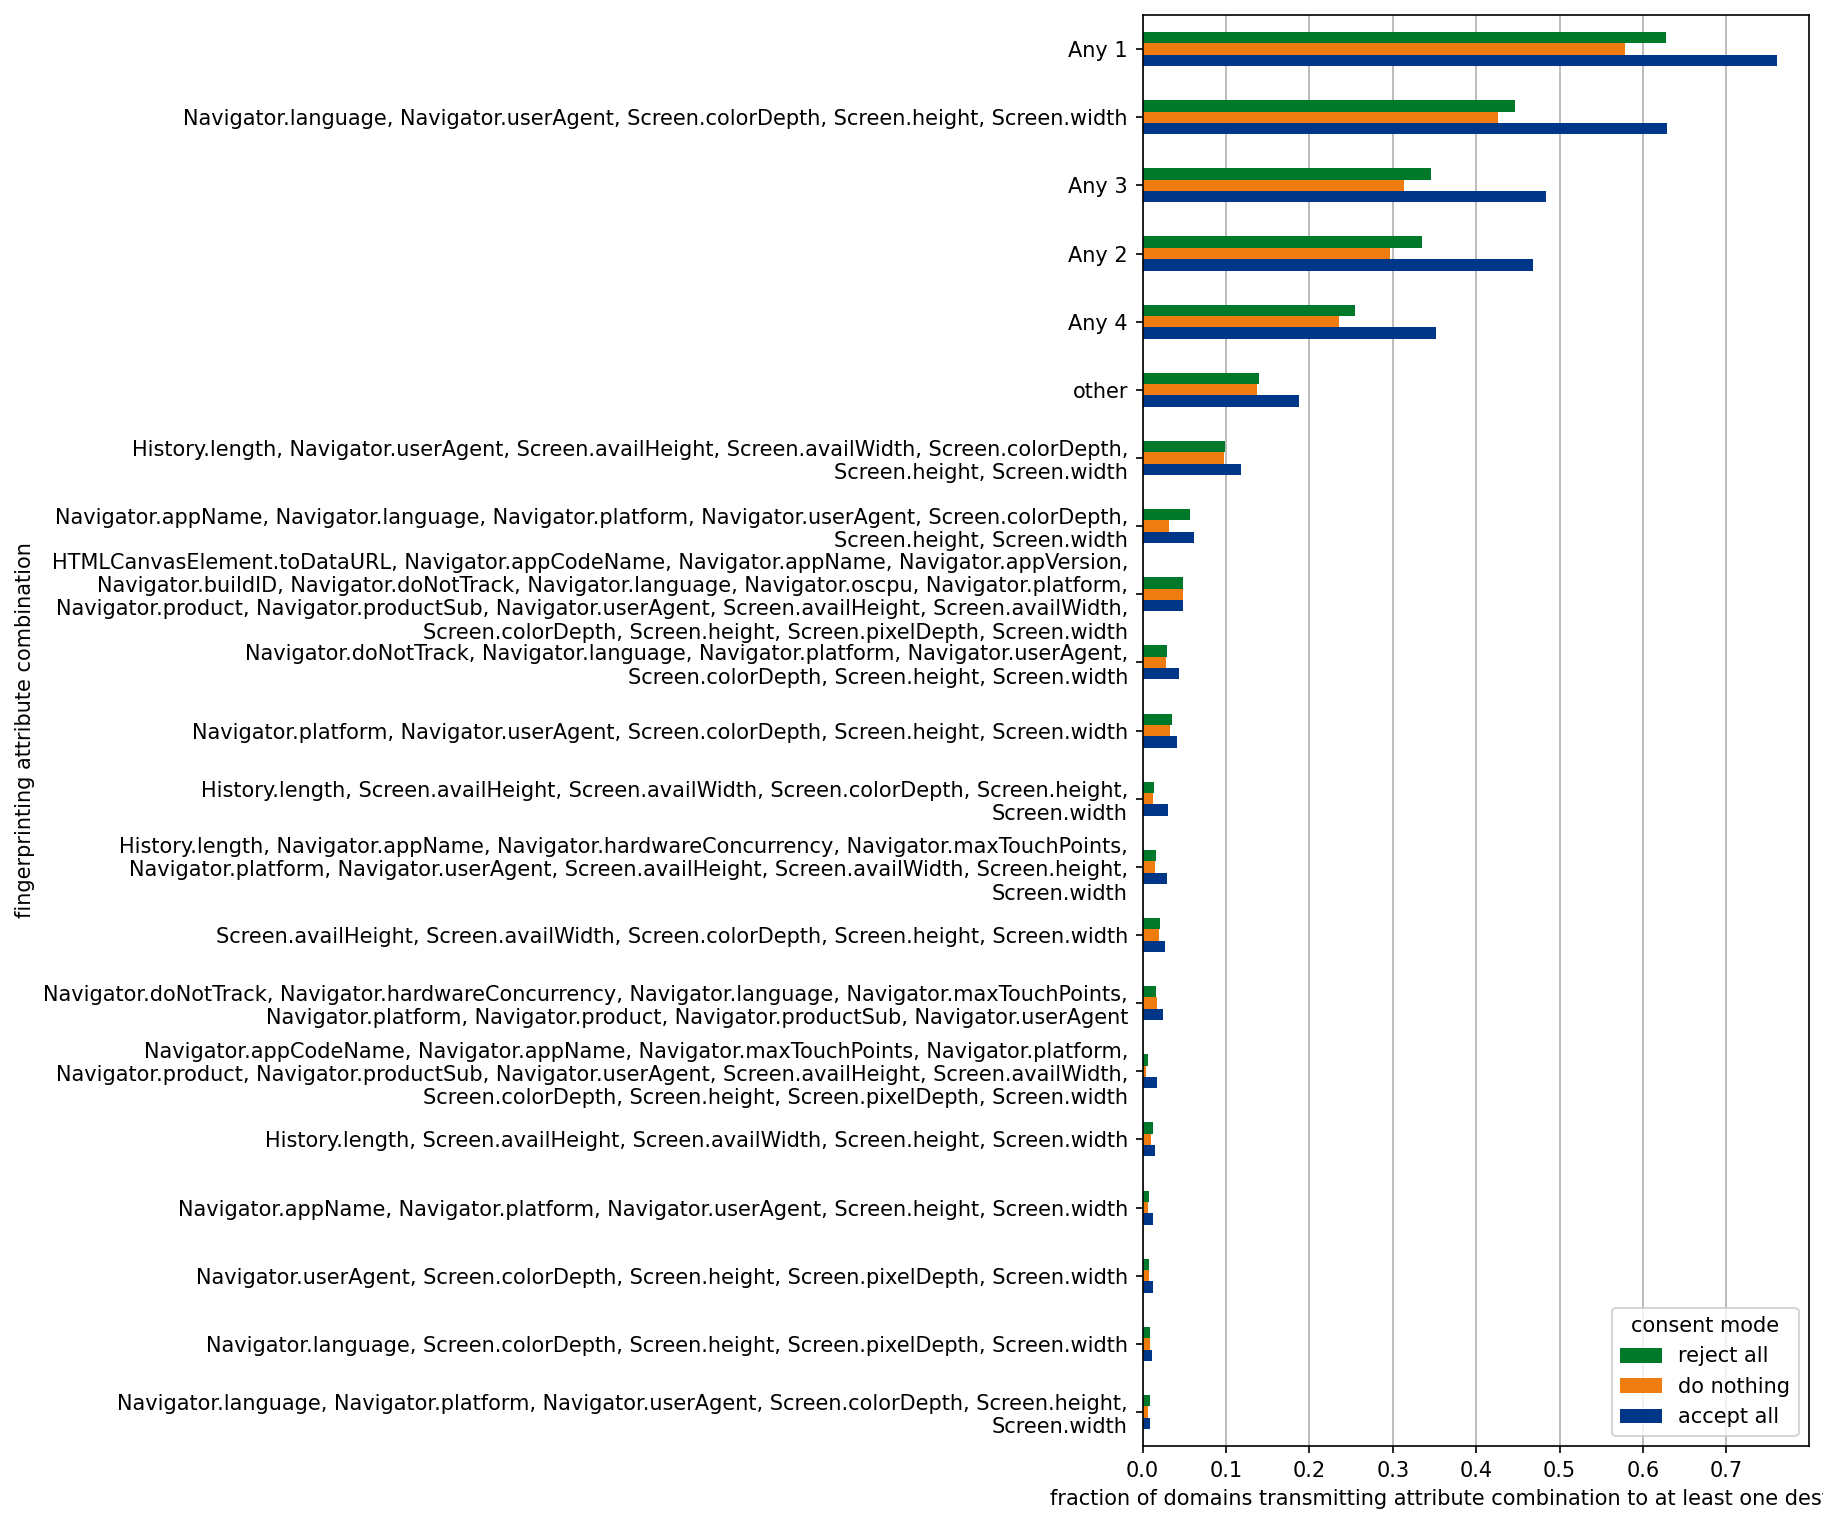

In [60]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(12)

transmittedFpAttrComb = flowReport\
    .pivot_table(index=['domain', 'consentMode', 'destinationSimplified'], aggfunc={'source': lambda x: concatUnique(x, 4)})\
    .reset_index()
transmittedFpAttrComb['sourceComb'] = otherSeries(
    transmittedFpAttrComb.source, 20)


domainsTransmittingFpAttrComb = transmittedFpAttrComb.pivot_table(index='sourceComb', columns='consentMode', aggfunc={'domain': 'nunique'})\
    .fillna(0)\
    .divide(successfulDomains)\
    .sort_values(('domain', 'acceptAll'))

domainsTransmittingFpAttrComb.plot(kind='barh', ax=ax)

# ax.set_xlim(crawlStart,crawlEnd)
# ax.set_ylim(0,statusReport.shape[0])

ax.set_ylabel('fingerprinting attribute combination')
ax.set_xlabel(
    'fraction of domains transmitting attribute combination to at least one destination')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1])
             for c in domainsTransmittingFpAttrComb.columns]),
    loc='lower right',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_top-fp-attr-combinations')


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

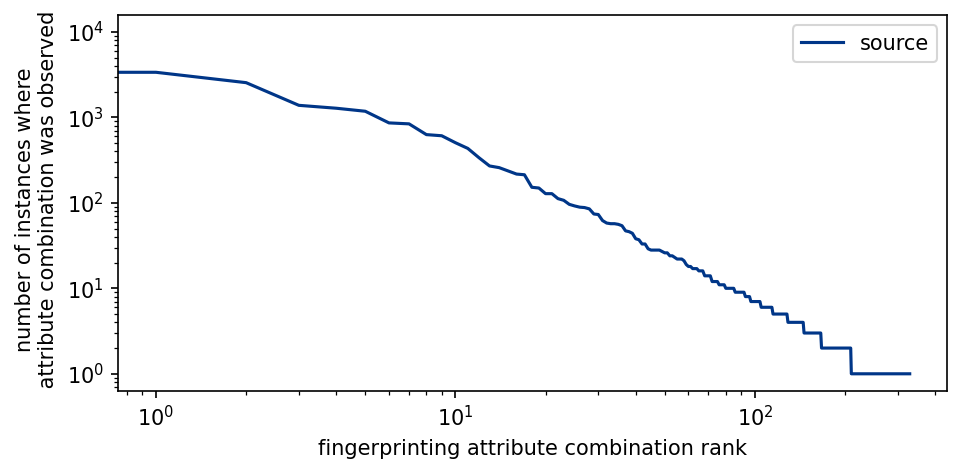

In [61]:
pd.DataFrame(flowReport\
    .pivot_table(index=['domain', 'destinationSimplified'], aggfunc={'source': lambda x: concatUnique(x, 1)})\
    .reset_index().source.value_counts()).reset_index().plot()
plt.xlabel('fingerprinting attribute combination rank')
plt.ylabel('number of instances where  \n attribute combination was observed')

plt.xscale('log')
plt.yscale('log')

### Deep Dive Attribute Combinations


In [62]:
concatTransmissions = transmittedFpAttrComb[[
    'domain', 'destinationSimplified', 'source']].drop_duplicates()
concatTransmissions.source = concatTransmissions.source.str.replace('\n', '')
# concatTransmissions.to_excel('concatTransmissions.xlsx', index=False)
concatTransmissions


domain  destinationSimplified  \
0        01net.com             criteo.com   
1        01net.com        doubleclick.net   
2        01net.com            first-party   
3        01net.com   google-analytics.com   
4        01net.com             google.com   
...            ...                    ...   
63482    zyxel.com   google-analytics.com   
63483    zyxel.com             google.com   
63484    zyxel.com  googlesyndication.com   
63495  zzounds.com            first-party   
63496  zzounds.com   google-analytics.com   

                                                  source  
0                                                  Any 3  
1                                                  Any 3  
2                                                  Any 1  
3      Navigator.language, Navigator.userAgent, Scree...  
4                                                  Any 3  
...                                                  ...  
63482                                              Any 3  
63483                                              Any 2  
63484                                              Any 2  
63495                                              Any 3  
63496  Navigator.language, Navigator.userAgent, Scree...  

[29730 rows x 3 columns]

In [63]:
concatTransmissions.pivot_table(index='source', aggfunc={
                                'domain': 'nunique'}).sort_values('domain', ascending=False).head(20)


domain
source                                                    
Any 1                                                 3769
Navigator.language, Navigator.userAgent, Screen...    3102
Any 3                                                 2468
Any 2                                                 2433
Any 4                                                 1854
History.length, Navigator.userAgent, Screen.ava...     599
Navigator.appName, Navigator.language, Navigato...     376
HTMLCanvasElement.toDataURL, Navigator.appCodeN...     239
Navigator.doNotTrack, Navigator.language, Navig...     216
Navigator.platform, Navigator.userAgent, Screen...     205
History.length, Screen.availHeight, Screen.avai...     158
History.length, Navigator.appName, Navigator.ha...     152
Screen.availHeight, Screen.availWidth, Screen.c...     128
Navigator.doNotTrack, Navigator.hardwareConcurr...     127
Navigator.appCodeName, Navigator.appName, Navig...     107
History.length, Screen.availHeight, Screen.avai...      88
Navigator.appName, Navigator.platform, Navigato...      63
Navigator.userAgent, Screen.colorDepth, Screen....      58
Navigator.doNotTrack, Navigator.hardwareConcurr...      57
Navigator.language, Screen.colorDepth, Screen.h...      56

In [64]:
transmittedFpAttrComb\
    .pivot_table(values=['domain'], index=['destinationSimplified'], columns=['source'], aggfunc={'domain': 'nunique'}, margins=True)\
    .fillna(0)\
    .divide(successfulDomains)\
    .sort_values(by=('domain', 'All'), axis='index', ascending=False)\
    .sort_values(by='All', axis='columns', ascending=False).iloc[:30, :20]


domain            \
source                      All     Any 1   
destinationSimplified                       
All                    0.944399  0.776153   
first-party            0.806425  0.432867   
google-analytics.com   0.693163  0.002883   
doubleclick.net        0.621087  0.291804   
google.com             0.365939  0.183278   
google.de              0.259679  0.254942   
onetrust.com           0.198929  0.198929   
bing.com               0.178542  0.001030   
rubiconproject.com     0.096376  0.000000   
pubmatic.com           0.081343  0.000206   
youtube.com            0.079901  0.000000   
googlesyndication.com  0.074135  0.030478   
tiktok.com             0.069605  0.069193   
pinterest.com          0.062603  0.008649   
omtrdc.net             0.060338  0.004325   
openx.net              0.057043  0.000000   
snapchat.com           0.049835  0.000000   
sentry.io              0.048394  0.045305   
adsafeprotected.com    0.046540  0.000000   
hubspot.com            0.044069  0.000000   
privacy-center.org     0.044069  0.044069   
clarity.ms             0.043040  0.000000   
moatads.com            0.041392  0.001442   
criteo.com             0.039333  0.000000   
chartbeat.net          0.037891  0.000000   
teads.tv               0.029860  0.029860   
adform.net             0.028830  0.017916   
sharethrough.com       0.028213  0.000000   
id5-sync.com           0.027595  0.027595   
media.net              0.027595  0.000412   

                                                                                                               \
source                Navigator.language, Navigator.userAgent, Screen.colorDepth, Screen.height, Screen.width   
destinationSimplified                                                                                           
All                                                             0.638797                                        
first-party                                                     0.023064                                        
google-analytics.com                                            0.625412                                        
doubleclick.net                                                 0.001647                                        
google.com                                                      0.000000                                        
google.de                                                       0.000000                                        
onetrust.com                                                    0.000000                                        
bing.com                                                        0.000000                                        
rubiconproject.com                                              0.000000                                        
pubmatic.com                                                    0.000000                                        
youtube.com                                                     0.000000                                        
googlesyndication.com                                           0.000000                                        
tiktok.com                                                      0.000000                                        
pinterest.com                                                   0.000000                                        
omtrdc.net                                                      0.000000                                        
openx.net                                                       0.000206                                        
snapchat.com                                                    0.000000                                        
sentry.io                                                       0.001853                                        
adsafeprotected.com                                             0.000000                                        
hubspot.com                                          

## Destinations


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

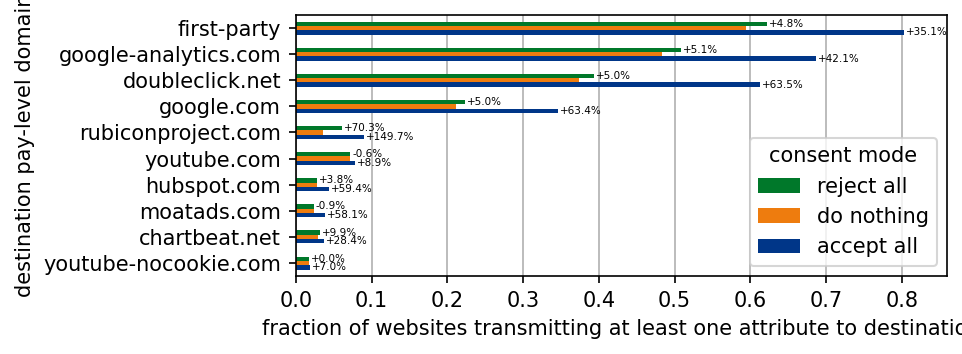

In [65]:

fig, ax = plt.subplots()
fig.set_figheight(2.2)

attributesPerDest = flowReport[flowReport.destinationSimplifiedOthered != 'other']\
    .pivot_table(index='destinationSimplifiedOthered', columns='consentMode', aggfunc={'domain': 'nunique'})\
    .fillna(0)\
    .divide(successfulDomains)\
    .sort_values(('domain', 'acceptAll'))\
    .sort_index(key=keyTldCategory, ascending=False)

attributesPerDest.plot(kind='barh', ax=ax)

ax.set_ylabel('destination pay-level domain')
ax.set_xlabel(
    'fraction of websites transmitting at least one attribute to destination')

ax.set_xlim(right=0.86)

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1]) for c in attributesPerDest.columns]),
    # loc='center left',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

rejectAllIncrease = (attributesPerDest.domain.rejectAll / attributesPerDest.domain.doNothing - 1) * 100
acceptAllIncrease = (attributesPerDest.domain.acceptAll / attributesPerDest.domain.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_top-destinations')
saveLatexTable(attributesPerDest,'destination-ranking.tex')


### Destination Count Per Domain


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

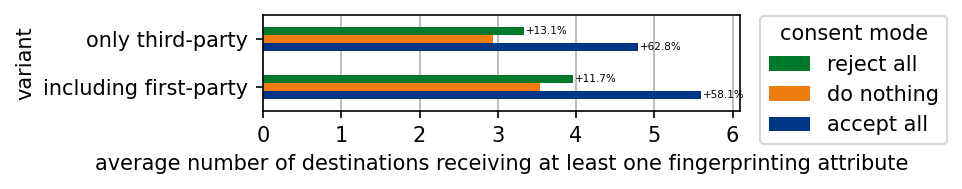

In [66]:

hostCountWithoutFirstParty = flowReport[~flowReport.isFirstParty]\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'destinationHost': 'nunique'})\
    .reset_index()
hostCountWithoutFirstParty['variant'] = 'only third-party'

hostCountWithFirstParty = flowReport\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'destinationHost': 'nunique'})\
    .reset_index()
hostCountWithFirstParty['variant'] = 'including first-party'

avgDestCountPerWebsite = pd.concat([hostCountWithoutFirstParty,hostCountWithFirstParty])\
    .rename(columns={'destinationHost': 'destinationCount'})\
    .pivot_table(index='variant',columns='consentMode', aggfunc={'destinationCount': 'sum'})\
    .divide(successfulDomains).destinationCount


fig, ax = plt.subplots()
fig.set_figheight(1.1)

avgDestCountPerWebsite.plot(kind='barh', ax=ax)

ax.set_xlabel(
    'average number of destinations receiving at least one fingerprinting attribute')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c)
             for c in avgDestCountPerWebsite.columns]),
    loc='upper left',
    bbox_to_anchor=(1.02, 1.1),
    ncol=1,
    title='consent mode',
)

rejectAllIncrease = (avgDestCountPerWebsite.rejectAll / avgDestCountPerWebsite.doNothing - 1) * 100
acceptAllIncrease = (avgDestCountPerWebsite.acceptAll / avgDestCountPerWebsite.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

# ax.set_yticks([])

ax.set_xlim(right=6.1)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_dest-count-per-site')
saveLatexTable(avgDestCountPerWebsite,'destination-count.tex')


In [67]:
avgDestCountPerWebsite

consentMode            acceptAll  doNothing  rejectAll
variant                                               
including first-party   5.598229   3.541804   3.955931
only third-party        4.788715   2.941516   3.328254

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

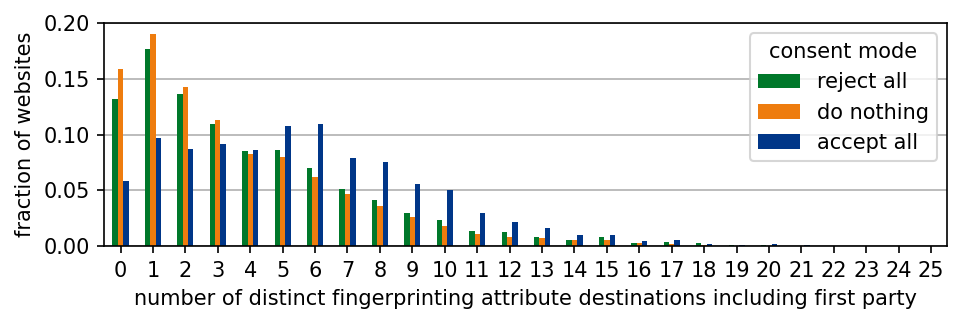

In [68]:
destCountHist = flowReport\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'destinationHost': 'nunique'})\
    .reset_index()\
    .rename(columns={'destinationHost': 'destinationCount'})\
    .merge(successfulDomainsAndModes, how='right')\
    .fillna(0)\
    .pivot_table(index='destinationCount', columns='consentMode', aggfunc={'domain': 'count'})\
    .divide(successfulDomains)\
    .sort_index(axis='columns', ascending=False)

fig, ax = plt.subplots()

fig.set_figheight(2)

destCountHist.plot(ax=ax, kind='bar', color=rdaColors)

ax.set_xlabel(
    'number of distinct fingerprinting attribute destinations including first party')
ax.set_ylabel('fraction of websites')

ax.set_ylim(top=.2)


handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in destCountHist.columns],
    loc='upper right',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=0, ha='center')
ax.xaxis.set_major_formatter(integerFormatter)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_fingerprinting-destination-histogram')
saveLatexTable(destCountHist,'destination-count-hist.tex')


### Destination vs Source/Sink Host

In [69]:
(flowReport.destinationHost == flowReport.sourceHost).value_counts(normalize=True)

True     0.531313
False    0.468687
dtype: float64

In [70]:
(flowReport.destinationHost == flowReport.sinkHost).value_counts(normalize=True)

False    0.507221
True     0.492779
dtype: float64

In [71]:
flowReport.loc[flowReport.destinationHost != flowReport.sourceHost][11000:11020]

domain consentMode  page     pageHost    frameHost  \
28961  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28962  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28963  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28964  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28965  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28966  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28967  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28968  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28969  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28970  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28985  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28986  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28987  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28988  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28989  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28990  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28991  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28992  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28993  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   
28994  nbcnews.com   rejectAll     1  nbcnews.com  nbcnews.com   

      destinationHost                    source     sourceHost  \
28961     conviva.com        Navigator.language  nbcsports.com   
28962     conviva.com  Navigator.maxTouchPoints  nbcsports.com   
28963     conviva.com        Navigator.platform  nbcsports.com   
28964     conviva.com         Navigator.product  nbcsports.com   
28965     conviva.com      Navigator.productSub  nbcsports.com   
28966     conviva.com        Screen.availHeight  nbcsports.com   
28967     conviva.com         Screen.availWidth  nbcsports.com   
28968     conviva.com             Screen.height  nbcsports.com   
28969     conviva.com              Screen.width  nbcsports.com   
28970     conviva.com         Screen.colorDepth  nbcsports.com   
28985     nbcnews.com       Navigator.userAgent  chartbeat.com   
28986     nbcnews.com        Navigator.platform  chartbeat.com   
28987     nbcnews.com              Screen.width  chartbeat.com   
28988     nbcnews.com             Screen.height  chartbeat.com   
28989     nbcnews.com         Screen.colorDepth  chartbeat.com   
28990     nbcnews.com       Navigator.userAgent  chartbeat.com   
28991     nbcnews.com        Navigator.platform  chartbeat.com   
28992     nbcnews.com              Screen.width  chartbeat.com   
28993     nbcnews.com             Screen.height  chartbeat.com   
28994     nbcnews.com         Screen.colorDepth  chartbeat.com   

                      sink       sinkHost destinationSimplified  \
28961  XMLHttpRequest.send  nbcsports.com           conviva.com   
28962  XMLHttpRequest.send  nbcsports.com           conviva.com   
28963  XMLHttpRequest.send  nbcsports.com           conviva.com   
28964  XMLHttpRequest.send  nbcsports.com           conviva.com   
28965  XMLHttpRequest.send  nbcsports.com           conviva.com   
28966  XMLHttpRequest.send  nbcsports.com           conviva.com   
28967  XMLHttpRequest.send  nbcsports.com           conviva.com   
28968  XMLHttpRequest.send  nbcsports.com           conviva.com   
28969  XMLHttpRequest.send  nbcsports.com           conviva.com   
28970  XMLHttpRequest.send  nbcsports.com           conviva.com   
28985      document.cookie  chartbeat.com           first-party   
28986      document.cookie  chartbeat.com           first-party   
28987      document.cookie  chartbeat.com           first-party   
28988      document.cookie  chartbeat.com           first-party   
28989      document.cookie  chartbeat.com           first-party   
28990      document.cookie  chartbeat.com           first-party   
28991      document.cookie  chartbeat.com           first-party   
28992      document.cookie  char

## Sinks

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

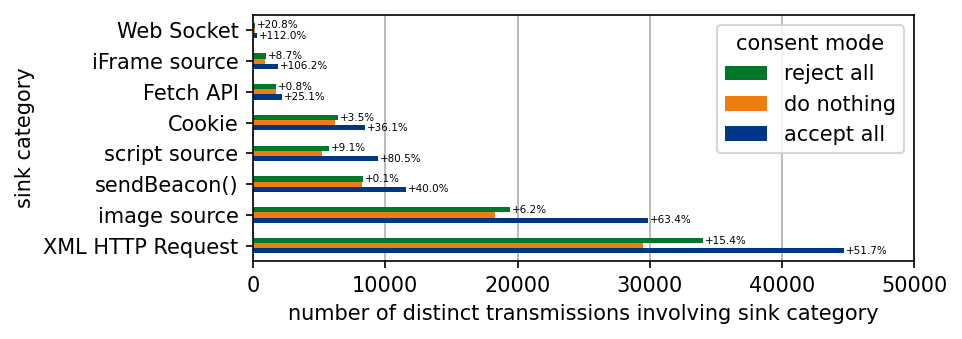

In [72]:
sinkCatActivity = flowReport[['domain', 'consentMode', 'transmission', 'sinkSimplified']]\
    .drop_duplicates()\
    .pivot_table(index='sinkSimplified',columns='consentMode',aggfunc={'domain':'count'})\
    .domain\
    .sort_values(by='acceptAll',ascending=False)

fig, ax = plt.subplots()
fig.set_figheight(2.1)

sinkCatActivity.plot(kind='barh', ax=ax)

ax.set_xlabel('number of distinct transmissions involving sink category')
ax.set_ylabel('sink category')

ax.set_xlim(right=50000)

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c)
             for c in sinkCatActivity.columns]),
    loc='upper right',
    # bbox_to_anchor=(1.02, 1.1),
    ncol=1,
    title='consent mode',
)

rejectAllIncrease = (sinkCatActivity.rejectAll / sinkCatActivity.doNothing - 1) * 100
acceptAllIncrease = (sinkCatActivity.acceptAll / sinkCatActivity.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_transmissions-into-sink-cats')

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

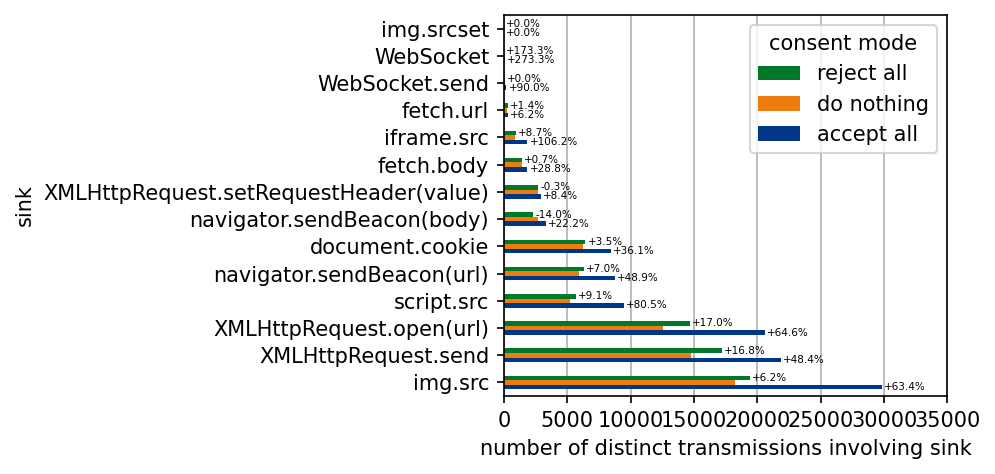

In [73]:
sinkActivityDistinct = flowReport[['domain', 'consentMode', 'transmission', 'sink']]\
    .drop_duplicates()\
    .pivot_table(index='sink',columns='consentMode',aggfunc={'domain':'count'})\
    .domain\
    .sort_values(by='acceptAll',ascending=False)

fig, ax = plt.subplots()
# fig.set_figheight(1.1)

sinkActivityDistinct.plot(kind='barh', ax=ax)

ax.set_xlabel('number of distinct transmissions involving sink')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c)
             for c in sinkActivityDistinct.columns]),
    loc='upper right',
    # bbox_to_anchor=(1.02, 1.1),
    ncol=1,
    title='consent mode',
)

ax.set_xlim(right=35000)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

rejectAllIncrease = (sinkActivityDistinct.rejectAll / sinkActivityDistinct.doNothing - 1) * 100
acceptAllIncrease = (sinkActivityDistinct.acceptAll / sinkActivityDistinct.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

saveFigure(fig,'fingerprinting_scan_transmissions-into-sinks')

Number of unique domains in attribute_combinations: 5464


## Source ⇾ Sink


In [74]:
sourceSinkCombinations = flowReport[['domain', 'consentMode', 'destinationHost', 'source', 'sink']]\
    .drop_duplicates()\
    .pivot_table(values=['domain'], index='source', columns='sink', aggfunc={'domain': 'count'}, margins=True)\
    .fillna(0)\
    .astype('int')\
    .domain

sourceSinkCombinations.style.background_gradient(
    axis=None, cmap='Blues', vmax=20000)  # \
# .set_properties(**{'font-size': '20px'})


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

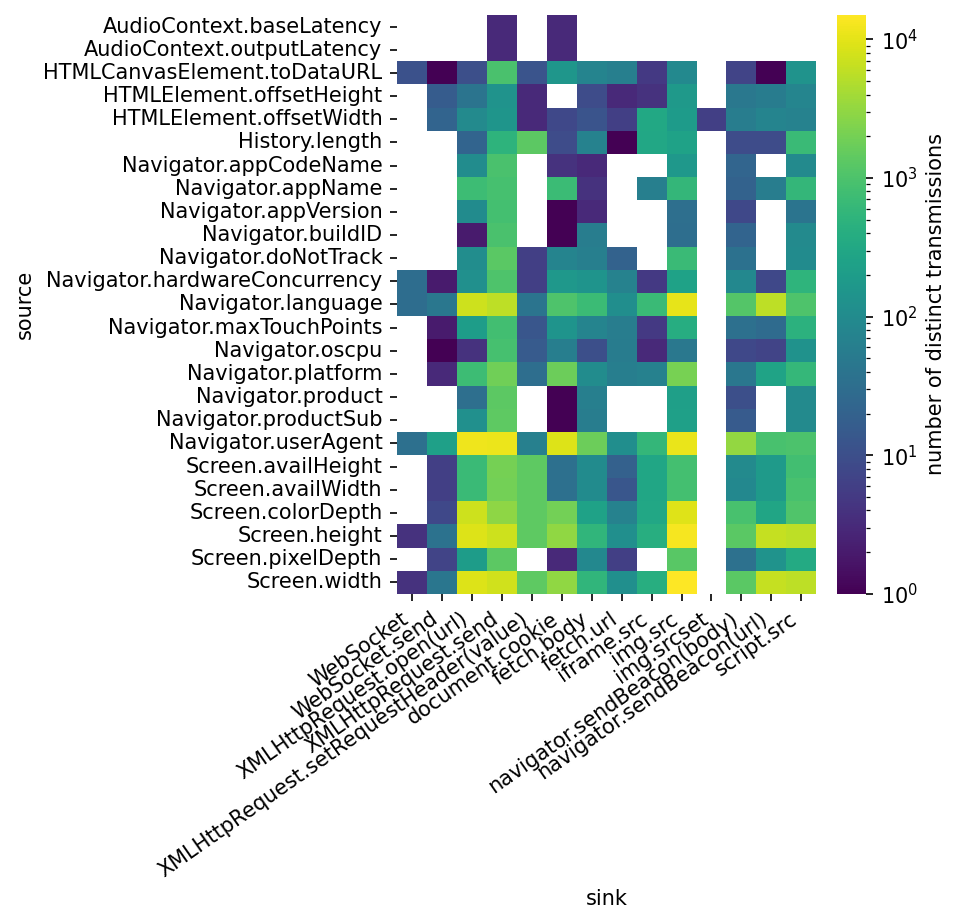

In [75]:
sourceSinkCombinationsWoMargins = sourceSinkCombinations.iloc[0:sourceSinkCombinations.shape[0]-1,0:sourceSinkCombinations.shape[1]-1]


fig, ax = plt.subplots()

fig.set_figheight(6)


sns.heatmap(
    sourceSinkCombinationsWoMargins,
    ax=ax,
    cmap='viridis',
    norm=LogNorm(),
    cbar_kws={'label': 'number of distinct transmissions'})

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

saveFigure(fig,'fingerprinting_scan_transmissions-source-sink')


## Reload / Secondary Page Impact


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

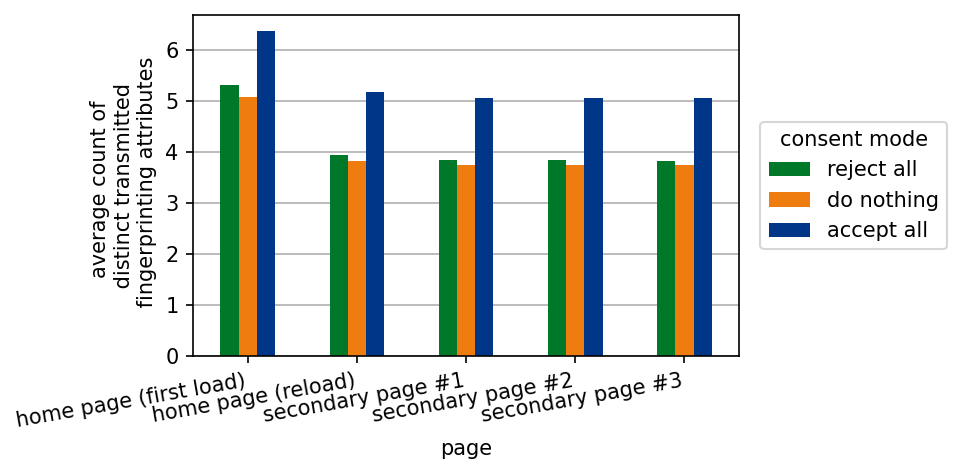

In [76]:
fig, ax = plt.subplots()
# fig.set_figheight(4)

distinctAttributesPerPage = flowReport\
    .pivot_table(index=['domain', 'page', 'consentMode'], aggfunc={'source': 'nunique'})\
    .fillna(0)\
    .reset_index()\
    .pivot_table(index='page', columns='consentMode', aggfunc={'source': 'sum'})\
    .divide(successfulDomains)\
    .sort_index()\
    .sort_index(axis='columns', ascending=False)

distinctAttributesPerPage.plot(kind='bar', ax=ax, color=rdaColors)

ax.set_ylabel(
    'average count of \n distinct transmitted \n fingerprinting attributes')
ax.set_xlabel('page')

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in distinctAttributesPerPage.columns],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)


ax.set_xticks(
    ax.get_xticks(),
    [pageKeyToName(item.get_text()) for item in ax.get_xticklabels()],
    rotation=10,
    ha='right'
)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_page-impact-distinct')


In [77]:
def newlyDiscoveredSources(x):
    pages = sorted(x.page.drop_duplicates().values)
    newlyDiscoveredSourceCounts = []
    discoveredSources = set()
    countBefore = 0
    for pageID in pages:
        discoveredSources.update(x[x.page == pageID].source.values)
        newlyDiscoveredSourceCounts.append(len(discoveredSources)-countBefore)
        countBefore = len(discoveredSources)

    return pd.DataFrame.from_dict({'page': pages, 'sourceCount': newlyDiscoveredSourceCounts})


In [78]:
newlyDiscoveredRaw = flowReport[['domain', 'page', 'consentMode', 'source']].drop_duplicates().groupby(
    ['domain', 'consentMode']).apply(newlyDiscoveredSources).droplevel(2, axis='index').reset_index()
newlyDiscoveredRaw


domain consentMode  page  sourceCount
0        01net.com   acceptAll     0           12
1        01net.com   acceptAll     1            0
2        01net.com   acceptAll     2            0
3        01net.com   acceptAll     3            0
4        01net.com   acceptAll     4            0
...            ...         ...   ...          ...
55729  zzounds.com   rejectAll     0            5
55730  zzounds.com   rejectAll     1            0
55731  zzounds.com   rejectAll     2            0
55732  zzounds.com   rejectAll     3            0
55733  zzounds.com   rejectAll     4            0

[55734 rows x 4 columns]

In [79]:
newlyDiscoveredAttributesPerPage = newlyDiscoveredRaw\
    .pivot_table(index=['page'], columns='consentMode', aggfunc={'sourceCount': 'sum'})\
    .fillna(0)\
    .divide(successfulDomains)\
    .sort_index()\
    .sort_index(axis='columns', ascending=False)
newlyDiscoveredAttributesPerPage

sourceCount                    
consentMode   rejectAll doNothing acceptAll
page                                       
0              5.318575  5.074341  6.367998
1              0.081137  0.059926  0.217463
2              0.322488  0.331137  0.373764
3              0.215198  0.217257  0.211285
4              0.166598  0.177924  0.160214

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

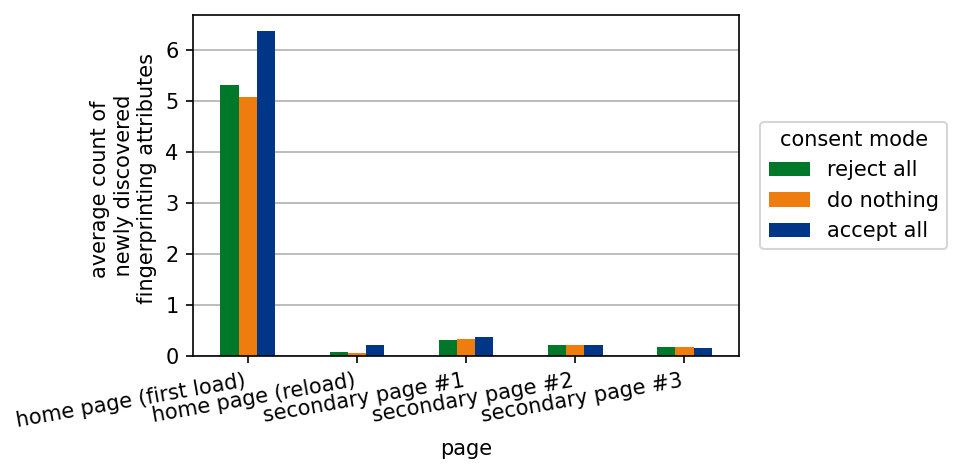

In [80]:
fig, ax = plt.subplots()
# fig.set_figheight(4)

newlyDiscoveredAttributesPerPage.plot(kind='bar', ax=ax, color=rdaColors)

ax.set_ylabel(
    'average count of \n newly discovered \n  fingerprinting attributes')
ax.set_xlabel('page')

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1])
     for c in newlyDiscoveredAttributesPerPage.columns],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_xticks(
    ax.get_xticks(),
    [pageKeyToName(item.get_text()) for item in ax.get_xticklabels()],
    rotation=10,
    ha='right'
)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_page-impact-new-attr')


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

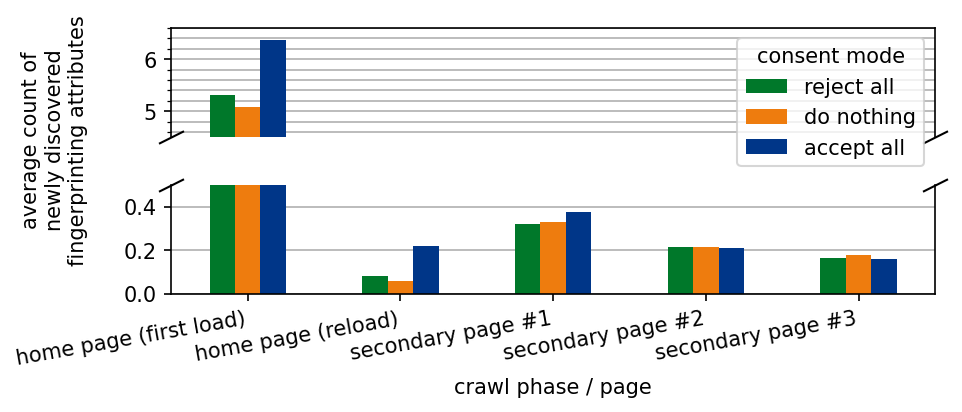

In [81]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# fig.subplots_adjust(hspace=0.05)  # adjust space between axes

fig.set_figheight(2.5)

newlyDiscoveredAttributesPerPage.plot(kind='bar', ax=ax1, color=rdaColors)
newlyDiscoveredAttributesPerPage.plot(kind='bar', ax=ax2, color=rdaColors, legend = False)

ax1.set_ylim(4.5, 6.6)
ax2.set_ylim(0, 0.5)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
# ax1.xaxis.tick_top()
ax2.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_minor_locator(ticker.MultipleLocator(0.2))
ax1.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.tick_params(labeltop=False,bottom=False)
# ax2.xaxis.tick_bottom()

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


# ax2. legend(False)

# fig.supylabel('average count of\nnewly discovered\nfingerprinting attributes',horizontalalignment='center',fontsize='medium')
fig.text(0.01,0.37,'average count of\nnewly discovered\nfingerprinting attributes',multialignment='center',fontsize='medium',rotation=90)
# fig.add
ax2.set_xlabel('crawl phase / page')

handles = ax1.get_legend_handles_labels()
ax1.legend(
    handles[0],
    [consentModeKeyToName(c[1])
     for c in newlyDiscoveredAttributesPerPage.columns],
    loc='upper right',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax2.set_xticks(
    ax2.get_xticks(),
    [pageKeyToName(item.get_text()) for item in ax2.get_xticklabels()],
    rotation=10,
    ha='right'
)

ax1.grid(visible=True, axis='y',which='both')
ax1.set_axisbelow(True)
ax2.grid(visible=True, axis='y')
ax2.set_axisbelow(True)


saveFigure(fig,'fingerprinting_scan_page-impact-new-attr-broken')
saveLatexTable(newlyDiscoveredAttributesPerPage,'secondary-page_impact.tex')


In [82]:
# fig, ax = plt.subplots()
# # fig.set_figheight(4)

# newlyDiscoveredAttributesPerPageAcAl = newlyDiscoveredRaw[(newlyDiscoveredRaw.consentMode == 'acceptAll') & (newlyDiscoveredRaw.sourceCount > 0)]\
#     .pivot_table(index=['page'], columns='sourceCount', aggfunc={'domain': 'count'})\
#     .fillna(0)\
#     .divide(successfulDomains)\
#     .sort_index()


# newlyDiscoveredAttributesPerPageAcAl.plot(kind='bar', ax=ax)


# ax.set_ylabel(
#     'average count of \n newly discovered \n  fingerprinting attributes')
# ax.set_xlabel('page')


# handles = ax.get_legend_handles_labels()
# # ax.legend(
# #     handles[0],
# #     [consentModeKeyToName(c[1]) for c in newlyDiscoveredAttributesPerPageAcAl.columns],
# #     loc='center left',
# #     bbox_to_anchor=(1.02,0.5),
# #     ncol=1,
# #     title='consent mode',
# # )

# ax.set_xticks(
#     ax.get_xticks(),
#     [pageKeyToName(item.get_text()) for item in ax.get_xticklabels()],
#     rotation=10,
#     ha='right'
# )

# ax.grid(visible=True, axis='y')
# ax.set_axisbelow(True)

# saveFigure(fig,'fingerprinting_scan_page-impact-new-attr-hist')
# plt.show()


## Top Level Domain Impact

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.


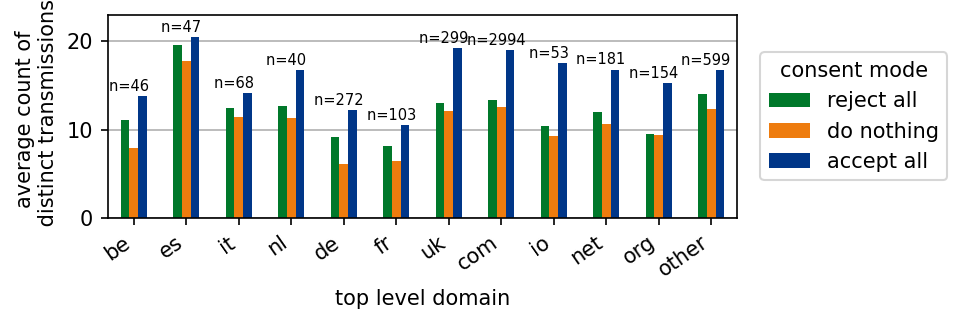

In [83]:
fig, ax = plt.subplots()
fig.set_figheight(2)

sourceCountByTld = flowReport\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'transmission': 'nunique'}, fill_value=0,)\
    .reset_index()\
    .merge(statusReport[['domain', 'tld_othered']], how='left')\
    .pivot_table(index='tld_othered', columns='consentMode', aggfunc={'transmission': 'sum'})\
    .sort_index()\
    .sort_index(key=keyTldCategory)\
    .sort_index(axis='columns', ascending=False)\
    .divide(successfulDomainsAtTldsOthered, axis='rows')\

sourceCountByTld.plot(kind='bar', ax=ax, color=rdaColors)

ax.set_ylabel('average count of \n distinct transmissions')
ax.set_xlabel('top level domain')

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in distinctAttributesPerPage.columns],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_ylim(top=23)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

ax.bar_label(ax.containers[2], [
             'n='+str(l)+'      ' for l in successfulDomainsAtTldsOthered], padding=1, size=7)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_tld-impact-transmissions')


In [84]:
statusReport[~(statusReport.hasErrors)].tld.value_counts().head(25)

com    2994
uk      299
de      272
net     181
org     154
fr      103
it       68
io       53
es       47
be       46
nl       40
pl       39
dk       33
eu       29
co       25
ie       23
se       22
fi       20
au       19
no       18
cz       18
ca       18
edu      17
ch       17
tv       15
Name: tld, dtype: int64

## Tranco Rank Impact

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.


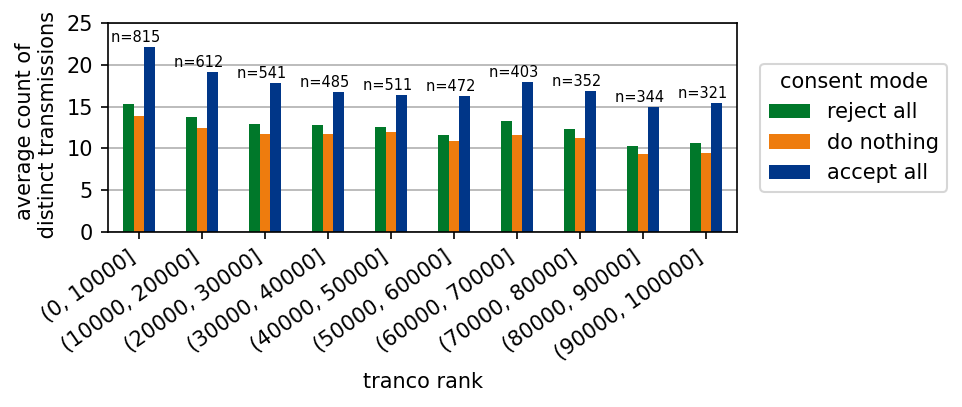

In [85]:
fig, ax = plt.subplots()
fig.set_figheight(2.5)

transmissionsByRank = flowReport\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'transmission': 'nunique'}, fill_value=0,)\
    .reset_index()\
    .merge(statusReport[['domain', 'rank_group']], how='left')\
    .pivot_table(index='rank_group', columns='consentMode', aggfunc={'transmission': 'sum'})\
    .sort_index(axis='columns', ascending=False)\
    .divide(successfulDomainsAtRanks, axis='rows')\

transmissionsByRank.plot(kind='bar', ax=ax, color=rdaColors)

ax.set_ylabel('average count of \n distinct transmissions')
ax.set_xlabel('tranco rank')

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in transmissionsByRank.columns],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_ylim(top=25)


ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

ax.bar_label(ax.containers[2], [
             'n='+str(l)+'      ' for l in successfulDomainsAtRanks], padding=1, size=7)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_rank-impact-transmissions')
saveLatexTable(transmissionsByRank,'fp_attr_rank_impact.tex')


## CMP Impact


In [86]:
statusReport[~statusReport.hasErrors].cmp_simplified_othered_more.value_counts(
).sort_index()


consentmanager.net      97
cookiebar              218
cookiecontrolcivic     128
didomi.io              220
funding choices        215
onetrust              2344
other                  507
quantcast              426
sourcepoint            354
tealium.com            146
trustarc               201
Name: cmp_simplified_othered_more, dtype: int64

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

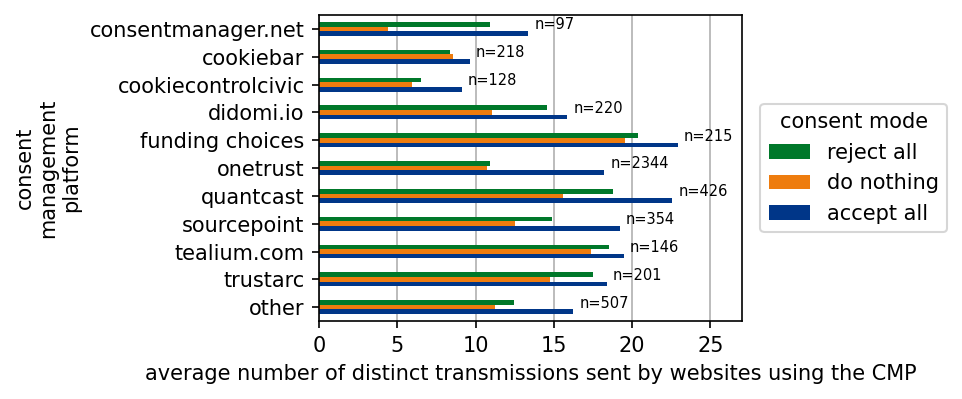

In [87]:
avgAttrCountAtCmp = flowReport\
    .pivot_table(index=['domain', 'consentMode'], aggfunc={'transmission': 'nunique'})\
    .reset_index()\
    .rename(columns={'transmission': 'fpAttrCount'})\
    .merge(statusReport.loc[:, ['domain', 'cmp_simplified_othered_more']], how='left')\
    .pivot_table(index='cmp_simplified_othered_more', columns='consentMode', aggfunc={'fpAttrCount': 'sum'})\
    .sort_index(key=keyOthersToEnd)\
    .divide(successfulDomainsAtCmpsOtheredMore, axis='rows')\
    .sort_index(key=keyOthersToEnd, ascending=False)

fig, ax = plt.subplots()

fig.set_figheight(2.5)

avgAttrCountAtCmp.plot(kind='barh', ax=ax)

ax.set_ylabel('consent\nmanagement\nplatform')
ax.set_xlabel(
    'average number of distinct transmissions sent by websites using the CMP')


handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1]) for c in avgAttrCountAtCmp.columns]),
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.bar_label(ax.containers[0], ['n='+str(l)+'\n' for l in successfulDomainsAtCmpsOtheredMore.sort_index(
    key=keyOthersToEnd, ascending=False)], padding=3, size=7)

ax.set_xlim(right=27)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_attr-count-by-cmp')
saveLatexTable(avgAttrCountAtCmp,'cmp_fp-activity.tex')


## Fingerprinting Classification


### Do Classification


In [88]:
fingerprintingDiagnosis = flowReport\
    .pivot_table(index=['domain', 'consentMode', 'pageHost', 'destinationHost', 'destinationCategory'], aggfunc={'source': [isFingerprinting, 'nunique']})\
    .reset_index()  # .rename(columns={'source':'isFingerprinting'})
fingerprintingDiagnosis.columns = ['domain', 'consentMode', 'pageHost',
                                   'destinationHost', 'destinationCategory', 'isFingerprinting', 'attributeCount']
fingerprintingDiagnosis


domain consentMode     pageHost       destinationHost  \
0        01net.com   acceptAll    01net.com             01net.com   
1        01net.com   acceptAll    01net.com            criteo.com   
2        01net.com   acceptAll    01net.com       doubleclick.net   
3        01net.com   acceptAll    01net.com  google-analytics.com   
4        01net.com   acceptAll    01net.com            google.com   
...            ...         ...          ...                   ...   
64002  zzounds.com   acceptAll  zzounds.com           zzounds.com   
64003  zzounds.com   doNothing  zzounds.com  google-analytics.com   
64004  zzounds.com   doNothing  zzounds.com           zzounds.com   
64005  zzounds.com   rejectAll  zzounds.com  google-analytics.com   
64006  zzounds.com   rejectAll  zzounds.com           zzounds.com   

      destinationCategory  isFingerprinting  attributeCount  
0             first-party             False               1  
1             third-party             False               3  
2             third-party             False               3  
3             third-party             False               5  
4             third-party             False               3  
...                   ...               ...             ...  
64002         first-party             False               3  
64003         third-party             False               5  
64004         first-party             False               3  
64005         third-party             False               5  
64006         first-party             False               3  

[64007 rows x 7 columns]

### Isolate Fingerprinting Flows


In [89]:
fingerprintingFlows = fingerprintingDiagnosis\
    .loc[fingerprintingDiagnosis.isFingerprinting, ['domain', 'consentMode', 'pageHost', 'destinationHost']]\
    .merge(flowReport, how='left')

print(f'Full flow count:           {flowReport.shape[0]}')
print(f'Fingerprinting flow count:  {fingerprintingFlows.shape[0]}')
print(
    f'Difference:                {flowReport.shape[0]-fingerprintingFlows.shape[0]}')


fingerprintingFlows


Full flow count:           1588474
Fingerprinting flow count:  463164
Difference:                1125310


domain consentMode      pageHost destinationHost  page  \
0          01net.com   acceptAll     01net.com     moatads.com     0   
1          01net.com   acceptAll     01net.com     moatads.com     0   
2          01net.com   acceptAll     01net.com     moatads.com     0   
3          01net.com   acceptAll     01net.com     moatads.com     0   
4          01net.com   acceptAll     01net.com     moatads.com     0   
...              ...         ...           ...             ...   ...   
463159  zycrypto.com   rejectAll  zycrypto.com     youtube.com     4   
463160  zycrypto.com   rejectAll  zycrypto.com     youtube.com     4   
463161  zycrypto.com   rejectAll  zycrypto.com     youtube.com     4   
463162  zycrypto.com   rejectAll  zycrypto.com     youtube.com     4   
463163  zycrypto.com   rejectAll  zycrypto.com     youtube.com     4   

          frameHost                         source   sourceHost  \
0         01net.com  Navigator.hardwareConcurrency  moatads.com   
1         01net.com             Navigator.platform  moatads.com   
2         01net.com            Navigator.userAgent  moatads.com   
3         01net.com       Navigator.maxTouchPoints  moatads.com   
4         01net.com              Navigator.appName  moatads.com   
...             ...                            ...          ...   
463159  youtube.com             Screen.availHeight  youtube.com   
463160  youtube.com              Screen.availWidth  youtube.com   
463161  youtube.com              Screen.colorDepth  youtube.com   
463162  youtube.com              Screen.availWidth  youtube.com   
463163  youtube.com            Navigator.userAgent  youtube.com   

                                          sink     sinkHost  \
0                                   script.src  moatads.com   
1                                   script.src  moatads.com   
2                                   script.src  moatads.com   
3                                   script.src  moatads.com   
4                                   script.src  moatads.com   
...                                        ...          ...   
463159  XMLHttpRequest.setRequestHeader(value)  youtube.com   
463160  XMLHttpRequest.setRequestHeader(value)  youtube.com   
463161  XMLHttpRequest.setRequestHeader(value)  youtube.com   
463162  XMLHttpRequest.setRequestHeader(value)  youtube.com   
463163                     XMLHttpRequest.send  youtube.com   

       destinationSimplified destinationSimplifiedOthered  isFirstParty  \
0                moatads.com                  moatads.com         False   
1                moatads.com                  moatads.com         False   
2                moatads.com                  moatads.com         False   
3                moatads.com                  moatads.com         False   
4                moatads.com                  moatads.com         False   
...                      ...                          ...           ...   
463159           youtube.com                  youtube.com         False   
463160           youtube.com                  youtube.com         False   
463161           youtube.com                  youtube.com         False   
463162           youtube.com                  youtube.com         False   
463163           youtube.com                  youtube.com         False   

       destinationCategory                               transmission  \
0              third-party  Navigator.hardwareConcurrency:moatads.com   
1              third-party             Navigator.platform:moatads.com   
2              third-party            Navigator.userAgent:moatads.com   
3              third-party       Navigator.maxTouchPoints:moatads.com   
4              third-party              Navigator.appName:moatads.com   
...                    ...                                        ...   
463159         third-party             Screen.availHeight:youtube.com   
463160         third-party              Screen.availWidth:youtube.com   
463161         third-party   

### Consent Impact on Browser Fingerprinting


In [90]:

fingerprintingPages = successfulDomainsAndModes.merge(
    fingerprintingDiagnosis[['domain', 'consentMode', 'isFingerprinting']].groupby(
        ['domain', 'consentMode']).max().reset_index(),
    how='left'
).fillna(False)

consentImpactAbsolute = fingerprintingPages.pivot_table(
    index=['consentMode'], columns='isFingerprinting', aggfunc={'domain': 'count'})
consentImpactAbsolute


domain      
isFingerprinting  False True 
consentMode                  
acceptAll          2827  2029
doNothing          3339  1517
rejectAll          3214  1642

In [91]:
consentImpactRelative = consentImpactAbsolute.divide(successfulDomains)
consentImpactRelative


domain          
isFingerprinting     False     True 
consentMode                         
acceptAll         0.582166  0.417834
doNothing         0.687603  0.312397
rejectAll         0.661862  0.338138

### Difference Between first/third Party


In [92]:
partyFingerprintingPages = successfulDomainsAndModes.merge(
    Series(['first-party', 'third-party']).rename('destinationCategory'),
    how='cross'
).merge(
    fingerprintingDiagnosis[['domain', 'consentMode', 'isFingerprinting', 'destinationCategory']].groupby(
        ['domain', 'consentMode', 'destinationCategory']).max().reset_index(),
    how='left'
).fillna(False)  # .astype({'isFingerprinting':'int'})

partyFingerprintingPages


domain consentMode destinationCategory  isFingerprinting
0          yahoo.com   acceptAll         first-party             False
1          yahoo.com   acceptAll         third-party             False
2          yahoo.com   rejectAll         first-party             False
3          yahoo.com   rejectAll         third-party             False
4          yahoo.com   doNothing         first-party             False
...              ...         ...                 ...               ...
29131  fdocuments.in   acceptAll         third-party              True
29132  fdocuments.in   rejectAll         first-party             False
29133  fdocuments.in   rejectAll         third-party             False
29134  fdocuments.in   doNothing         first-party             False
29135  fdocuments.in   doNothing         third-party             False

[29136 rows x 4 columns]

In [93]:
combinedLines = partyFingerprintingPages.pivot_table(
    index=['domain', 'consentMode'], aggfunc={'isFingerprinting': 'max'}).reset_index()
combinedLines['destinationCategory'] = 'combined'
partyFingerprintingPages = pd.concat([partyFingerprintingPages, combinedLines])
partyFingerprintingPages


domain consentMode destinationCategory  isFingerprinting
0        yahoo.com   acceptAll         first-party             False
1        yahoo.com   acceptAll         third-party             False
2        yahoo.com   rejectAll         first-party             False
3        yahoo.com   rejectAll         third-party             False
4        yahoo.com   doNothing         first-party             False
...            ...         ...                 ...               ...
14563    zyxel.com   doNothing            combined             False
14564    zyxel.com   rejectAll            combined             False
14565  zzounds.com   acceptAll            combined             False
14566  zzounds.com   doNothing            combined             False
14567  zzounds.com   rejectAll            combined             False

[43704 rows x 4 columns]

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

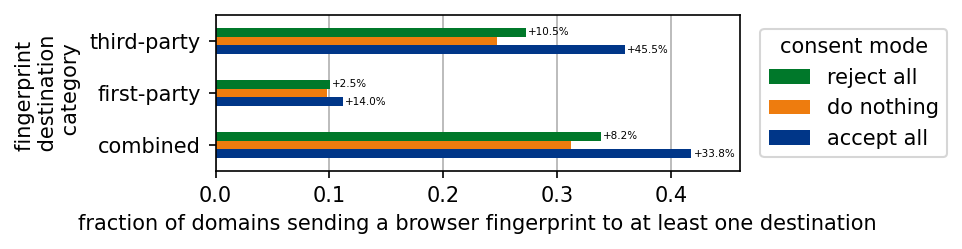

In [94]:

fig, ax = plt.subplots()

consentImpactAbsoluteDestination = partyFingerprintingPages.pivot_table(
    index=['destinationCategory'], columns='consentMode', aggfunc={'isFingerprinting': 'sum'}).divide(successfulDomains)


fig.set_figheight(1.5)

consentImpactAbsoluteDestination.plot(kind='barh', ax=ax)

ax.set_ylabel('fingerprint \n destination \n category')
ax.set_xlabel(
    'fraction of domains sending a browser fingerprint to at least one destination')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1]) for c in attributesPerDest.columns]),
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.set_xlim(right=0.46)

rejectAllIncrease = (consentImpactAbsoluteDestination.isFingerprinting.rejectAll / consentImpactAbsoluteDestination.isFingerprinting.doNothing - 1) * 100
acceptAllIncrease = (consentImpactAbsoluteDestination.isFingerprinting.acceptAll / consentImpactAbsoluteDestination.isFingerprinting.doNothing - 1) * 100

ax.bar_label(ax.containers[2], ['%+.1f%%' % l for l in rejectAllIncrease],fontsize=5, padding=1)
ax.bar_label(ax.containers[0], ['%+.1f%%' % l for l in acceptAllIncrease],fontsize=5, padding=1)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_fingerprinting-fraction')
saveLatexTable(consentImpactAbsoluteDestination,'fp-classification.tex')


In [95]:
consentImpactAbsoluteDestination

isFingerprinting                    
consentMode                acceptAll doNothing rejectAll
destinationCategory                                     
combined                    0.417834  0.312397  0.338138
first-party                 0.112026  0.098229  0.100700
third-party                 0.359349  0.246911  0.272858

In [96]:
partyFingerprintingPages.pivot_table(
    index=['destinationCategory'], columns='consentMode', aggfunc={'isFingerprinting': 'sum'})


isFingerprinting                    
consentMode                acceptAll doNothing rejectAll
destinationCategory                                     
combined                        2029      1517      1642
first-party                      544       477       489
third-party                     1745      1199      1325

### Fingerprinting at Ranks


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

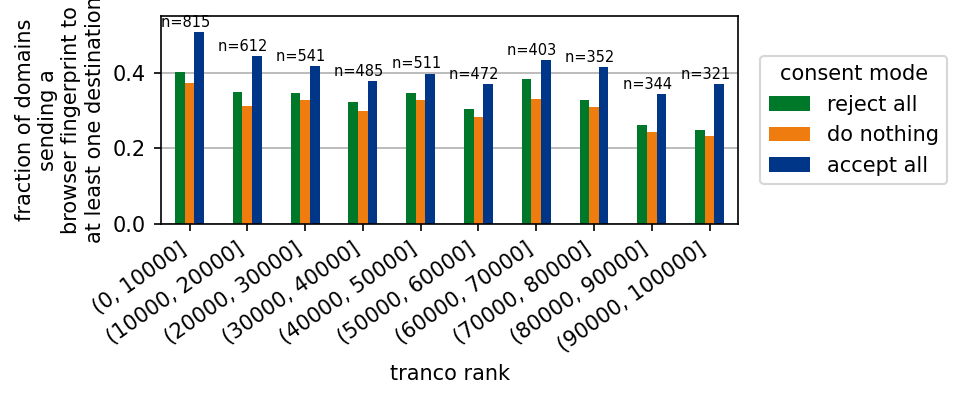

In [97]:
fig, ax = plt.subplots()

consentImpactRanks = partyFingerprintingPages.merge(tranco)\
    .pivot_table(index=['domain', 'rank_group', 'consentMode'], aggfunc={'isFingerprinting': 'max'})\
    .fillna(False)\
    .reset_index()\
    .pivot_table(index=['rank_group'], columns='consentMode', aggfunc={'isFingerprinting': 'sum'})\
    .divide(successfulDomainsAtRanks, axis='rows')\
    .sort_index(axis='columns', ascending=False)

fig.set_figheight(2.5)

consentImpactRanks.plot(kind='bar', ax=ax, color=rdaColors)

ax.set_xlabel('tranco rank')
ax.set_ylabel(
    'fraction of domains\nsending a\nbrowser fingerprint to\nat least one destination')

handles = ax.get_legend_handles_labels()
ax.legend(
    handles[0],
    [consentModeKeyToName(c[1]) for c in consentImpactRanks.columns],
    loc='center left',
    bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.grid(visible=True, axis='y')
ax.set_axisbelow(True)

ax.set_ylim(top=0.55)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=35, ha='right')

ax.bar_label(ax.containers[2], [
             'n='+str(l)+'      ' for l in successfulDomainsAtRanks], padding=1, size=7)

saveFigure(fig,'fingerprinting_scan_fingerprinting-rank_impact')
saveLatexTable(consentImpactRanks,'fp-classification_rank.tex')


### Most used Fingerprinting Attributes in Fingerprinters


findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: Font family 'Charter' not found.
findfont: F

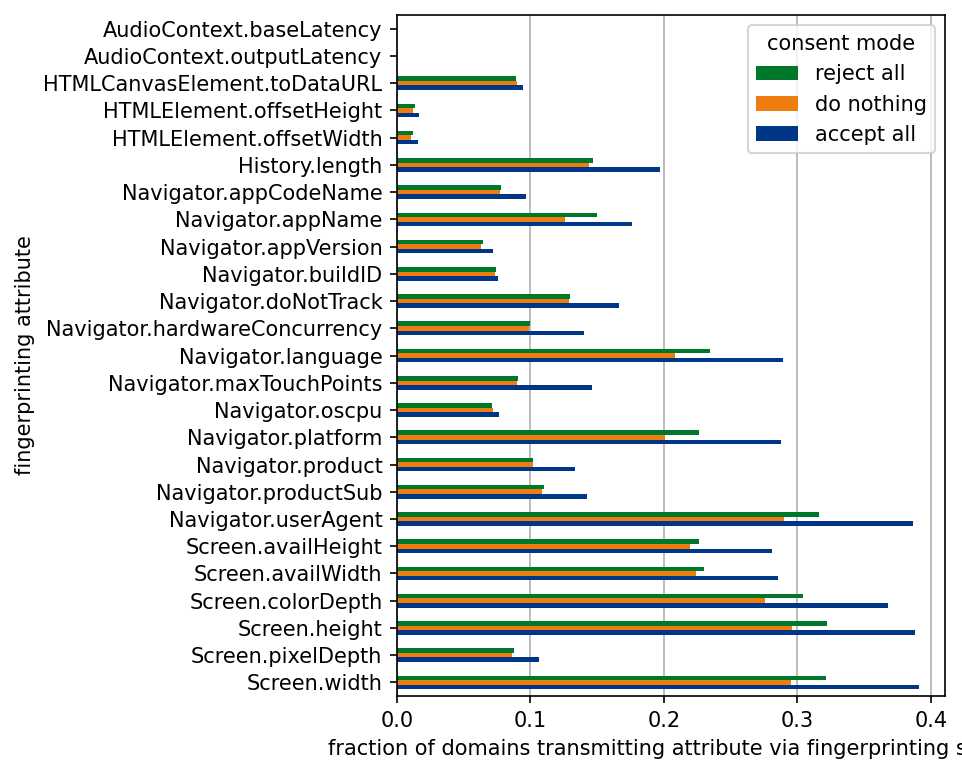

In [98]:
fig, ax = plt.subplots()
fig.set_figheight(5)


fingerprintersTransmittingFpAttrAbs = fingerprintingFlows\
    .pivot_table(index='source', columns='consentMode', aggfunc={'domain': 'nunique'})\
    .sort_index(ascending=False)

fingerprintersTransmittingFpAttr = fingerprintersTransmittingFpAttrAbs\
    .divide(successfulDomains)

fingerprintersTransmittingFpAttr.plot(kind='barh', ax=ax)

ax.set_ylabel('fingerprinting attribute')
ax.set_xlabel(
    'fraction of domains transmitting attribute via fingerprinting script')

handles = ax.get_legend_handles_labels()
ax.legend(
    reversed(handles[0]),
    reversed([consentModeKeyToName(c[1])
             for c in fingerprintersTransmittingFpAttr.columns]),
    # loc='center left',
    # bbox_to_anchor=(1.02, 0.5),
    ncol=1,
    title='consent mode',
)

ax.grid(visible=True, axis='x')
ax.set_axisbelow(True)

saveFigure(fig,'fingerprinting_scan_fingerprinting-attributes_only-fingerprinters')


### Sample Fingerprinting Activity


In [99]:
fingerprintingActivitySample = fingerprintingDiagnosis[fingerprintingDiagnosis.isFingerprinting]\
    .sample(frac=1, random_state=0)

# fingerprintingActivitySample.to_excel('fingerprintingFindings.xlsx',index=False)

print(f'Size: {fingerprintingActivitySample.shape[0]}')

fingerprintingActivitySample.head(20)


Size: 7356


domain consentMode  \
56139                       tile.com   rejectAll   
61230              websteronline.com   doNothing   
46866  roboticsandautomationnews.com   doNothing   
58462                    unoeuro.com   acceptAll   
56170                    timeout.com   acceptAll   
61081            weatheronline.co.uk   doNothing   
58163                        umc.org   doNothing   
40236                oraclecloud.com   rejectAll   
47918                     scene7.com   acceptAll   
47388                        rtve.es   acceptAll   
30142      lancashiretelegraph.co.uk   acceptAll   
57647                   tvymanga.com   acceptAll   
3033                  androidmtk.com   acceptAll   
46064                    renovero.ch   acceptAll   
54590               thedailyshow.com   acceptAll   
54141                  tennisnet.com   doNothing   
3403                      appcast.io   doNothing   
57722                    typekit.com   acceptAll   
59480                         vhx.tv   acceptAll   
58820                       usta.com   acceptAll   

                            pageHost       destinationHost  \
56139                       tile.com             csftr.com   
61230              websteronline.com           youtube.com   
46866  roboticsandautomationnews.com            google.com   
58462                     simply.com     teamblue.services   
56170                timeoutkorea.kr   adsafeprotected.com   
61081            weatheronline.co.uk       doubleclick.net   
58163                        umc.org       doubleclick.net   
40236                     oracle.com            oracle.com   
47918                      adobe.com             adobe.com   
47388                        rtve.es               rtve.es   
30142      lancashiretelegraph.co.uk           hubspot.com   
57647                   tvymanga.com       doubleclick.net   
3033                  androidmtk.com       doubleclick.net   
46064                    renovero.ch  google-analytics.com   
54590                         cc.com           moatads.com   
54141                  tennisnet.com       doubleclick.net   
3403                      appcast.io           youtube.com   
57722                      adobe.com             adobe.com   
59480                      vimeo.com         appsflyer.com   
58820                       usta.com       doubleclick.net   

      destinationCategory  isFingerprinting  attributeCount  
56139         third-party              True              12  
61230         third-party              True               7  
46866         third-party              True               7  
58462         third-party              True              10  
56170         third-party              True              13  
61081         third-party              True               7  
58163         third-party              True               7  
40236         first-party              True              18  
47918         first-party              True              18  
47388         first-party              True               8  
30142         third-party              True               7  
57647         third-party              True              10  
3033          third-party              True               7  
46064         third-party              True               7  
54590         third-party              True              10  
54141         third-party              True               7  
3403          third-party              True               7  
57722         first-party              True               8  
59480         third-party              True               7  
58820         third-party              True               7